In [1]:
import sys
from pathlib import Path

# Go one level up from current notebook directory
src_path = Path.cwd().parents[0]  
sys.path.append(str(src_path))

from utils.athena_utils import query_athena_to_polars

# Evolução mensal do saldo de empregos — Top 5 seções CNAE em PE (2023)

Como o saldo líquido de empregos variou ao longo de 2023 nas cinco seções da CNAE com maior fluxo em Pernambuco?

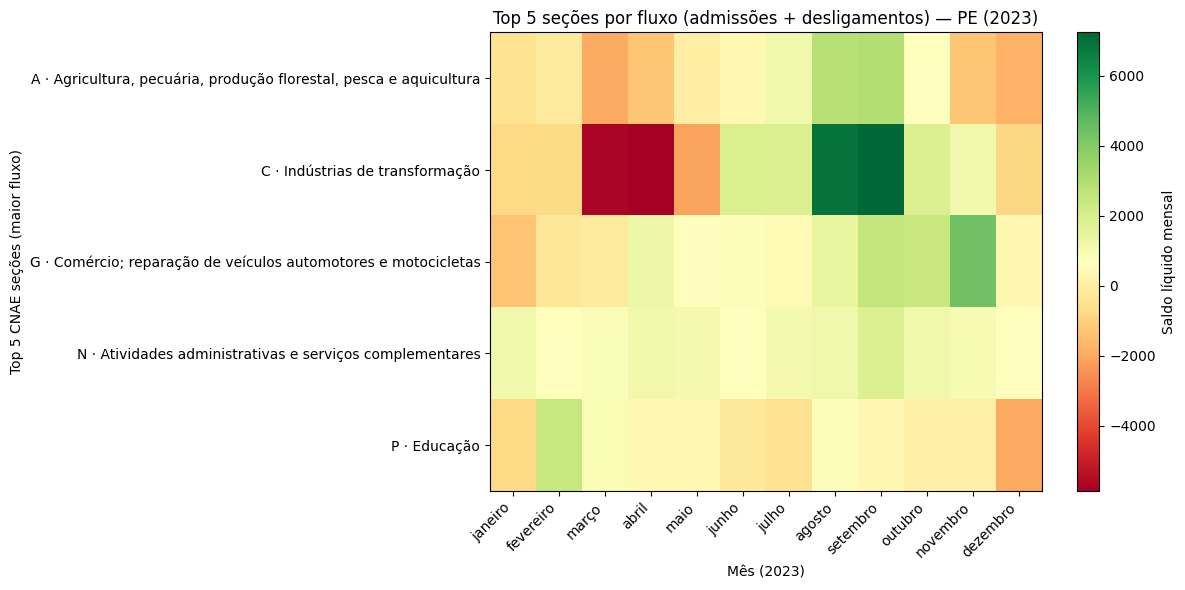

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- SQL query: compute everything directly in Athena ---
query = """
WITH full_year AS (
    SELECT 
        ano
    FROM silver.caged__base_dos_dados__novo
    WHERE sigla_uf = 'PE'
    GROUP BY ano
    HAVING COUNT(DISTINCT mes) = 12
    ORDER BY ano DESC
    LIMIT 1
),
base AS (
    SELECT 
        cnae_2_secao,
        mes,
        SUM(saldo_movimentacao) AS movement
    FROM silver.caged__base_dos_dados__novo
    WHERE sigla_uf = 'PE'
      AND ano = (SELECT ano FROM full_year)
    GROUP BY cnae_2_secao, mes
),
flux_totals AS (
    SELECT 
        cnae_2_secao,
        SUM(ABS(movement)) AS flux_total
    FROM base
    GROUP BY cnae_2_secao
),
top5 AS (
    SELECT cnae_2_secao
    FROM flux_totals
    ORDER BY flux_total DESC
    LIMIT 5
)
SELECT 
    b.cnae_2_secao,
    b.mes,
    b.movement
FROM base b
JOIN top5 t ON b.cnae_2_secao = t.cnae_2_secao
ORDER BY b.cnae_2_secao, b.mes;

"""

# --- Run query with helper ---
s3_staging_dir = 's3://observatorio-trabalho-pe-ds-resources-dev/query_results'
df = query_athena_to_polars(
    query=query,
    s3_staging_dir=s3_staging_dir,
    lazy_mode=False
).to_pandas()

# --- CNAE seção mapping ---
secao_names = {
    "A": "A · Agricultura, pecuária, produção florestal, pesca e aquicultura",
    "B": "B · Indústrias extrativas",
    "C": "C · Indústrias de transformação",
    "D": "D · Eletricidade e gás",
    "E": "E · Água, esgoto, atividades de gestão de resíduos e descontaminação",
    "F": "F · Construção",
    "G": "G · Comércio; reparação de veículos automotores e motocicletas",
    "H": "H · Transporte, armazenagem e correio",
    "I": "I · Alojamento e alimentação",
    "J": "J · Informação e comunicação",
    "K": "K · Atividades financeiras, de seguros e serviços relacionados",
    "L": "L · Atividades imobiliárias",
    "M": "M · Atividades profissionais, científicas e técnicas",
    "N": "N · Atividades administrativas e serviços complementares",
    "O": "O · Administração pública, defesa e seguridade social",
    "P": "P · Educação",
    "Q": "Q · Saúde humana e serviços sociais",
    "R": "R · Artes, cultura, esporte e recreação",
    "S": "S · Outras atividades de serviços",
    "T": "T · Serviços domésticos",
    "U": "U · Organismos internacionais e outras instituições extraterritoriais"
}

df["secao_label"] = df["cnae_2_secao"].map(secao_names).fillna(df["cnae_2_secao"])

# --- Month mapping ---
month_names = {
    1: "janeiro", 2: "fevereiro", 3: "março", 4: "abril",
    5: "maio", 6: "junho", 7: "julho", 8: "agosto",
    9: "setembro", 10: "outubro", 11: "novembro", 12: "dezembro"
}
df["month_name"] = df["mes"].map(month_names)

# --- Pivot to matrix for heatmap ---
pvt_top5 = df.pivot_table(
    index="secao_label",
    columns="month_name",
    values="movement",
    aggfunc="sum",
    fill_value=0
)

# Order columns chronologically
ordered_months = [month_names[m] for m in range(1, 13) if month_names[m] in pvt_top5.columns]
pvt_top5 = pvt_top5[ordered_months]

# --- Plot heatmap (green→red) ---
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(pvt_top5.values, aspect="auto", cmap="RdYlGn")

ax.set_xticks(np.arange(pvt_top5.shape[1]))
ax.set_xticklabels(pvt_top5.columns, rotation=45, ha="right")
ax.set_yticks(np.arange(pvt_top5.shape[0]))
ax.set_yticklabels(pvt_top5.index)

ax.set_xlabel("Mês (2023)")
ax.set_ylabel("Top 5 CNAE seções (maior fluxo)")
ax.set_title("Top 5 seções por fluxo (admissões + desligamentos) — PE (2023)")

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Saldo líquido mensal")

plt.tight_layout()
plt.show()


# Setor econômico predominante por município em Pernambuco

Qual é o principal setor econômico (seção da CNAE) de cada município de Pernambuco, considerando o ano mais recente disponível?

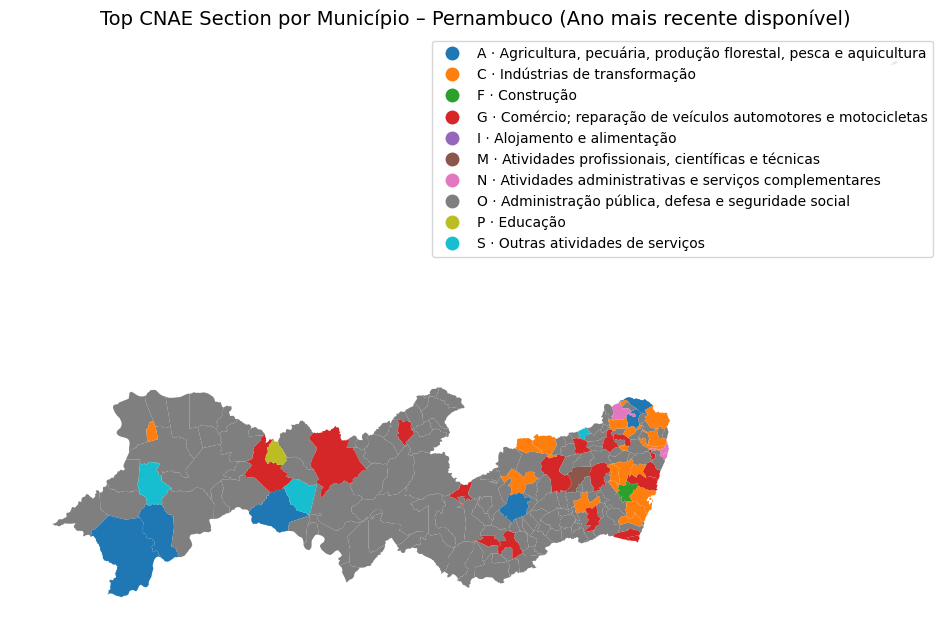

In [ ]:
import geopandas as gpd

# --- Query: compute everything in Athena ---
query = """
WITH latest_year AS (
    SELECT ano
    FROM silver.rais__base_dos_dados__vinculos
    WHERE sigla_uf = 'PE'
    GROUP BY ano
    ORDER BY ano DESC
    LIMIT 1
),
base AS (
    SELECT
        id_municipio,
        TRY_CAST(substr(regexp_replace(CAST(cnae_2 AS VARCHAR), '\\D+', ''), 1, 2) AS INTEGER) AS cnae_div,
        COUNT(*) AS count_vinculos
    FROM silver.rais__base_dos_dados__vinculos
    WHERE sigla_uf = 'PE'
      AND ano = (SELECT ano FROM latest_year)
      AND cnae_2 IS NOT NULL
    GROUP BY id_municipio, cnae_2
),
cnae_mapped AS (
    SELECT
        id_municipio,
        CASE 
            WHEN cnae_div BETWEEN 1 AND 3  THEN 'A'
            WHEN cnae_div BETWEEN 5 AND 9  THEN 'B'
            WHEN cnae_div BETWEEN 10 AND 33 THEN 'C'
            WHEN cnae_div = 35             THEN 'D'
            WHEN cnae_div BETWEEN 36 AND 39 THEN 'E'
            WHEN cnae_div BETWEEN 41 AND 43 THEN 'F'
            WHEN cnae_div BETWEEN 45 AND 47 THEN 'G'
            WHEN cnae_div BETWEEN 49 AND 53 THEN 'H'
            WHEN cnae_div BETWEEN 55 AND 56 THEN 'I'
            WHEN cnae_div BETWEEN 58 AND 63 THEN 'J'
            WHEN cnae_div BETWEEN 64 AND 66 THEN 'K'
            WHEN cnae_div = 68             THEN 'L'
            WHEN cnae_div BETWEEN 69 AND 75 THEN 'M'
            WHEN cnae_div BETWEEN 77 AND 82 THEN 'N'
            WHEN cnae_div = 84             THEN 'O'
            WHEN cnae_div = 85             THEN 'P'
            WHEN cnae_div BETWEEN 86 AND 88 THEN 'Q'
            WHEN cnae_div BETWEEN 90 AND 93 THEN 'R'
            WHEN cnae_div BETWEEN 94 AND 96 THEN 'S'
            WHEN cnae_div BETWEEN 97 AND 98 THEN 'T'
            WHEN cnae_div = 99             THEN 'U'
            ELSE NULL
        END AS top_section_candidate,
        count_vinculos
    FROM base
    WHERE cnae_div IS NOT NULL
),
agg AS (
    SELECT
        id_municipio,
        top_section_candidate AS cnae_section,
        SUM(count_vinculos) AS total_vinculos
    FROM cnae_mapped
    WHERE top_section_candidate IS NOT NULL
    GROUP BY id_municipio, top_section_candidate
),
top_section AS (
    SELECT 
        id_municipio,
        cnae_section AS top_section,
        total_vinculos AS max_vinculos,
        ROW_NUMBER() OVER (PARTITION BY id_municipio ORDER BY total_vinculos DESC) AS rn
    FROM agg
)
SELECT 
    id_municipio,
    top_section,
    max_vinculos
FROM top_section
WHERE rn = 1
ORDER BY id_municipio;


"""

# --- Run query ---
s3_staging_dir = "s3://observatorio-trabalho-pe-ds-resources-dev/query_results"
top_specialization = query_athena_to_polars(
    query=query,
    s3_staging_dir=s3_staging_dir,
    lazy_mode=False
)

# --- CNAE seção mapping (keep your original dictionary) ---
secao_names = {
    "A": "A · Agricultura, pecuária, produção florestal, pesca e aquicultura",
    "B": "B · Indústrias extrativas",
    "C": "C · Indústrias de transformação",
    "D": "D · Eletricidade e gás",
    "E": "E · Água, esgoto, atividades de gestão de resíduos e descontaminação",
    "F": "F · Construção",
    "G": "G · Comércio; reparação de veículos automotores e motocicletas",
    "H": "H · Transporte, armazenagem e correio",
    "I": "I · Alojamento e alimentação",
    "J": "J · Informação e comunicação",
    "K": "K · Atividades financeiras, de seguros e serviços relacionados",
    "L": "L · Atividades imobiliárias",
    "M": "M · Atividades profissionais, científicas e técnicas",
    "N": "N · Atividades administrativas e serviços complementares",
    "O": "O · Administração pública, defesa e seguridade social",
    "P": "P · Educação",
    "Q": "Q · Saúde humana e serviços sociais",
    "R": "R · Artes, cultura, esporte e recreação",
    "S": "S · Outras atividades de serviços",
    "T": "T · Serviços domésticos",
    "U": "U · Organismos internacionais e outras instituições extraterritoriais"
}

# --- Convert to Pandas and prepare for merging ---
df = top_specialization.to_pandas().copy()
df["id_municipio"] = df["id_municipio"].astype(str).str.zfill(7)
df["top_section_full"] = df["top_section"].map(secao_names)

# --- Load municipalities and filter for Pernambuco ---
url = "https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-100-mun.json"
br_munis = gpd.read_file(url)
pe_munis = br_munis[br_munis["id"].astype(str).str.startswith("26")]

# --- Merge specialization with geometry ---
pe_map = pe_munis.merge(
    df,
    left_on="id",
    right_on="id_municipio",
    how="left",
    validate="one_to_one"
)

# --- Plot map ---
fig, ax = plt.subplots(figsize=(12, 8))
pe_map.plot(
    column="top_section_full",
    categorical=True,
    legend=True,
    ax=ax,
    missing_kwds={"color": "lightgrey", "label": "Sem dados"}
)
ax.set_title("Top CNAE Section por Município – Pernambuco (Ano mais recente disponível)", fontsize=14)
ax.axis("off")
plt.show()


# Média salarial por município em Pernambuco

Como varia a média salarial entre os municípios de Pernambuco no ano mais recente disponível?

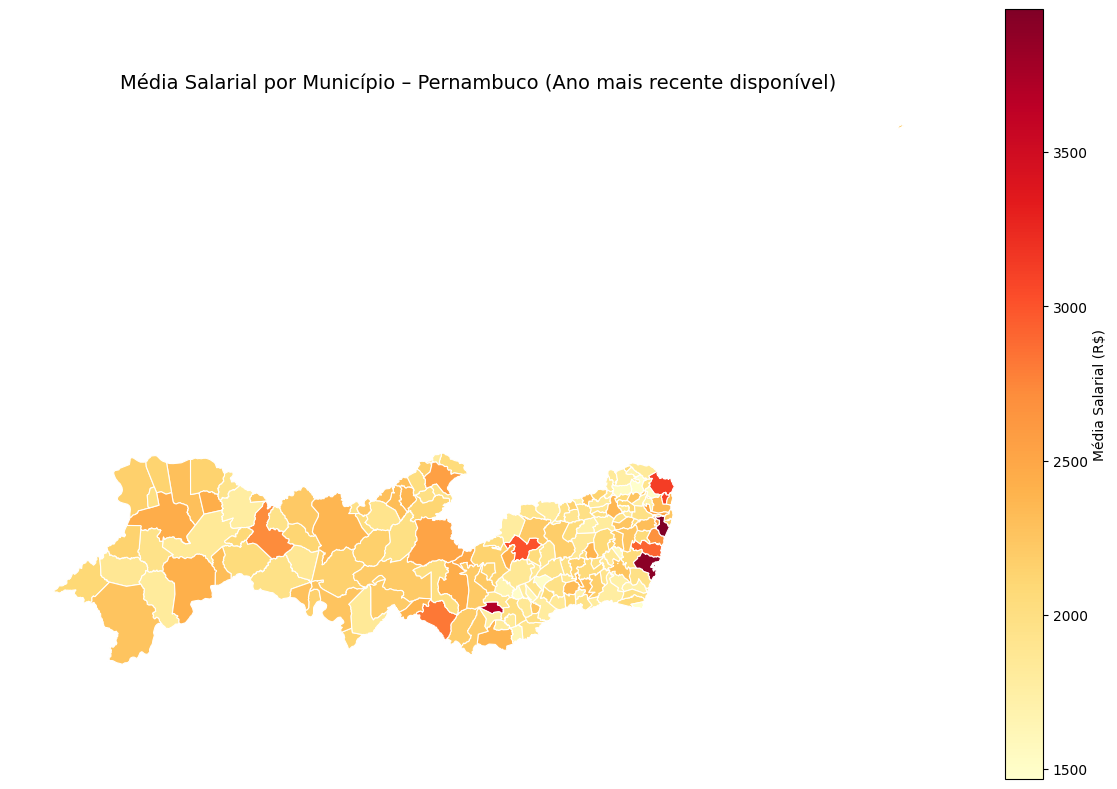

In [25]:
query = """
SELECT
    id_municipio,
    AVG(valor_remuneracao_media) AS mean_valor_remuneracao_media
FROM silver.rais__base_dos_dados__vinculos
WHERE sigla_uf = 'PE'
  AND ano = (
      SELECT MAX(ano)
      FROM silver.rais__base_dos_dados__vinculos
  )
GROUP BY id_municipio
"""

s3_staging_dir = "s3://observatorio-trabalho-pe-ds-resources-dev/query_results"

rais_mean_salary = query_athena_to_polars(
    query=query,
    s3_staging_dir=s3_staging_dir,
    lazy_mode=False
)
import matplotlib.pyplot as plt
import geopandas as gpd

# Convert Polars DataFrame to Pandas if needed
df = rais_mean_salary.to_pandas().copy()
df["id_municipio"] = df["id_municipio"].astype(str).str.zfill(7)

# Merge geometry with mean salary data
pe_map = pe_munis.merge(
    df,
    left_on="id",
    right_on="id_municipio",
    how="left",
    validate="one_to_one"
)

# Plot heatmap of mean salary
fig, ax = plt.subplots(figsize=(12, 8))
pe_map.plot(
    column="mean_valor_remuneracao_media",
    cmap="YlOrRd",                 # Yellow → Red heatmap
    linewidth=0.8,
    edgecolor="white",
    legend=True,
    legend_kwds={
        "label": "Média Salarial (R$)",
        "orientation": "vertical"
    },
    ax=ax,
    missing_kwds={"color": "lightgrey", "label": "Sem dados"}
)

# Style the map
ax.set_title("Média Salarial por Município – Pernambuco (Ano mais recente disponível)", fontsize=14)
ax.axis("off")

plt.tight_layout()
plt.show()


# Principais ocupações formais em Pernambuco

Quais são as ocupações (CBO) com maior número de vínculos formais de trabalho em Pernambuco no ano mais recente disponível?


Comentario: para ficar claro precisariamos o mapeamento de todos cbos para os numeros. 


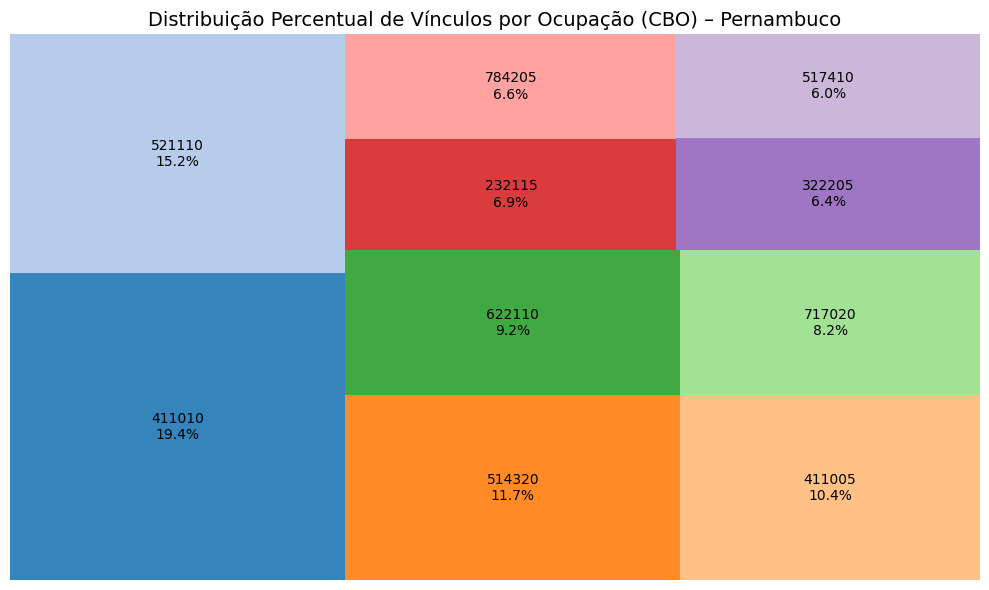

In [28]:
query = """
WITH latest_year AS (
    SELECT MAX(ano) AS ano
    FROM silver.rais__base_dos_dados__vinculos
)
SELECT
    cbo_2002 AS cbo,
    COUNT(*) AS count_vinculos
FROM silver.rais__base_dos_dados__vinculos
WHERE sigla_uf = 'PE'
  AND ano = (SELECT ano FROM latest_year)
GROUP BY cbo_2002
ORDER BY count_vinculos DESC
LIMIT 10
"""

rais_top_cbo = query_athena_to_polars(
    query=query,
    s3_staging_dir="s3://observatorio-trabalho-pe-ds-resources-dev/query_results",
    lazy_mode=False
)

import matplotlib.pyplot as plt
import squarify

# Convert to pandas
df = rais_top_cbo.to_pandas().copy()

# Compute percentage
df["percent"] = 100 * df["count_vinculos"] / df["count_vinculos"].sum()

# Build treemap
fig, ax = plt.subplots(figsize=(10, 6))
squarify.plot(
    sizes=df["percent"],
    label=[f"{row['cbo']}\n{row['percent']:.1f}%" for _, row in df.iterrows()],
    color=plt.cm.tab20.colors,
    alpha=0.9
)

# Style
plt.title("Distribuição Percentual de Vínculos por Ocupação (CBO) – Pernambuco", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

# Distribuição dos vínculos formais por tipo de contratação em Pernambuco


Como estão distribuídos os vínculos formais de trabalho em Pernambuco segundo o tipo de contratação (CLT, estatutário, aprendiz, temporário e outros)

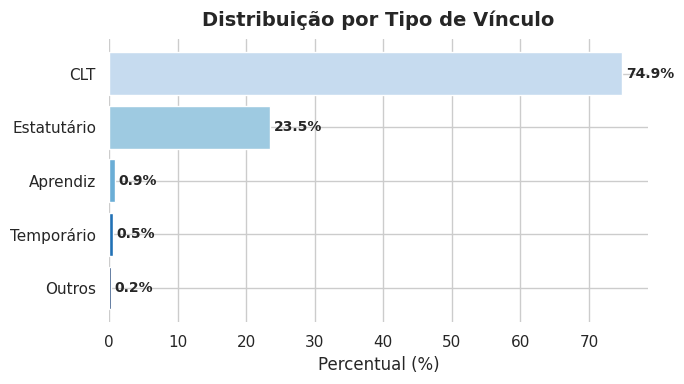

In [31]:
query = """
WITH latest_year AS (
    SELECT MAX(ano) AS ano
    FROM silver.rais__base_dos_dados__vinculos
)
SELECT
    tipo_vinculo
FROM silver.rais__base_dos_dados__vinculos
WHERE sigla_uf = 'PE'
  AND ano = (SELECT ano FROM latest_year)
  AND vinculo_ativo_3112 = '1'
"""
s3_staging_dir = "s3://observatorio-trabalho-pe-ds-resources-dev/query_results"

rais_vinc = query_athena_to_polars(
    query=query,
    s3_staging_dir=s3_staging_dir,
    lazy_mode=False
)
tipo_map = {
    '1': 'CLT',
    '10': 'CLT',
    '15': 'CLT',
    '20': 'CLT',
    '25': 'CLT',
    '60': 'CLT',
    '65': 'CLT',
    '70': 'CLT',
    '75': 'CLT',
    '30': 'Estatutário',
    '31': 'Estatutário',
    '35': 'Estatutário',
    '96': 'Estatutário',
    '97': 'Estatutário',
    '2': 'Estatutário',
    '4': 'Temporário',
    '50': 'Temporário',
    '95': 'Temporário',
    '55': 'Aprendiz',
    '5': 'Outros',
    '40': 'Outros',
    '-1': 'Outros',
}
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Convert to pandas ---
df = rais_vinc.to_pandas()


df["tipo_vinculo_cat"] = df["tipo_vinculo"].map(tipo_map)

# --- Aggregate counts and percentages ---
tipo_counts = (
    df["tipo_vinculo_cat"]
    .value_counts()
    .rename_axis("Tipo de Vínculo")
    .reset_index(name="count")
)
tipo_counts["percent"] = (tipo_counts["count"] / tipo_counts["count"].sum() * 100).round(1)

# Sort ascending for horizontal bars
tipo_counts = tipo_counts.sort_values("count", ascending=True)

# --- Plot ---
sns.set_theme(style="whitegrid")

palette = ["#08306B", "#2171B5", "#6BAED6", "#9ECAE1", "#C6DBEF"]

plt.figure(figsize=(7, 4))
bars = plt.barh(tipo_counts["Tipo de Vínculo"], tipo_counts["percent"], color=palette[:len(tipo_counts)])

# Add percentage labels
for i, (pct) in enumerate(tipo_counts["percent"]):
    plt.text(pct + 0.5, i, f"{pct}%", va="center", fontsize=10, fontweight="bold")

# Titles and labels
plt.title("Distribuição por Tipo de Vínculo", fontsize=14, fontweight="bold", pad=10)
plt.xlabel("Percentual (%)")
plt.ylabel("")

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


# Carga Horária Média por Setor Econômico em Pernambuco

Quais setores econômicos concentram as maiores e menores médias de horas contratuais semanais em Pernambuco?

Atualmente o gráfico apresenta um número elevado de seções da CNAE, o que dificulta a leitura e a comparação visual entre setores. Vamos discutir com a equipe de economistas como agrupar categorias similares (por exemplo, consolidar setores de serviços ou atividades industriais) para tornar a visualização mais interpretável e estratégica.

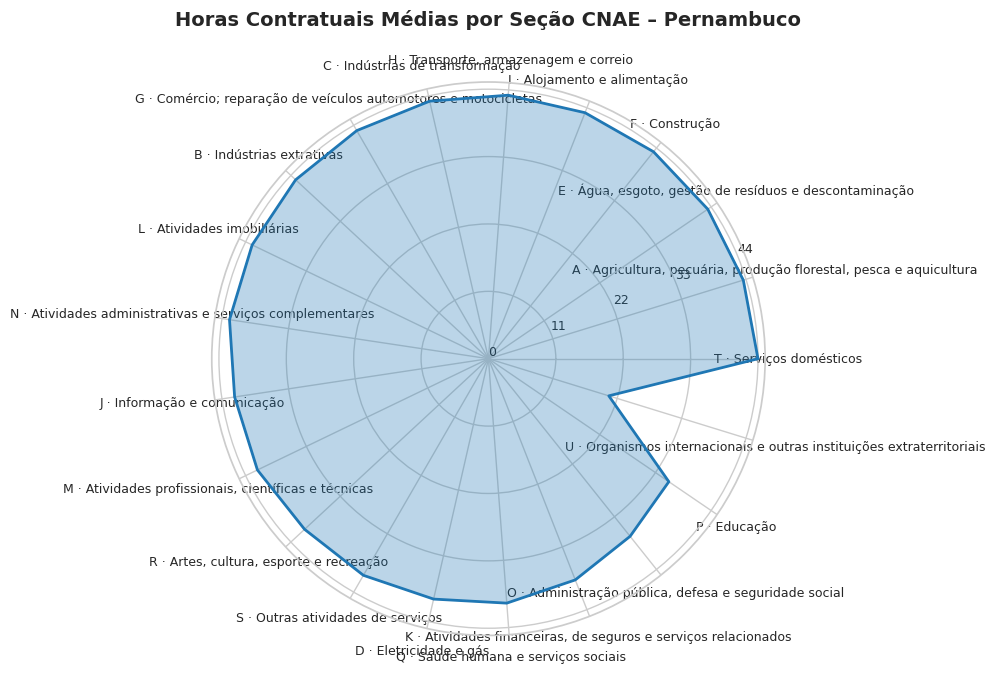

In [34]:
# ============================================================
# HORAS CONTRATUAIS MÉDIAS POR SEÇÃO CNAE – PERNAMBUCO
# ============================================================

import numpy as np

# -------------------------------
# 1) Query RAIS data via Athena
# -------------------------------

query = """
WITH latest_year AS (
    SELECT ano
    FROM silver.rais__base_dos_dados__vinculos
    WHERE sigla_uf = 'PE'
    GROUP BY ano
    ORDER BY ano DESC
    LIMIT 1
),
base AS (
    SELECT
        id_municipio,
        TRY_CAST(substr(regexp_replace(CAST(cnae_2 AS VARCHAR), '\\D+', ''), 1, 2) AS INTEGER) AS cnae_div,
        AVG(quantidade_horas_contratadas) AS media_horas_semanais
    FROM silver.rais__base_dos_dados__vinculos
    WHERE sigla_uf = 'PE'
      AND ano = (SELECT ano FROM latest_year)
      AND CAST(vinculo_ativo_3112 AS VARCHAR) = '1'
      AND cnae_2 IS NOT NULL
    GROUP BY id_municipio, cnae_2
),
mapeado AS (
    SELECT
        id_municipio,
        CASE 
            WHEN cnae_div BETWEEN 1 AND 3 THEN 'A'
            WHEN cnae_div BETWEEN 5 AND 9 THEN 'B'
            WHEN cnae_div BETWEEN 10 AND 33 THEN 'C'
            WHEN cnae_div = 35 THEN 'D'
            WHEN cnae_div BETWEEN 36 AND 39 THEN 'E'
            WHEN cnae_div BETWEEN 41 AND 43 THEN 'F'
            WHEN cnae_div BETWEEN 45 AND 47 THEN 'G'
            WHEN cnae_div BETWEEN 49 AND 53 THEN 'H'
            WHEN cnae_div BETWEEN 55 AND 56 THEN 'I'
            WHEN cnae_div BETWEEN 58 AND 63 THEN 'J'
            WHEN cnae_div BETWEEN 64 AND 66 THEN 'K'
            WHEN cnae_div = 68 THEN 'L'
            WHEN cnae_div BETWEEN 69 AND 75 THEN 'M'
            WHEN cnae_div BETWEEN 77 AND 82 THEN 'N'
            WHEN cnae_div = 84 THEN 'O'
            WHEN cnae_div = 85 THEN 'P'
            WHEN cnae_div BETWEEN 86 AND 88 THEN 'Q'
            WHEN cnae_div BETWEEN 90 AND 93 THEN 'R'
            WHEN cnae_div BETWEEN 94 AND 96 THEN 'S'
            WHEN cnae_div BETWEEN 97 AND 98 THEN 'T'
            WHEN cnae_div = 99 THEN 'U'
            ELSE NULL
        END AS cnae_section,
        media_horas_semanais
    FROM base
    WHERE cnae_div IS NOT NULL
)
SELECT
    cnae_section,
    AVG(media_horas_semanais) AS media_horas_semanais_section
FROM mapeado
WHERE cnae_section IS NOT NULL
GROUP BY cnae_section
ORDER BY media_horas_semanais_section DESC
"""

# -------------------------------
# 2) Run query
# -------------------------------

s3_staging_dir = "s3://observatorio-trabalho-pe-ds-resources-dev/query_results"

rais_hours_section = query_athena_to_polars(
    query=query,
    s3_staging_dir=s3_staging_dir,
    lazy_mode=False
)

# -------------------------------
# 3) Map CNAE section codes to full names
# -------------------------------

secao_names = {
    "A": "A · Agricultura, pecuária, produção florestal, pesca e aquicultura",
    "B": "B · Indústrias extrativas",
    "C": "C · Indústrias de transformação",
    "D": "D · Eletricidade e gás",
    "E": "E · Água, esgoto, gestão de resíduos e descontaminação",
    "F": "F · Construção",
    "G": "G · Comércio; reparação de veículos automotores e motocicletas",
    "H": "H · Transporte, armazenagem e correio",
    "I": "I · Alojamento e alimentação",
    "J": "J · Informação e comunicação",
    "K": "K · Atividades financeiras, de seguros e serviços relacionados",
    "L": "L · Atividades imobiliárias",
    "M": "M · Atividades profissionais, científicas e técnicas",
    "N": "N · Atividades administrativas e serviços complementares",
    "O": "O · Administração pública, defesa e seguridade social",
    "P": "P · Educação",
    "Q": "Q · Saúde humana e serviços sociais",
    "R": "R · Artes, cultura, esporte e recreação",
    "S": "S · Outras atividades de serviços",
    "T": "T · Serviços domésticos",
    "U": "U · Organismos internacionais e outras instituições extraterritoriais"
}

df = rais_hours_section.to_pandas().sort_values("media_horas_semanais_section", ascending=False)
df["secao_full"] = df["cnae_section"].map(secao_names)

# -------------------------------
# 4) Prepare Radar Chart Data
# -------------------------------

labels = df["secao_full"].tolist()
values = df["media_horas_semanais_section"].tolist()

# Close the radar loop
values += values[:1]
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

# -------------------------------
# 5) Plot Radar Chart
# -------------------------------

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
ax.plot(angles, values, color="#1f77b4", linewidth=2)
ax.fill(angles, values, color="#1f77b4", alpha=0.3)

# Use descriptive section names on axes
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=9, ha="center")

# Adjust radial ticks
ax.set_yticks(np.linspace(0, max(values), 5))
ax.set_yticklabels([f"{y:.0f}" for y in np.linspace(0, max(values), 5)], fontsize=9)

ax.set_title("Horas Contratuais Médias por Seção CNAE – Pernambuco", fontsize=14, weight="bold", pad=20)
ax.grid(True)

plt.tight_layout()
plt.show()


# Pirâmide Etária dos Trabalhadores Ativos em Pernambuco


O perfil etário e de gênero da força de trabalho formal em Pernambuco indica uma base jovem e um envelhecimento equilibrado entre homens e mulheres, ou há diferenças estruturais significativas entre os grupos?

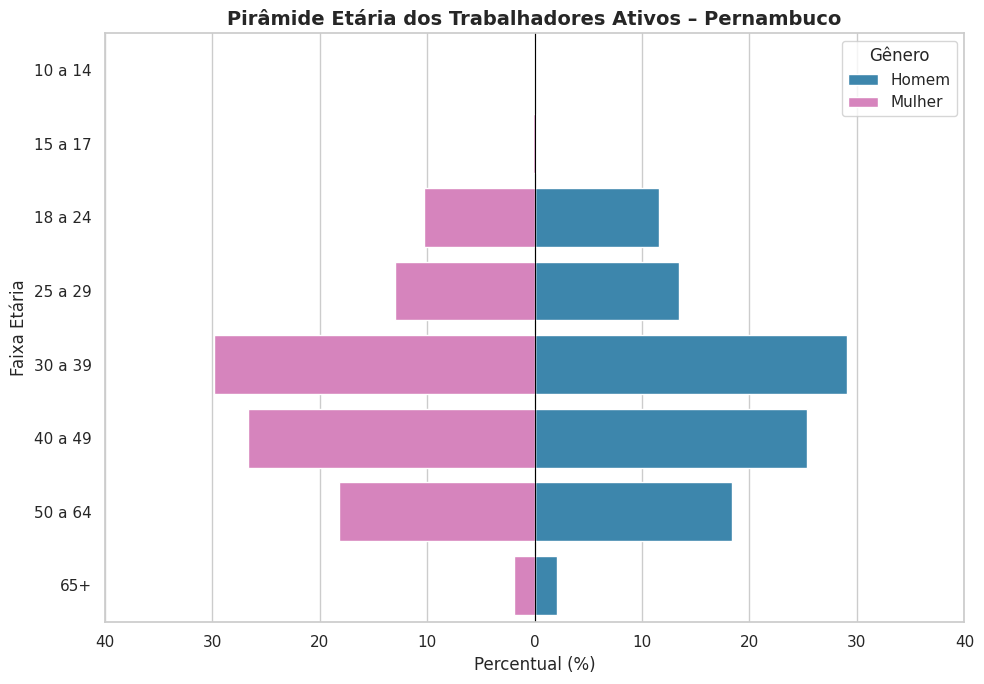

In [38]:
# ============================================================
# PIRÂMIDE ETÁRIA DOS TRABALHADORES ATIVOS – PERNAMBUCO
# ============================================================

import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------------------------------------
# 1) Query RAIS data (with all processing in SQL)
# ----------------------------------------------------------

query = """
WITH latest_year AS (
    SELECT MAX(ano) AS ano
    FROM silver.rais__base_dos_dados__vinculos
),
base AS (
    SELECT
        CASE CAST(faixa_etaria AS VARCHAR)
            WHEN '1' THEN '10 a 14'
            WHEN '2' THEN '15 a 17'
            WHEN '3' THEN '18 a 24'
            WHEN '4' THEN '25 a 29'
            WHEN '5' THEN '30 a 39'
            WHEN '6' THEN '40 a 49'
            WHEN '7' THEN '50 a 64'
            WHEN '8' THEN '65+'
            ELSE NULL
        END AS faixa_etaria_nome,
        CASE CAST(sexo AS VARCHAR)
            WHEN '1' THEN 'Homem'
            WHEN '2' THEN 'Mulher'
            ELSE NULL
        END AS sexo_nome,
        COUNT(*) AS total
    FROM silver.rais__base_dos_dados__vinculos
    WHERE sigla_uf = 'PE'
      AND ano = (SELECT ano FROM latest_year)
      AND CAST(vinculo_ativo_3112 AS VARCHAR) = '1'
    GROUP BY faixa_etaria, sexo
),
percentual AS (
    SELECT
        faixa_etaria_nome,
        sexo_nome,
        total,
        ROUND(
            100.0 * total / SUM(total) OVER (PARTITION BY sexo_nome),
            2
        ) AS percent
    FROM base
)
SELECT
    faixa_etaria_nome,
    sexo_nome,
    total,
    percent
FROM percentual
WHERE faixa_etaria_nome IS NOT NULL AND sexo_nome IS NOT NULL
ORDER BY faixa_etaria_nome,
         CASE sexo_nome WHEN 'Homem' THEN 1 ELSE 2 END
"""

# ----------------------------------------------------------
# 2) Run query and load data
# ----------------------------------------------------------

s3_staging_dir = "s3://observatorio-trabalho-pe-ds-resources-dev/query_results"

rais_age = query_athena_to_polars(
    query=query,
    s3_staging_dir=s3_staging_dir,
    lazy_mode=False
)

# ----------------------------------------------------------
# 3) Prepare data for pyramid plot
# ----------------------------------------------------------

df_age = rais_age.to_pandas()
df_age["percent_plot"] = np.where(df_age["sexo_nome"] == "Mulher", -df_age["percent"], df_age["percent"])

faixas_ordem = ["10 a 14", "15 a 17", "18 a 24", "25 a 29", "30 a 39", "40 a 49", "50 a 64", "65+"]
df_age["faixa_etaria_nome"] = pd.Categorical(df_age["faixa_etaria_nome"], categories=faixas_ordem, ordered=True)
df_age = df_age.sort_values("faixa_etaria_nome")

# ============================================================
# PIRÂMIDE ETÁRIA DOS TRABALHADORES ATIVOS – PERNAMBUCO
# ============================================================

import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------------------------------------
# 1) Query RAIS data (with all processing in SQL)
# ----------------------------------------------------------

query = """
WITH latest_year AS (
    SELECT MAX(ano) AS ano
    FROM silver.rais__base_dos_dados__vinculos
),
base AS (
    SELECT
        CASE CAST(faixa_etaria AS VARCHAR)
            WHEN '1' THEN '10 a 14'
            WHEN '2' THEN '15 a 17'
            WHEN '3' THEN '18 a 24'
            WHEN '4' THEN '25 a 29'
            WHEN '5' THEN '30 a 39'
            WHEN '6' THEN '40 a 49'
            WHEN '7' THEN '50 a 64'
            WHEN '8' THEN '65+'
            ELSE NULL
        END AS faixa_etaria_nome,
        CASE CAST(sexo AS VARCHAR)
            WHEN '1' THEN 'Homem'
            WHEN '2' THEN 'Mulher'
            ELSE NULL
        END AS sexo_nome,
        COUNT(*) AS total
    FROM silver.rais__base_dos_dados__vinculos
    WHERE sigla_uf = 'PE'
      AND ano = (SELECT ano FROM latest_year)
      AND CAST(vinculo_ativo_3112 AS VARCHAR) = '1'
    GROUP BY faixa_etaria, sexo
),
percentual AS (
    SELECT
        faixa_etaria_nome,
        sexo_nome,
        total,
        ROUND(
            100.0 * total / SUM(total) OVER (PARTITION BY sexo_nome),
            2
        ) AS percent
    FROM base
)
SELECT
    faixa_etaria_nome,
    sexo_nome,
    total,
    percent
FROM percentual
WHERE faixa_etaria_nome IS NOT NULL AND sexo_nome IS NOT NULL
ORDER BY faixa_etaria_nome,
         CASE sexo_nome WHEN 'Homem' THEN 1 ELSE 2 END
"""

# ----------------------------------------------------------
# 2) Run query and load data
# ----------------------------------------------------------

s3_staging_dir = "s3://observatorio-trabalho-pe-ds-resources-dev/query_results"

rais_age = query_athena_to_polars(
    query=query,
    s3_staging_dir=s3_staging_dir,
    lazy_mode=False
)

# ----------------------------------------------------------
# 3) Prepare data for pyramid plot
# ----------------------------------------------------------

df_age = rais_age.to_pandas()
df_age["percent_plot"] = np.where(df_age["sexo_nome"] == "Mulher", -df_age["percent"], df_age["percent"])

faixas_ordem = ["10 a 14", "15 a 17", "18 a 24", "25 a 29", "30 a 39", "40 a 49", "50 a 64", "65+"]
df_age["faixa_etaria_nome"] = pd.Categorical(df_age["faixa_etaria_nome"], categories=faixas_ordem, ordered=True)
df_age = df_age.sort_values("faixa_etaria_nome")

# ----------------------------------------------------------
# 4) Plot: Pirâmide Etária (percent labels always positive)
# ----------------------------------------------------------

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 7))
sns.barplot(
    data=df_age,
    y="faixa_etaria_nome",
    x="percent_plot",
    hue="sexo_nome",
    dodge=False,
    palette={"Homem": "#2b8cbe", "Mulher": "#e377c2"}
)

plt.axvline(0, color="black", linewidth=0.8)
plt.title("Pirâmide Etária dos Trabalhadores Ativos – Pernambuco", fontsize=14, weight="bold")
plt.xlabel("Percentual (%)")
plt.ylabel("Faixa Etária")
plt.legend(title="Gênero", loc="upper right")

# --- Make x-axis labels show absolute values (no negatives)
xticks = plt.xticks()[0]
plt.xticks(xticks, [f"{abs(x):.0f}" for x in xticks])

plt.tight_layout()
plt.show()



# Pirâmide Etária dos Trabalhadores Ativos em Pernambuco – Números Absoluto

Como a distribuição etária e de gênero dos vínculos formais se manifesta em números absolutos — e o que muda na leitura em relação à análise anterior em percentuais?

/tmp/ipykernel_4344/2469768306.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels)


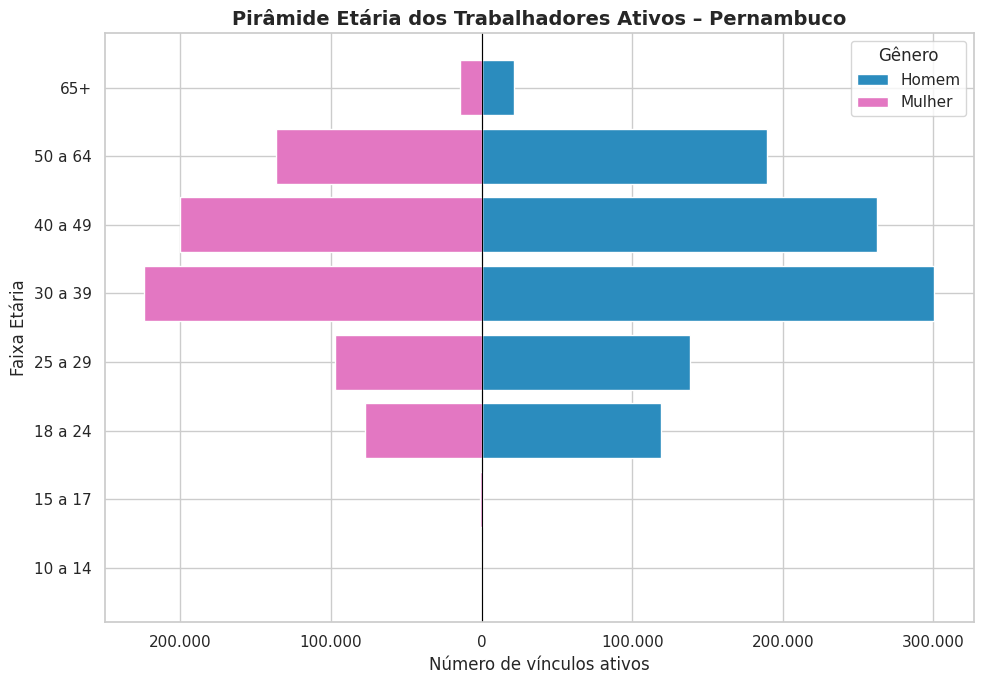

In [43]:
# ============================================================
# PIRÂMIDE ETÁRIA – NÚMERO ABSOLUTO DE VÍNCULOS ATIVOS (PE)
# ============================================================

import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------
# 1) Query RAIS data (processing done in SQL)
# ----------------------------------------------------------

query = """
WITH latest_year AS (
    SELECT MAX(ano) AS ano
    FROM silver.rais__base_dos_dados__vinculos
)
SELECT
    CASE CAST(faixa_etaria AS VARCHAR)
        WHEN '1' THEN '10 a 14'
        WHEN '2' THEN '15 a 17'
        WHEN '3' THEN '18 a 24'
        WHEN '4' THEN '25 a 29'
        WHEN '5' THEN '30 a 39'
        WHEN '6' THEN '40 a 49'
        WHEN '7' THEN '50 a 64'
        WHEN '8' THEN '65+'
    END AS faixa_etaria,
    CASE CAST(sexo AS VARCHAR)
        WHEN '1' THEN 'Homem'
        WHEN '2' THEN 'Mulher'
    END AS sexo_nome,
    COUNT(*) AS count
FROM silver.rais__base_dos_dados__vinculos
WHERE sigla_uf = 'PE'
  AND ano = (SELECT ano FROM latest_year)
  AND CAST(vinculo_ativo_3112 AS VARCHAR) = '1'
  AND CAST(faixa_etaria AS INTEGER) BETWEEN 1 AND 8   
  AND CAST(sexo AS INTEGER) IN (1, 2)               
GROUP BY faixa_etaria, sexo
ORDER BY faixa_etaria, sexo;
"""

s3_staging_dir = "s3://observatorio-trabalho-pe-ds-resources-dev/query_results"

rais_age = query_athena_to_polars(
    query=query,
    s3_staging_dir=s3_staging_dir,
    lazy_mode=False
)

# ----------------------------------------------------------
# 2) Prepare data for plotting
# ----------------------------------------------------------

df_age = rais_age.to_pandas()

# Order age groups
faixas_ordem = ["10 a 14", "15 a 17", "18 a 24", "25 a 29", "30 a 39", "40 a 49", "50 a 64", "65+"]
df_age["faixa_etaria"] = pd.Categorical(df_age["faixa_etaria"], categories=faixas_ordem, ordered=True)
df_age = df_age.sort_values("faixa_etaria")

# Mirror women to the left for symmetry
df_age["count_plot"] = np.where(df_age["sexo_nome"] == "Mulher", -df_age["count"], df_age["count"])

# Convert categorical to string for plotting
df_age["faixa_etaria_str"] = df_age["faixa_etaria"].astype(str)
# Remove NaN faixa_etaria before plotting
df_age_clean = df_age.dropna(subset=["faixa_etaria_str"])

# Plot again
fig, ax = plt.subplots(figsize=(10, 7))

# Men (right side)
ax.barh(
    df_age_clean[df_age_clean["sexo_nome"] == "Homem"]["faixa_etaria_str"],
    df_age_clean[df_age_clean["sexo_nome"] == "Homem"]["count"],
    color="#2b8cbe",
    label="Homem"
)

# Women (left side)
ax.barh(
    df_age_clean[df_age_clean["sexo_nome"] == "Mulher"]["faixa_etaria_str"],
    df_age_clean[df_age_clean["sexo_nome"] == "Mulher"]["count_plot"],
    color="#e377c2",
    label="Mulher"
)

ax.axvline(0, color="black", linewidth=0.8)
ax.set_xlabel("Número de vínculos ativos")
ax.set_ylabel("Faixa Etária")
ax.set_title("Pirâmide Etária dos Trabalhadores Ativos – Pernambuco", fontsize=14, weight="bold")
ax.legend(title="Gênero", loc="upper right")

# Format x-axis labels to show absolute values
xlabels = [f"{abs(int(x)):,}".replace(",", ".") for x in ax.get_xticks()]
ax.set_xticklabels(xlabels)

plt.tight_layout()
plt.show()


# Distribuição da Escolaridade dos Trabalhadores Ativos – Pernambuco

Qual é o nível de escolaridade predominante entre os trabalhadores formais de Pernambuco e o que essa estrutura revela sobre a qualificação da força de trabalho no estado

/tmp/ipykernel_4344/3752827647.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_4344/3752827647.py:68: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.barplot(


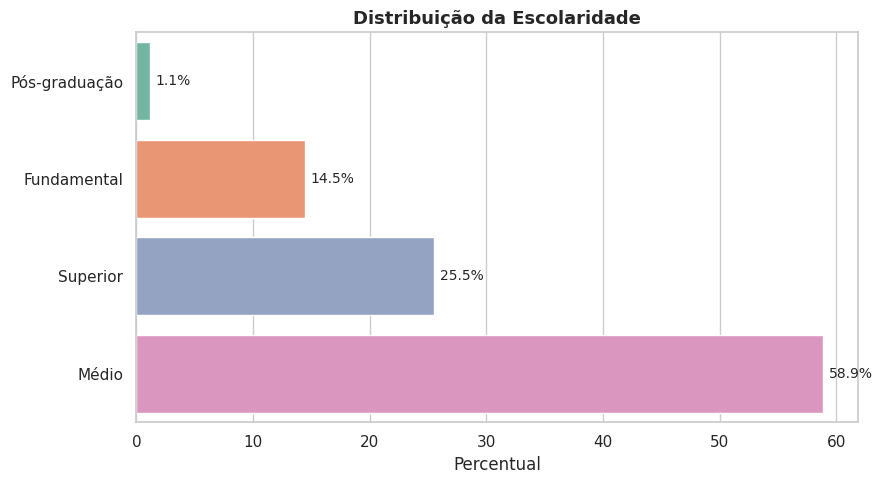

In [44]:
# -----------------------------
# 1) Query: escolaridade
# -----------------------------
query_educ = """
WITH latest_year AS (
    SELECT MAX(ano) AS ano FROM silver.rais__base_dos_dados__vinculos
)
SELECT
    grau_instrucao_apos_2005,
    COUNT(*) AS total
FROM silver.rais__base_dos_dados__vinculos
WHERE sigla_uf = 'PE'
  AND ano = (SELECT ano FROM latest_year)
  AND CAST(vinculo_ativo_3112 AS VARCHAR) = '1'
  AND grau_instrucao_apos_2005 IS NOT NULL
GROUP BY grau_instrucao_apos_2005
"""

rais_educ = query_athena_to_polars(
    query=query_educ,
    s3_staging_dir=s3_staging_dir,
    lazy_mode=False
)

# -----------------------------
# 2) Prepare DataFrame
# -----------------------------
educ_map = {
    # Fundamental
    "1": "Fundamental",   # Analfabeto
    "2": "Fundamental",   # Até 5ª Incompleto
    "3": "Fundamental",   # 5ª a Completo
    "4": "Fundamental",   # 6ª a 9ª
    "5": "Fundamental",   # Fundamental Completo

    # Médio
    "6": "Médio",         # Médio Incompleto
    "7": "Médio",         # Médio Completo

    # Superior
    "8": "Superior",      # Superior Incompleto
    "9": "Superior",      # Superior Completo

    # Pós-graduação
    "10": "Pós-graduação",  # Mestrado
    "11": "Pós-graduação",  # Doutorado

    # Ignored / Unknown
    "-1": None,
    "99": None
}

df_educ = (
    rais_educ
    .with_columns(pl.col("grau_instrucao_apos_2005").cast(pl.Utf8))
    .to_pandas()
)

df_educ["educ"] = df_educ["grau_instrucao_apos_2005"].map(educ_map)
df_educ = df_educ.groupby("educ", as_index=False)["total"].sum()
df_educ["percent"] = df_educ["total"] / df_educ["total"].sum() * 100
df_educ = df_educ.sort_values("percent", ascending=True)

# -----------------------------
# 3) Plot: Escolaridade
# -----------------------------
plt.figure(figsize=(9, 5))
sns.barplot(
    data=df_educ,
    x="percent",
    y="educ",
    palette=["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854"]
)

for i, (p, val) in enumerate(zip(df_educ["percent"], df_educ["educ"])):
    plt.text(p + 0.5, i, f"{p:.1f}%", va="center", fontsize=10)

plt.title("Distribuição da Escolaridade", fontsize=13, weight="bold")
plt.xlabel("Percentual")
plt.ylabel("")
plt.tight_layout()
plt.show()


# Evolução do Salário de Admissão por Idade e Gênero — Pernambuco
Como a remuneração média dos trabalhadores recém-admitidos evolui ao longo das idades e quais diferenças se observam entre homens e mulheres na trajetória salarial?


/tmp/ipykernel_4344/2198250201.py:44: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


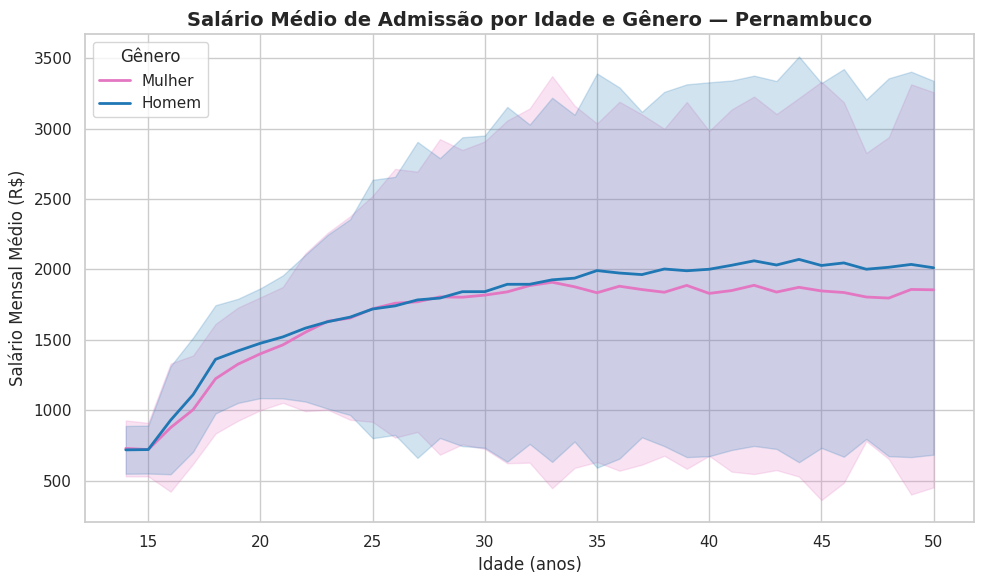

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. Query CAGED data — Age vs Salary by Gender
# ------------------------------------------------------------
query = """
WITH latest_year AS (
    SELECT MAX(ano) AS ano
    FROM silver.caged__base_dos_dados__novo
)
SELECT 
    CAST(idade AS INTEGER) AS idade,
    CAST(salario_mensal AS DOUBLE) AS salario_mensal,
    CASE 
        WHEN CAST(sexo AS INTEGER) = 1 THEN 'Homem'
        WHEN CAST(sexo AS INTEGER) = 3 THEN 'Mulher'
        ELSE 'Ignorado'
    END AS sexo
FROM silver.caged__base_dos_dados__novo
WHERE sigla_uf = 'PE'
  AND CAST(ano AS INTEGER) = (SELECT ano FROM latest_year)
  AND CAST(saldo_movimentacao AS INTEGER) = 1   -- only admissions
  AND salario_mensal BETWEEN 500 AND 30000
  AND idade BETWEEN 14 AND 50
  AND CAST(sexo AS INTEGER) IN (1, 3);
"""

s3_staging_dir = "s3://observatorio-trabalho-pe-ds-resources-dev/query_results"

df_age_salary = query_athena_to_polars(
    query=query,                      # ✅ use correct variable
    s3_staging_dir=s3_staging_dir,
    lazy_mode=False
)

# Convert to pandas for seaborn
df_age_salary = df_age_salary.to_pandas()

# ------------------------------------------------------------
# 2. Plot: Salary vs Age by Gender
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_age_salary,
    x="idade",
    y="salario_mensal",
    hue="sexo",
    estimator="mean",
    ci="sd",
    lw=2,
    palette={"Mulher": "#e377c2", "Homem": "#1f77b4"}
)

plt.title("Salário Médio de Admissão por Idade e Gênero — Pernambuco", fontsize=14, weight="bold")
plt.xlabel("Idade (anos)")
plt.ylabel("Salário Mensal Médio (R$)")
plt.legend(title="Gênero")
plt.tight_layout()
plt.show()


# Evolução do Salário de Admissão por Idade e Gênero — Pernambuco. Plot sem variancia

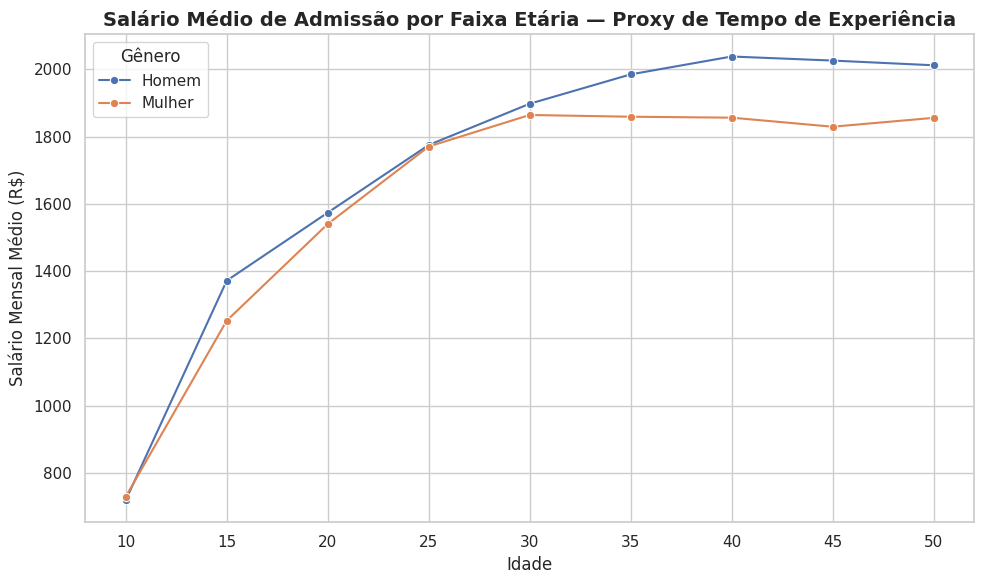

In [51]:
query = """WITH latest_year AS (
    SELECT MAX(ano) AS ano 
    FROM silver.caged__base_dos_dados__novo
),
base AS (
    SELECT 
        CAST(idade AS INTEGER) AS idade,
        CAST(salario_mensal AS DOUBLE) AS salario_mensal,
        CASE 
            WHEN CAST(sexo AS INTEGER) = 1 THEN 'Homem'
            WHEN CAST(sexo AS INTEGER) = 3 THEN 'Mulher'
        END AS sexo
    FROM silver.caged__base_dos_dados__novo
    WHERE sigla_uf = 'PE'
      AND CAST(ano AS INTEGER) = (SELECT ano FROM latest_year)
      AND CAST(saldo_movimentacao AS INTEGER) = 1  -- admissions only
      AND CAST(sexo AS INTEGER) IN (1, 3)          -- only men & women
      AND salario_mensal BETWEEN 500 AND 30000
      AND idade BETWEEN 14 AND 50
)
SELECT
    sexo,
    FLOOR(idade / 5) * 5 AS idade_faixa,
    AVG(salario_mensal) AS salario_medio
FROM base
GROUP BY 1, 2
ORDER BY 1, 2;

"""
# --- 1. Query data ---
df_salary_tenure = query_athena_to_polars(query=query, s3_staging_dir=s3_staging_dir, lazy_mode=False).to_pandas()

# --- 2. Plot ---
plt.figure(figsize=(10,6))
sns.lineplot(
    data=df_salary_tenure, 
    x="idade_faixa", 
    y="salario_medio", 
    hue="sexo",
    marker="o"
)

plt.title("Salário Médio de Admissão por Faixa Etária — Proxy de Tempo de Experiência", fontsize=14, weight="bold")
plt.xlabel("Idade")
plt.ylabel("Salário Mensal Médio (R$)")
plt.legend(title="Gênero")
plt.tight_layout()
plt.show()


# Remuneração Média por Idade e Gênero — Pernambuco

Como a remuneração mensal evolui ao longo da idade para homens e mulheres, e em que momentos da carreira as trajetórias salariais se aproximam ou divergem


/tmp/ipykernel_4344/3075173711.py:42: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


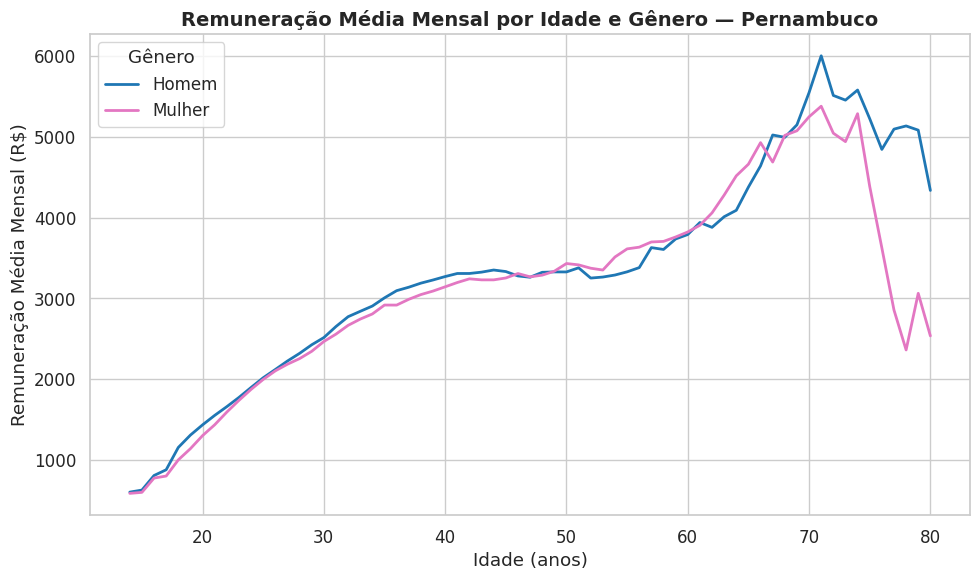

In [54]:
query = """
WITH latest_year AS (
    SELECT MAX(TRY_CAST(ano AS INTEGER)) AS ano 
    FROM silver.rais__base_dos_dados__vinculos
)
SELECT
    TRY_CAST(idade AS INTEGER) AS idade,
    CASE 
        WHEN TRY_CAST(sexo AS INTEGER) = 1 THEN 'Homem'
        WHEN TRY_CAST(sexo AS INTEGER) = 2 THEN 'Mulher'
        ELSE 'Ignorado'
    END AS sexo,
    AVG(TRY_CAST(valor_remuneracao_media AS DOUBLE)) AS salario_medio
FROM silver.rais__base_dos_dados__vinculos
WHERE sigla_uf = 'PE'
  AND TRY_CAST(ano AS INTEGER) = (SELECT ano FROM latest_year)
  AND TRY_CAST(vinculo_ativo_3112 AS INTEGER) = 1              -- only active links
  AND TRY_CAST(valor_remuneracao_media AS DOUBLE) BETWEEN 500 AND 30000
  AND TRY_CAST(idade AS INTEGER) BETWEEN 14 AND 80
GROUP BY 1, 2
ORDER BY 1, 2;

"""
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Query execution ---
s3_staging_dir = "s3://observatorio-trabalho-pe-ds-resources-dev/query_results"
df_gender_salary = query_athena_to_polars(
    query=query,
    s3_staging_dir=s3_staging_dir,
    lazy_mode=False
).to_pandas()

# --- Data cleaning ---
df_gender_salary = df_gender_salary[df_gender_salary["sexo"].isin(["Homem", "Mulher"])]

# --- Plot ---
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10,6))
sns.lineplot(
    data=df_gender_salary,
    x="idade",
    y="salario_medio",
    hue="sexo",
    estimator="mean",
    ci="sd",
    lw=2,
    palette={"Mulher": "#e377c2", "Homem": "#1f77b4"}  # pink & blue
)
plt.title("Remuneração Média Mensal por Idade e Gênero — Pernambuco", fontsize=14, weight="bold")
plt.xlabel("Idade (anos)")
plt.ylabel("Remuneração Média Mensal (R$)")
plt.legend(title="Gênero")
plt.tight_layout()
plt.show()



# Salário Médio por Idade e Escolaridade — Pernambuco

De que forma o nível de escolaridade influencia a trajetória salarial ao longo da vida, e em quais idades as diferenças entre níveis de formação se tornam mais acentuadas

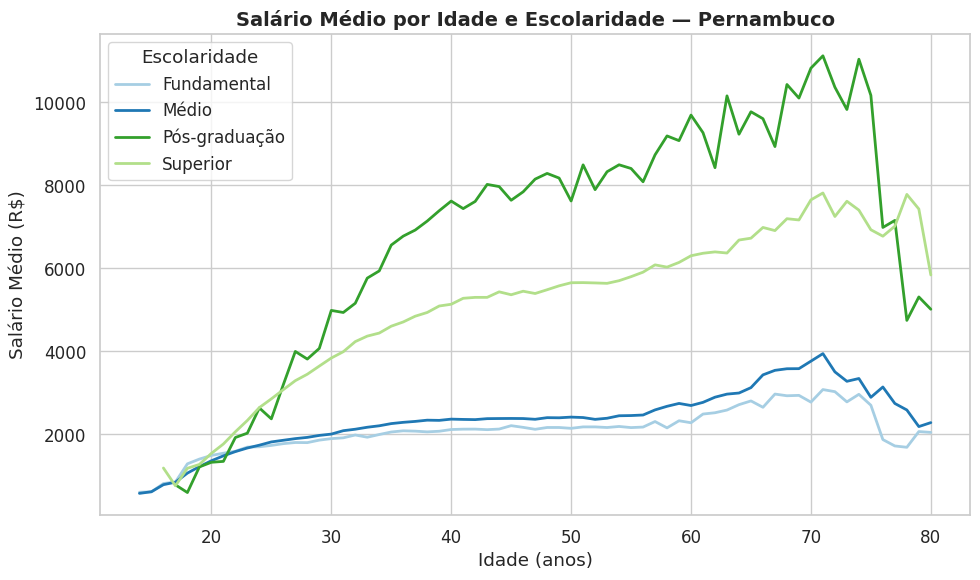

In [57]:
query = """
WITH latest_year AS (
    SELECT MAX(TRY_CAST(ano AS INTEGER)) AS ano 
    FROM silver.rais__base_dos_dados__vinculos
)
SELECT
    TRY_CAST(idade AS INTEGER) AS idade,
    CASE 
        WHEN TRY_CAST(grau_instrucao_apos_2005 AS INTEGER) IN (1, 2, 3, 4, 5) THEN 'Fundamental'
        WHEN TRY_CAST(grau_instrucao_apos_2005 AS INTEGER) IN (6, 7) THEN 'Médio'
        WHEN TRY_CAST(grau_instrucao_apos_2005 AS INTEGER) IN (8, 9) THEN 'Superior'
        WHEN TRY_CAST(grau_instrucao_apos_2005 AS INTEGER) IN (10, 11) THEN 'Pós-graduação'
        ELSE NULL
    END AS escolaridade,
    AVG(TRY_CAST(valor_remuneracao_media AS DOUBLE)) AS salario_medio
FROM silver.rais__base_dos_dados__vinculos
WHERE sigla_uf = 'PE'
  AND TRY_CAST(ano AS INTEGER) = (SELECT ano FROM latest_year)
  AND TRY_CAST(vinculo_ativo_3112 AS INTEGER) = 1
  AND TRY_CAST(valor_remuneracao_media AS DOUBLE) BETWEEN 500 AND 30000
  AND TRY_CAST(idade AS INTEGER) BETWEEN 14 AND 80
  AND TRY_CAST(grau_instrucao_apos_2005 AS INTEGER) NOT IN (-1, 99)
GROUP BY 1, 2
ORDER BY 2, 1;

"""
import seaborn as sns
import matplotlib.pyplot as plt

# --- Query execution ---
s3_staging_dir = "s3://observatorio-trabalho-pe-ds-resources-dev/query_results"
df_educ_salary = query_athena_to_polars(
    query=query,
    s3_staging_dir=s3_staging_dir,
    lazy_mode=False
).to_pandas()

# --- Visualization ---
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10, 6))

palette = {
    "Fundamental": "#a6cee3",
    "Médio": "#1f78b4",
    "Superior": "#b2df8a",
    "Pós-graduação": "#33a02c"
}

sns.lineplot(
    data=df_educ_salary,
    x="idade",
    y="salario_medio",
    hue="escolaridade",
    lw=2,
    palette=palette
)

plt.title("Salário Médio por Idade e Escolaridade — Pernambuco", fontsize=14, weight="bold")
plt.xlabel("Idade (anos)")
plt.ylabel("Salário Médio (R$)")
plt.legend(title="Escolaridade")
plt.tight_layout()
plt.show()


# Evolução Salarial por Ocupação e Idade — Pernambuco

Como as trajetórias salariais variam entre diferentes grupos ocupacionais ao longo da vida profissional, e quais ocupações apresentam maior valorização com o avanço da idade?

In [61]:
cbo_mapping = {
    1: "Diretores e gestores",
    2: "Profissionais científicos e intelectuais",
    3: "Técnicos de nível médio",
    4: "Trabalhadores administrativos",
    5: "Trabalhadores dos serviços e comércio",
    6: "Trabalhadores agrícolas e florestais",
    7: "Trabalhadores da produção industrial",
    8: "Operadores de máquinas e montagem",
    9: "Trabalhadores elementares"
}


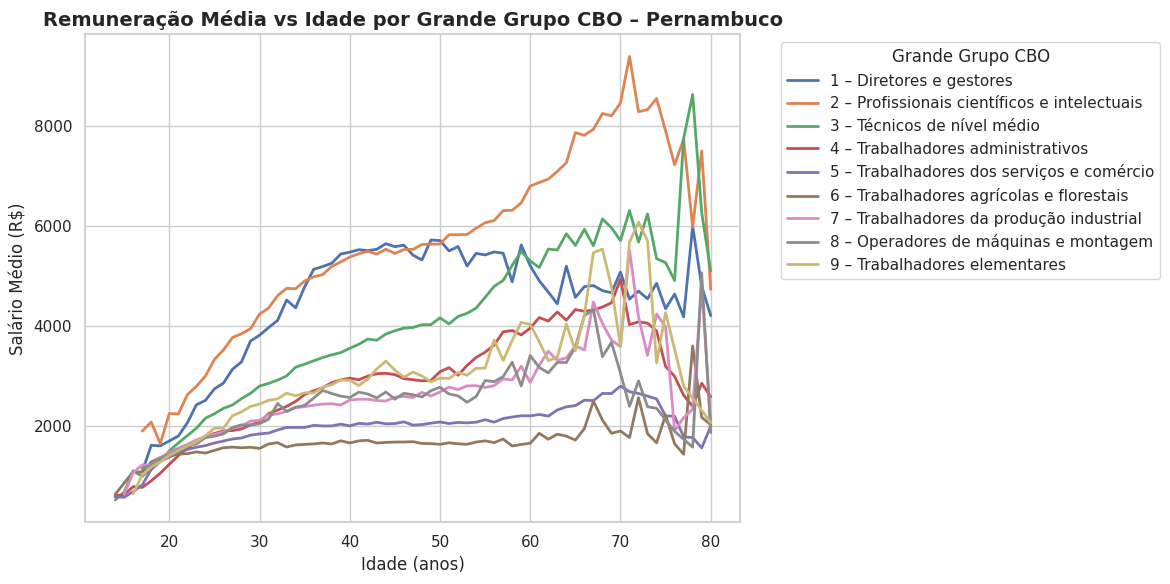

In [60]:
query = """
WITH latest_year AS (
    SELECT MAX(TRY_CAST(ano AS INTEGER)) AS ano
    FROM silver.rais__base_dos_dados__vinculos
)
SELECT
    TRY_CAST(idade AS INTEGER) AS idade,
    CASE
        WHEN SUBSTRING(CAST(cbo_2002 AS VARCHAR), 1, 1) = '1' THEN '1 – Diretores e gestores'
        WHEN SUBSTRING(CAST(cbo_2002 AS VARCHAR), 1, 1) = '2' THEN '2 – Profissionais científicos e intelectuais'
        WHEN SUBSTRING(CAST(cbo_2002 AS VARCHAR), 1, 1) = '3' THEN '3 – Técnicos de nível médio'
        WHEN SUBSTRING(CAST(cbo_2002 AS VARCHAR), 1, 1) = '4' THEN '4 – Trabalhadores administrativos'
        WHEN SUBSTRING(CAST(cbo_2002 AS VARCHAR), 1, 1) = '5' THEN '5 – Trabalhadores dos serviços e comércio'
        WHEN SUBSTRING(CAST(cbo_2002 AS VARCHAR), 1, 1) = '6' THEN '6 – Trabalhadores agrícolas e florestais'
        WHEN SUBSTRING(CAST(cbo_2002 AS VARCHAR), 1, 1) = '7' THEN '7 – Trabalhadores da produção industrial'
        WHEN SUBSTRING(CAST(cbo_2002 AS VARCHAR), 1, 1) = '8' THEN '8 – Operadores de máquinas e montagem'
        WHEN SUBSTRING(CAST(cbo_2002 AS VARCHAR), 1, 1) = '9' THEN '9 – Trabalhadores elementares'
    END AS cbo_grande_grupo,
    AVG(TRY_CAST(valor_remuneracao_media AS DOUBLE)) AS salario_medio
FROM silver.rais__base_dos_dados__vinculos
WHERE sigla_uf = 'PE'
  AND TRY_CAST(ano AS INTEGER) = (SELECT ano FROM latest_year)
  AND TRY_CAST(vinculo_ativo_3112 AS INTEGER) = 1
  AND TRY_CAST(valor_remuneracao_media AS DOUBLE) BETWEEN 500 AND 30000
  AND TRY_CAST(idade AS INTEGER) BETWEEN 14 AND 80
  AND SUBSTRING(CAST(cbo_2002 AS VARCHAR), 1, 1) BETWEEN '1' AND '9'
GROUP BY 1, 2
ORDER BY 2, 1;

"""


import seaborn as sns
import matplotlib.pyplot as plt

# Run query
s3_staging_dir = "s3://observatorio-trabalho-pe-ds-resources-dev/query_results"
df_cbo_salary = query_athena_to_polars(query=query, s3_staging_dir=s3_staging_dir, lazy_mode=False).to_pandas()

# Filter just real groups (exclude “Outros” if needed)
df_cbo_salary = df_cbo_salary[df_cbo_salary["cbo_grande_grupo"] != "Outros"]

sns.set_theme(style="whitegrid", font_scale=1)
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_cbo_salary,
    x="idade",
    y="salario_medio",
    hue="cbo_grande_grupo",
    lw=2,
)
plt.title("Remuneração Média vs Idade por Grande Grupo CBO – Pernambuco", fontsize=14, weight="bold")
plt.xlabel("Idade (anos)")
plt.ylabel("Salário Médio (R$)")
plt.legend(title="Grande Grupo CBO", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


# Relação entre Horas Trabalhadas e Remuneração — Pernambuco

Como a remuneração média mensal varia conforme a carga horária contratual, e há diferenças significativas entre homens e mulheres em diferentes jornadas de trabalho?

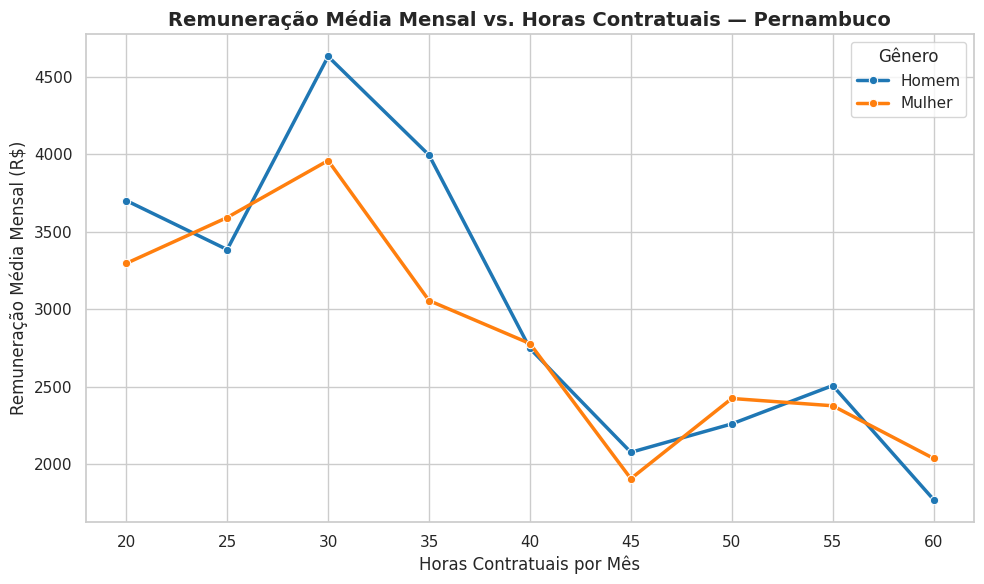

In [64]:
query = """
WITH latest_year AS (
    SELECT MAX(TRY_CAST(ano AS INTEGER)) AS ano
    FROM silver.rais__base_dos_dados__vinculos
)
SELECT
    ROUND(AVG(TRY_CAST(valor_remuneracao_media AS DOUBLE)), 2) AS salario_medio,
    FLOOR(TRY_CAST(quantidade_horas_contratadas AS DOUBLE) / 5) * 5 AS horas_faixa,
    CASE 
        WHEN TRY_CAST(sexo AS INTEGER) = 1 THEN 'Homem'
        WHEN TRY_CAST(sexo AS INTEGER) = 2 THEN 'Mulher'
        ELSE 'Ignorado'
    END AS sexo
FROM silver.rais__base_dos_dados__vinculos
WHERE sigla_uf = 'PE'
  AND TRY_CAST(ano AS INTEGER) = (SELECT ano FROM latest_year)
  AND TRY_CAST(vinculo_ativo_3112 AS INTEGER) = 1
  AND TRY_CAST(valor_remuneracao_media AS DOUBLE) BETWEEN 500 AND 30000
  AND TRY_CAST(quantidade_horas_contratadas AS DOUBLE) BETWEEN 20 AND 260
  AND TRY_CAST(sexo AS INTEGER) IN (1, 2)
  AND TRY_CAST(indicador_trabalho_parcial AS INTEGER) = 0
  AND TRY_CAST(indicador_trabalho_intermitente AS INTEGER) = 0
GROUP BY 3, FLOOR(TRY_CAST(quantidade_horas_contratadas AS DOUBLE) / 5) * 5
ORDER BY horas_faixa, sexo;


"""

df_hours_salary_mean = query_athena_to_polars(
    query=query,
    s3_staging_dir="s3://observatorio-trabalho-pe-ds-resources-dev/query_results",
    lazy_mode=False
).to_pandas()

plt.figure(figsize=(10,6))
sns.lineplot(
    data=df_hours_salary_mean,
    x="horas_faixa",
    y="salario_medio",
    hue="sexo",
    lw=2.5,
    marker="o",
    markersize=6,
    palette={"Homem": "#1f77b4", "Mulher": "#ff7f0e"}
)

plt.title("Remuneração Média Mensal vs. Horas Contratuais — Pernambuco", fontsize=14, weight="bold")
plt.xlabel("Horas Contratuais por Mês")
plt.ylabel("Remuneração Média Mensal (R$)")
plt.legend(title="Gênero")
plt.tight_layout()
plt.show()

# Crescimento Salarial com o Tempo de Emprego — Pernambuco

Como o tempo de permanência no emprego influencia a remuneração média mensal, e em que medida essa relação difere entre homens e mulheres?

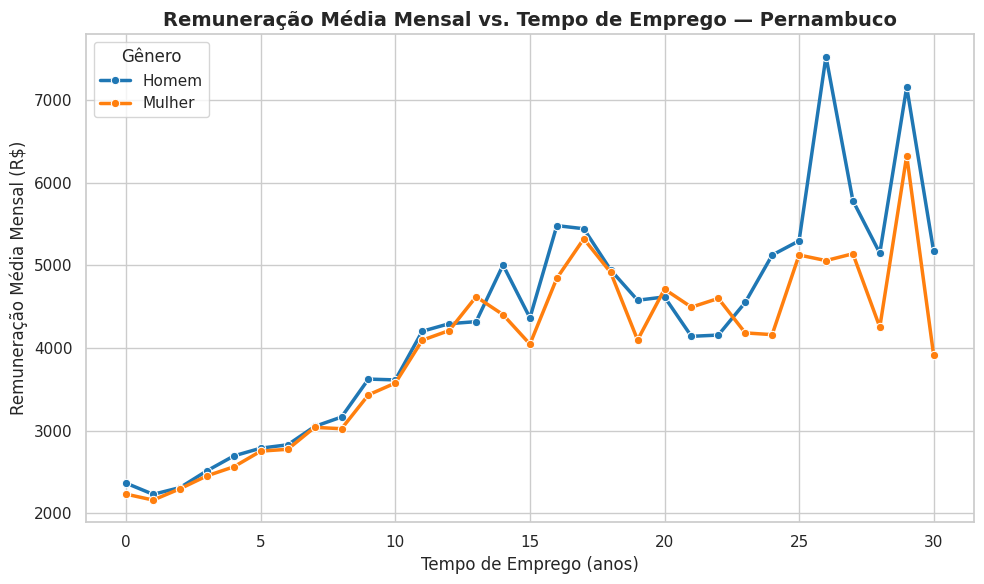

In [68]:
query = """ 
WITH latest_year AS (
    SELECT MAX(TRY_CAST(ano AS INTEGER)) AS ano
    FROM silver.rais__base_dos_dados__vinculos
)
SELECT
    FLOOR(TRY_CAST(tempo_emprego AS DOUBLE) / 12) AS tempo_emprego_anos,
    CASE 
        WHEN TRY_CAST(sexo AS INTEGER) = 1 THEN 'Homem'
        WHEN TRY_CAST(sexo AS INTEGER) = 2 THEN 'Mulher'
        ELSE 'Ignorado'
    END AS sexo,
    ROUND(AVG(TRY_CAST(valor_remuneracao_media AS DOUBLE)), 2) AS salario_medio
FROM silver.rais__base_dos_dados__vinculos
WHERE sigla_uf = 'PE'
  AND TRY_CAST(ano AS INTEGER) = (SELECT ano FROM latest_year)
  AND TRY_CAST(vinculo_ativo_3112 AS INTEGER) = 1
  AND TRY_CAST(valor_remuneracao_media AS DOUBLE) BETWEEN 500 AND 30000
  AND TRY_CAST(tempo_emprego AS DOUBLE) BETWEEN 0 AND 360  -- até 30 anos
  AND TRY_CAST(sexo AS INTEGER) IN (1, 2)
GROUP BY 1, 2
ORDER BY tempo_emprego_anos, sexo;
"""

s3_staging_dir = "s3://observatorio-trabalho-pe-ds-resources-dev/query_results"

df_tenure_salary_mean = (
    query_athena_to_polars(
        query=query,
        s3_staging_dir=s3_staging_dir,
        lazy_mode=False
    )
    .to_pandas()
)

plt.figure(figsize=(10,6))
sns.lineplot(
    data=df_tenure_salary_mean,
    x="tempo_emprego_anos",
    y="salario_medio",
    hue="sexo",
    lw=2.5,
    marker="o",
    palette={"Homem": "#1f77b4", "Mulher": "#ff7f0e"}
)

plt.title("Remuneração Média Mensal vs. Tempo de Emprego — Pernambuco", fontsize=14, weight="bold")
plt.xlabel("Tempo de Emprego (anos)")
plt.ylabel("Remuneração Média Mensal (R$)")
plt.legend(title="Gênero")
plt.tight_layout()
plt.show()


# Tempo Médio de Emprego Aumenta com a Idade — Pernambuco

Como o tempo médio de permanência no emprego evolui conforme a idade, e o que explica o fato de mulheres manterem vínculos mais longos nas faixas etárias mais altas?

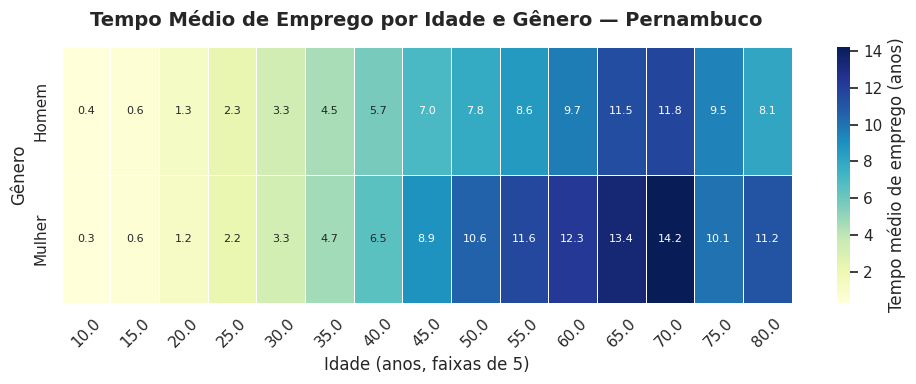

In [71]:
# --- Query ---
query = """
WITH latest_year AS (
    SELECT MAX(TRY_CAST(ano AS INTEGER)) AS ano
    FROM silver.rais__base_dos_dados__vinculos
)
SELECT
    TRY_CAST(idade AS DOUBLE) AS idade,
    TRY_CAST(tempo_emprego AS DOUBLE) / 12 AS tempo_emprego_anos,  -- convert to years
    CASE 
        WHEN TRY_CAST(sexo AS INTEGER) = 1 THEN 'Homem'
        WHEN TRY_CAST(sexo AS INTEGER) = 2 THEN 'Mulher'
        ELSE 'Ignorado'
    END AS sexo
FROM silver.rais__base_dos_dados__vinculos
WHERE sigla_uf = 'PE'
  AND TRY_CAST(ano AS INTEGER) = (SELECT ano FROM latest_year)
  AND TRY_CAST(vinculo_ativo_3112 AS INTEGER) = 1
  AND TRY_CAST(valor_remuneracao_media AS DOUBLE) BETWEEN 500 AND 30000
  AND TRY_CAST(tempo_emprego AS DOUBLE) BETWEEN 0 AND 360
  AND TRY_CAST(idade AS DOUBLE) BETWEEN 14 AND 80
  AND TRY_CAST(sexo AS INTEGER) IN (1, 2);

"""

# --- Query execution ---
s3_staging_dir = "s3://observatorio-trabalho-pe-ds-resources-dev/query_results"
df_stability = (
    query_athena_to_polars(
        query=query,
        s3_staging_dir=s3_staging_dir,
        lazy_mode=False
    )
    .to_pandas()
)

# --- Sample for plotting ---
df_stability_sample = df_stability.sample(frac=0.05, random_state=42)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Aggregate into 5-year age bins ---
df_heat = (
    df_stability
    .assign(idade_bin=lambda x: (x["idade"] // 5) * 5)
    .groupby(["idade_bin", "sexo"], as_index=False)["tempo_emprego_anos"]
    .mean()
)

# Pivot for heatmap
heat_pivot = df_heat.pivot(index="sexo", columns="idade_bin", values="tempo_emprego_anos")

# --- Plot ---
plt.figure(figsize=(10, 4))
sns.heatmap(
    heat_pivot,
    cmap="YlGnBu",       # nicer gradient
    annot=True,
    fmt=".1f",
    linewidths=0.5,
    cbar_kws={"label": "Tempo médio de emprego (anos)"},
    annot_kws={"fontsize":8},
)

plt.title("Tempo Médio de Emprego por Idade e Gênero — Pernambuco", fontsize=14, weight="bold", pad=15)
plt.xlabel("Idade (anos, faixas de 5)")
plt.ylabel("Gênero")

# Rotate tick labels for readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# Trabalhadores Formais Mantêm Rendimento Superior em Todas as Idades — PNADC

Como a diferença de rendimento entre o trabalho formal e informal evolui ao longo da vida, e por que o ganho dos trabalhadores formais se estabiliza enquanto o dos informais tende a cair após certa idade?

/tmp/ipykernel_4344/3386149108.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["rendimento"] * g["peso"]).sum() / g["peso"].sum())


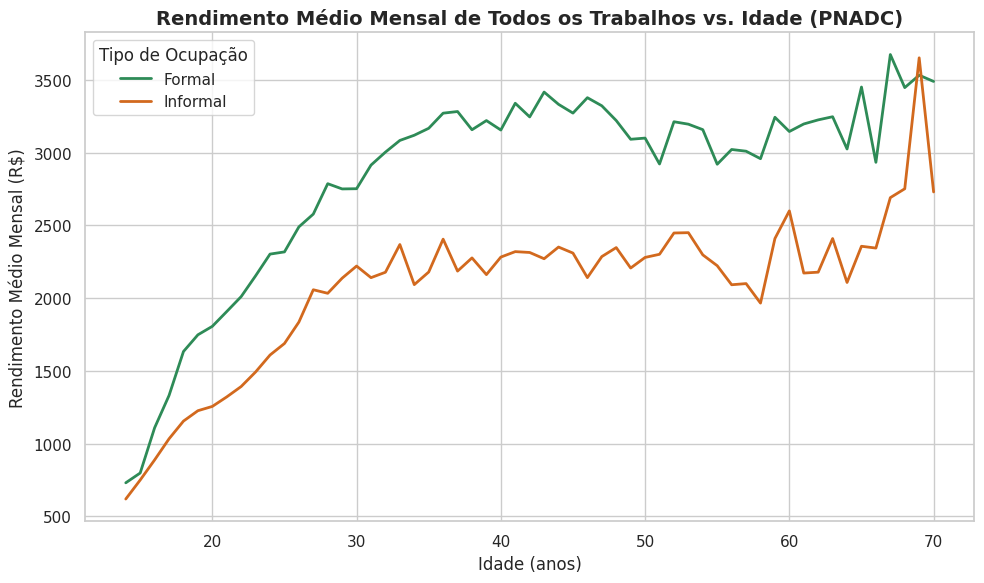

In [74]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

# --- Athena Query ---
query = """
WITH base AS (
  SELECT
    TRY_CAST(ano     AS INTEGER) AS ano,
    TRY_CAST(VD4008  AS INTEGER) AS ocupado,          -- 1 = ocupado
    TRY_CAST(VD4009  AS INTEGER) AS posoc,            -- posição na ocupação
    TRY_CAST(V4029   AS INTEGER) AS carteira,         -- 1 sim, 2 não (apenas empregados)
    TRY_CAST(V4028   AS INTEGER) AS estatutario,      -- 1 sim, 2 não (setor público)
    TRY_CAST(V4019   AS INTEGER) AS cnpj,             -- 1 sim, 2 não (para 8 e 9)
    TRY_CAST(V1033   AS DOUBLE)  AS peso,             -- fator de expansão
    TRY_CAST(V2009   AS DOUBLE)  AS idade,
    TRY_CAST(VD4016  AS DOUBLE)  AS rendimento
  FROM bronze.ibge__pnadctri
),
latest_year AS (
  SELECT MAX(ano) AS ano FROM base
)
SELECT
  idade,
  rendimento,
  peso,
  CASE
    -- empregados privados/domésticos com carteira
    WHEN posoc IN (1,3) AND carteira = 1 THEN 'Formal'
    -- empregados privados/domésticos sem carteira
    WHEN posoc IN (2,4) THEN 'Informal'

    -- setor público: estatutário OU carteira
    WHEN posoc IN (5,6) AND (estatutario = 1 OR carteira = 1) THEN 'Formal'
    WHEN posoc IN (5,6) THEN 'Informal'

    -- militar/estatutário
    WHEN posoc = 7 THEN 'Formal'

    -- empregador e conta própria: usa CNPJ
    WHEN posoc IN (8,9) AND cnpj = 1 THEN 'Formal'
    WHEN posoc IN (8,9) AND cnpj = 2 THEN 'Informal'

    -- familiar auxiliar
    WHEN posoc = 10 THEN 'Informal'
    ELSE NULL
  END AS formalidade
FROM base
WHERE ano = (SELECT ano FROM latest_year)
  AND ocupado = 1
  AND idade BETWEEN 14 AND 70
  AND rendimento > 0
  AND posoc IS NOT NULL;


"""

# --- Load with your Athena helper ---
s3_staging_dir = "s3://observatorio-trabalho-pe-ds-resources-dev/query_results"
df = query_athena_to_polars(query=query, s3_staging_dir=s3_staging_dir, lazy_mode=False).to_pandas()

# --- Clean & aggregate ---
df = df.dropna(subset=["idade", "rendimento", "formalidade"])
df = df[df["rendimento"] < 50000]

# Weighted average rendimento by age and formalidade
agg = (
    df.groupby(["idade", "formalidade"], as_index=False)
    .apply(lambda g: (g["rendimento"] * g["peso"]).sum() / g["peso"].sum())
    .reset_index()
)
agg.columns = ["idx", "idade", "formalidade", "renda_media"]

# --- Plot ---
plt.figure(figsize=(10,6))
sns.lineplot(
    data=agg,
    x="idade",
    y="renda_media",
    hue="formalidade",
    lw=2,
    palette={"Formal": "#2E8B57", "Informal": "#D2691E"}
)
plt.title("Rendimento Médio Mensal de Todos os Trabalhos vs. Idade (PNADC)", fontsize=14, weight="bold")
plt.xlabel("Idade (anos)")
plt.ylabel("Rendimento Médio Mensal (R$)")
plt.legend(title="Tipo de Ocupação")
plt.tight_layout()
plt.show()


# Mais Horas Trabalhadas Nem Sempre Significam Maior Rendimento — PNAD

Como o aumento da carga horária semanal impacta o rendimento médio mensal, e por que a diferença entre trabalhadores formais e informais persiste mesmo em jornadas semelhantes

/tmp/ipykernel_4344/3729024976.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["rendimento"] * g["peso"]).sum() / g["peso"].sum())
/tmp/ipykernel_4344/3729024976.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["rendimento"] * g["peso"]).sum() / g["peso"].sum())


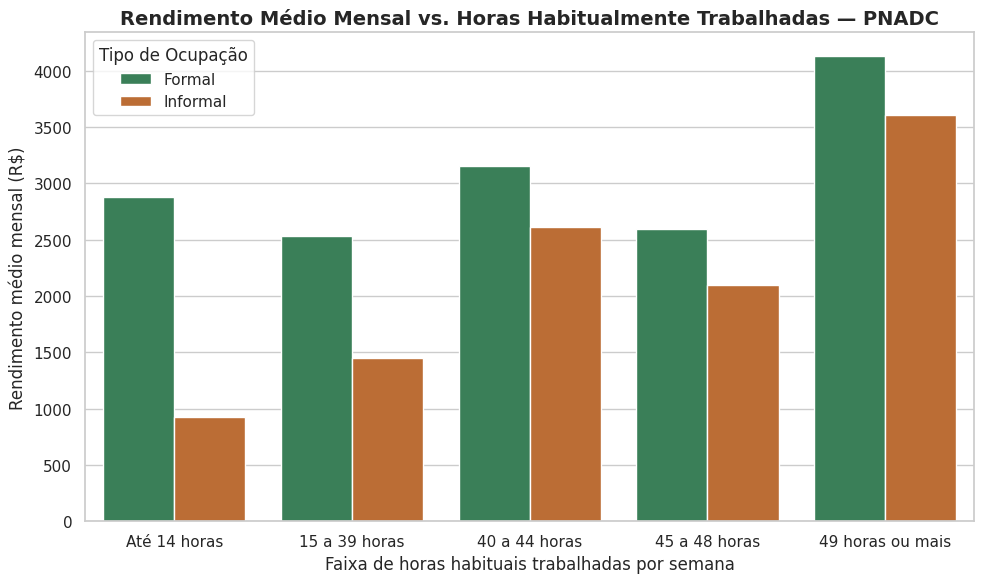

In [78]:
query = """ 
WITH base AS (
  SELECT
    TRY_CAST(ano     AS INTEGER) AS ano,
    TRY_CAST(VD4008  AS INTEGER) AS ocupado,          -- 1 = ocupado
    TRY_CAST(VD4009  AS INTEGER) AS posoc,
    TRY_CAST(V4029   AS INTEGER) AS carteira,
    TRY_CAST(V4028   AS INTEGER) AS estatutario,
    TRY_CAST(V4019   AS INTEGER) AS cnpj,
    TRY_CAST(V1028   AS DOUBLE)  AS peso,
    TRY_CAST(V2009   AS DOUBLE)  AS idade,
    TRY_CAST(VD4016  AS DOUBLE)  AS rendimento,
    TRY_CAST(VD4036  AS INTEGER) AS faixa_horas       -- faixa habitual
  FROM bronze.ibge__pnadctri
),
latest_year AS (
  SELECT MAX(ano) AS ano FROM base
)
SELECT
  faixa_horas,
  CASE faixa_horas
    WHEN 1 THEN 'Até 14 horas'
    WHEN 2 THEN '15 a 39 horas'
    WHEN 3 THEN '40 a 44 horas'
    WHEN 4 THEN '45 a 48 horas'
    WHEN 5 THEN '49 horas ou mais'
    ELSE 'Não aplicável'
  END AS faixa_horas_label,
  rendimento,
  peso,
  CASE
    WHEN posoc IN (1,3) AND carteira = 1 THEN 'Formal'
    WHEN posoc IN (2,4) THEN 'Informal'
    WHEN posoc IN (5,6) AND (estatutario = 1 OR carteira = 1) THEN 'Formal'
    WHEN posoc IN (5,6) THEN 'Informal'
    WHEN posoc = 7 THEN 'Formal'
    WHEN posoc IN (8,9) AND cnpj = 1 THEN 'Formal'
    WHEN posoc IN (8,9) AND cnpj = 2 THEN 'Informal'
    WHEN posoc = 10 THEN 'Informal'
    ELSE NULL
  END AS formalidade
FROM base
WHERE ano = (SELECT ano FROM latest_year)
  AND ocupado = 1
  AND rendimento > 0
  AND faixa_horas BETWEEN 1 AND 5
  AND posoc IS NOT NULL;

"""
# --- Load ---
s3_staging_dir = "s3://observatorio-trabalho-pe-ds-resources-dev/query_results"
df_hours = (
    query_athena_to_polars(
        query=query,
        s3_staging_dir=s3_staging_dir,
        lazy_mode=False
    )
    .to_pandas()
)

# --- Clean & aggregate ---
df_hours = df_hours.dropna(subset=["faixa_horas", "rendimento", "formalidade"])
df_hours = df_hours[df_hours["rendimento"] < 50000]

# Weighted mean rendimento by faixa_horas and formalidade
agg = (
    df_hours.groupby(["faixa_horas_label", "formalidade"], as_index=False)
    .apply(lambda g: (g["rendimento"] * g["peso"]).sum() / g["peso"].sum())
    .reset_index(drop=True)
)
agg.columns = ["faixa_horas_label", "formalidade", "renda_media"]

# Sort for plotting
order = [
    "Até 14 horas",
    "15 a 39 horas",
    "40 a 44 horas",
    "45 a 48 horas",
    "49 horas ou mais",
]
agg["faixa_horas_label"] = pd.Categorical(agg["faixa_horas_label"], order)
agg = agg.sort_values("faixa_horas_label")
# --- Load ---
s3_staging_dir = "s3://observatorio-trabalho-pe-ds-resources-dev/query_results"
df_hours = (
    query_athena_to_polars(
        query=query,
        s3_staging_dir=s3_staging_dir,
        lazy_mode=False
    )
    .to_pandas()
)

# --- Clean & aggregate ---
df_hours = df_hours.dropna(subset=["faixa_horas", "rendimento", "formalidade"])
df_hours = df_hours[df_hours["rendimento"] < 50000]

# Weighted mean rendimento by faixa_horas and formalidade
agg = (
    df_hours.groupby(["faixa_horas_label", "formalidade"], as_index=False)
    .apply(lambda g: (g["rendimento"] * g["peso"]).sum() / g["peso"].sum())
    .reset_index(drop=True)
)
agg.columns = ["faixa_horas_label", "formalidade", "renda_media"]

# Sort for plotting
order = [
    "Até 14 horas",
    "15 a 39 horas",
    "40 a 44 horas",
    "45 a 48 horas",
    "49 horas ou mais",
]
agg["faixa_horas_label"] = pd.Categorical(agg["faixa_horas_label"], order)
agg = agg.sort_values("faixa_horas_label")


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(
    data=agg,
    x="faixa_horas_label",
    y="renda_media",
    hue="formalidade",
    palette={"Formal": "#2E8B57", "Informal": "#D2691E"}
)

plt.title("Rendimento Médio Mensal vs. Horas Habitualmente Trabalhadas — PNADC", fontsize=14, weight="bold")
plt.xlabel("Faixa de horas habituais trabalhadas por semana")
plt.ylabel("Rendimento médio mensal (R$)")
plt.legend(title="Tipo de Ocupação")
plt.tight_layout()
plt.show()


# Rendimento Médio Mensal por Nível de Instrução — PNADC

Como o aumento do nível de instrução influencia o rendimento médio entre trabalhadores formais e informais?

Commentario: Boxplot deixa mais claro a interpretacao 

/tmp/ipykernel_4344/3447906178.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["rendimento"] * g["peso"]).sum() / g["peso"].sum())


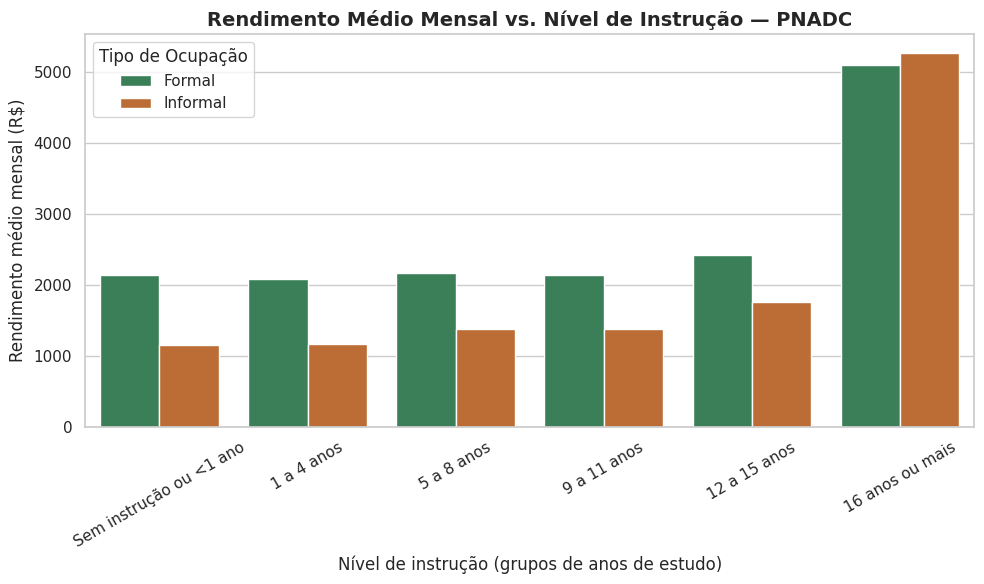

In [81]:
query = """ 
WITH base AS (
  SELECT
    TRY_CAST(ano     AS INTEGER) AS ano,
    TRY_CAST(VD4008  AS INTEGER) AS ocupado,          -- 1 = ocupado
    TRY_CAST(VD4009  AS INTEGER) AS posoc,
    TRY_CAST(V4029   AS INTEGER) AS carteira,
    TRY_CAST(V4028   AS INTEGER) AS estatutario,
    TRY_CAST(V4019   AS INTEGER) AS cnpj,
    TRY_CAST(V1033   AS DOUBLE)  AS peso,
    TRY_CAST(V2009   AS DOUBLE)  AS idade,
    TRY_CAST(VD4016  AS DOUBLE)  AS rendimento,
    TRY_CAST(VD3006  AS INTEGER) AS grupo_anos_estudo
  FROM bronze.ibge__pnadctri
),
latest_year AS (
  SELECT MAX(ano) AS ano FROM base
)
SELECT
  grupo_anos_estudo,
  CASE grupo_anos_estudo
    WHEN 1 THEN 'Sem instrução ou <1 ano'
    WHEN 2 THEN '1 a 4 anos'
    WHEN 3 THEN '5 a 8 anos'
    WHEN 4 THEN '9 a 11 anos'
    WHEN 5 THEN '12 a 15 anos'
    WHEN 6 THEN '16 anos ou mais'
    ELSE 'Não aplicável'
  END AS nivel_instrucao,
  rendimento,
  peso,
  CASE
    WHEN posoc IN (1,3) AND carteira = 1 THEN 'Formal'
    WHEN posoc IN (2,4) THEN 'Informal'
    WHEN posoc IN (5,6) AND (estatutario = 1 OR carteira = 1) THEN 'Formal'
    WHEN posoc IN (5,6) THEN 'Informal'
    WHEN posoc = 7 THEN 'Formal'
    WHEN posoc IN (8,9) AND cnpj = 1 THEN 'Formal'
    WHEN posoc IN (8,9) AND cnpj = 2 THEN 'Informal'
    WHEN posoc = 10 THEN 'Informal'
    ELSE NULL
  END AS formalidade
FROM base
WHERE ano = (SELECT ano FROM latest_year)
  AND ocupado = 1
  AND rendimento > 0
  AND grupo_anos_estudo BETWEEN 1 AND 6;

"""

# --- Load from Athena ---
s3_staging_dir = "s3://observatorio-trabalho-pe-ds-resources-dev/query_results"
df_edu = (
    query_athena_to_polars(
        query=query,
        s3_staging_dir=s3_staging_dir,
        lazy_mode=False
    )
    .to_pandas()
)

# --- Clean ---
df_edu = df_edu.dropna(subset=["grupo_anos_estudo", "rendimento", "formalidade"])
df_edu = df_edu[df_edu["rendimento"] < 50000]

# Weighted mean by education level and formality
agg = (
    df_edu.groupby(["nivel_instrucao", "formalidade"], as_index=False)
    .apply(lambda g: (g["rendimento"] * g["peso"]).sum() / g["peso"].sum())
    .reset_index(drop=True)
)
agg.columns = ["nivel_instrucao", "formalidade", "renda_media"]

# Sort for plotting
order = [
    "Sem instrução ou <1 ano",
    "1 a 4 anos",
    "5 a 8 anos",
    "9 a 11 anos",
    "12 a 15 anos",
    "16 anos ou mais"
]
agg["nivel_instrucao"] = pd.Categorical(agg["nivel_instrucao"], order)
agg = agg.sort_values("nivel_instrucao")
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(
    data=agg,
    x="nivel_instrucao",
    y="renda_media",
    hue="formalidade",
    palette={"Formal": "#2E8B57", "Informal": "#D2691E"}
)

plt.title("Rendimento Médio Mensal vs. Nível de Instrução — PNADC", fontsize=14, weight="bold")
plt.xlabel("Nível de instrução (grupos de anos de estudo)")
plt.ylabel("Rendimento médio mensal (R$)")
plt.xticks(rotation=30)
plt.legend(title="Tipo de Ocupação")
plt.tight_layout()
plt.show()



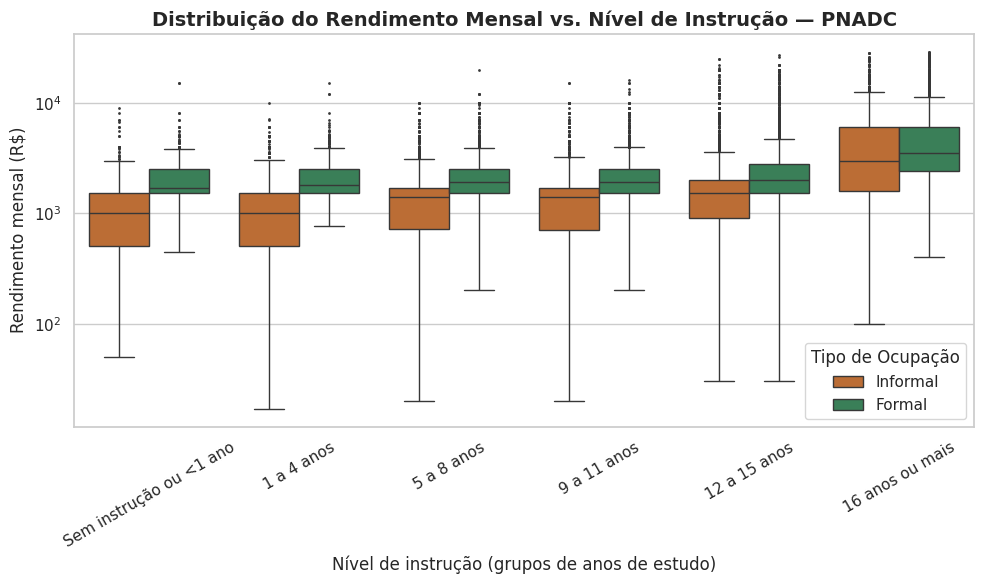

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define desired order (from less to more educated)
order = [
    "Sem instrução ou <1 ano",
    "1 a 4 anos",
    "5 a 8 anos",
    "9 a 11 anos",
    "12 a 15 anos",
    "16 anos ou mais"
]

# Apply categorical order
df_edu["nivel_instrucao"] = pd.Categorical(df_edu["nivel_instrucao"], categories=order, ordered=True)

# Re-plot
plt.figure(figsize=(10,6))
sns.boxplot(
    data=df_edu[df_edu["rendimento"] < 30000],
    x="nivel_instrucao",
    y="rendimento",
    hue="formalidade",
    palette={"Formal": "#2E8B57", "Informal": "#D2691E"},
    fliersize=1
)
plt.yscale("log")
plt.title("Distribuição do Rendimento Mensal vs. Nível de Instrução — PNADC", fontsize=14, weight="bold")
plt.xlabel("Nível de instrução (grupos de anos de estudo)")
plt.ylabel("Rendimento mensal (R$)")
plt.xticks(rotation=30)
plt.legend(title="Tipo de Ocupação")
plt.tight_layout()
plt.show()


In [36]:
import os
from src.utils.athena_utils import query_athena_to_polars
import src.utils.env_variables

import matplotlib.pyplot as plt
import polars as pl

dataset_path = "datasets/caged_fluxo.parquet"

query = f"""
    SELECT 
        ano,
        mes,
        cbo_2002,
        cnae_2_secao as setor,
        SUM(CASE WHEN saldo_movimentacao = 1 THEN 1 ELSE 0 END) as admitidos,
        SUM(CASE WHEN saldo_movimentacao = -1 THEN 1 ELSE 0 END) as demitidos
    FROM bronze.caged__base_dos_dados__novo
    WHERE 1=1
        AND sigla_uf = 'PE'
    GROUP BY 1, 2, 3, 4;
"""

if not os.path.exists(dataset_path):
    s3_url = "s3://observatorio-trabalho-pe-ds-resources-dev/"

    df = query_athena_to_polars(
        query,
        s3_url,
        lazy_mode=False
    )

    df = df.with_columns([
        pl.datetime("ano", "mes", pl.lit(1)).alias("date")
    ])

    df.write_parquet(dataset_path)

else:
    df = pl.read_parquet(dataset_path)

df = df.with_columns((pl.col('admitidos') - pl.col('demitidos')).alias('saldo líquido'))

Text(0.5, 1.0, 'Fluxo de contratações/demissões no estado de Pernambuco')

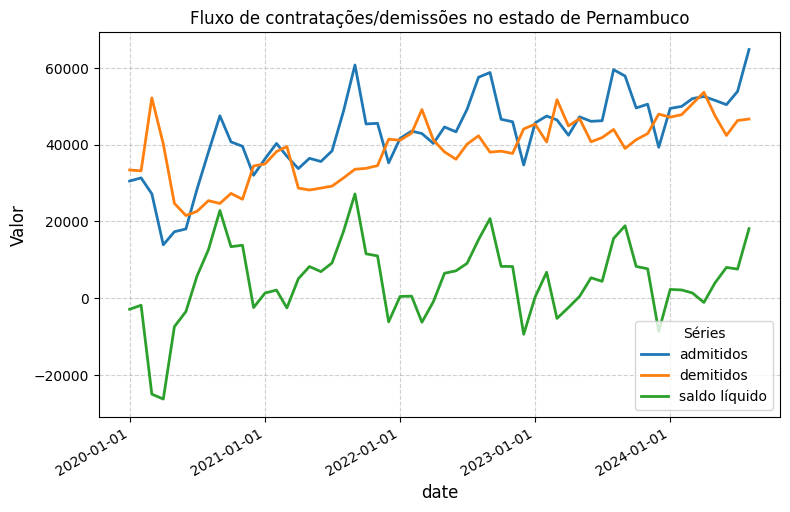

In [37]:
import polars as pl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, AutoDateLocator
import numpy as np


def line_plot(df: pl.DataFrame, x_col: str, series: list[str]):
    """
    Gera um gráfico de linha a partir de um DataFrame Polars, agregando por soma
    quando houver múltiplas linhas com o mesmo valor em x e ordenando o eixo X.

    Parâmetros
    ----------
    df : pl.DataFrame
        DataFrame de entrada.
    x_col : str
        Nome da coluna usada para o eixo X (numérica ou de data).
    series : list[str]
        Lista com os nomes das colunas de valores das séries a serem plotadas.
    """
    if isinstance(df, pl.LazyFrame):
        df = df.collect()

    df = (
        df.group_by(x_col)
          .agg([pl.col(s).sum().alias(s) for s in series])
          .sort(x_col)
    )

    pdf = df.to_pandas()

    fig, ax = plt.subplots(figsize=(8, 5))
    is_datetime = np.issubdtype(pdf[x_col].dtype, np.datetime64)

    for col in series:
        ax.plot(pdf[x_col], pdf[col], label=col, linewidth=2)

    if is_datetime:
        ax.xaxis.set_major_locator(AutoDateLocator())
        ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
        fig.autofmt_xdate()

    ax.set_xlabel(x_col, fontsize=12)
    ax.set_ylabel("Valor", fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(title="Séries", loc="best")
    plt.tight_layout()
    
    return fig, ax

fig, ax = line_plot(df, 'date', ['admitidos', 'demitidos', 'saldo líquido'])
ax.set_title('Fluxo de contratações/demissões no estado de Pernambuco')

In [38]:
def horizontal_bar_plot(df: pl.DataFrame, col_values: str, col_groups: str, max_lines: int = None):
    """
    Gera um gráfico de barras horizontais a partir de um DataFrame Polars.
    Valores positivos são exibidos em verde e negativos em vermelho.
    As barras são ordenadas do maior ao menor valor, de cima para baixo.
    Pode-se limitar o número de grupos exibidos pelos maiores valores em módulo.

    Parâmetros
    ----------
    df : pl.DataFrame
        DataFrame de entrada.
    col_values : str
        Nome da coluna de valores numéricos.
    col_groups : str
        Nome da coluna de agrupamento (categorias).
    max_lines : int, opcional
        Quantidade máxima de grupos exibidos, ordenados pelo maior valor em módulo.
    """
    if isinstance(df, pl.LazyFrame):
        df = df.collect()

    df = (
        df.group_by(col_groups)
          .agg(pl.col(col_values).sum().alias(col_values))
          .with_columns(pl.col(col_values).abs().alias("_abs_val"))
          .sort("_abs_val", descending=True)
    )

    if max_lines is not None:
        df = df.head(max_lines)

    df = df.sort(col_values, descending=False)
    pdf = df.to_pandas()
    colors = ["green" if v >= 0 else "red" for v in pdf[col_values]]

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.barh(pdf[col_groups], pdf[col_values], color=colors)

    ax.set_xlabel(col_values, fontsize=12)
    ax.grid(True, axis="x", linestyle="--", alpha=0.6)

    plt.tight_layout()
    return fig, ax

In [39]:
mapa_setores = {
    "A": "Agricultura, Pecuária, Produção\nFlorestal, Pesca e Aquicultura",
    "B": "Indústrias Extrativas",
    "C": "Indústrias de Transformação",
    "D": "Eletricidade e Gás",
    "E": "Água, Esgoto, Atividades de Gestão\nde Resíduos e Descontaminação",
    "F": "Construção",
    "G": "Comércio; Reparação de Veículos\nAutomotores e Motocicletas",
    "H": "Transporte, Armazenagem e Correio",
    "I": "Alojamento e Alimentação",
    "J": "Informação e Comunicação",
    "K": "Atividades Financeiras, de\nSeguros e Serviços Relacionados",
    "L": "Atividades Imobiliárias",
    "M": "Atividades Profissionais,\nCientíficas e Técnicas",
    "N": "Atividades Administrativas\ne Serviços Complementares",
    "O": "Administração Pública,\nDefesa e Seguridade Social",
    "P": "Educação",
    "Q": "Saúde Humana e\nServiços Sociais",
    "R": "Artes, Cultura,\nEsporte e Recreação",
    "S": "Outras Atividades de Serviços",
    "T": "Serviços Domésticos",
    "U": "Organismos Internacionais e\nOutras Instituições Extraterritoriais"
}

df = df.with_columns(
    pl.col("setor").map_elements(
        lambda x: mapa_setores.get(x, "Setor desconhecido"),
        return_dtype=pl.Utf8
    ).alias("descrição setor")
)

# Maiores fluxos por setor

- Quais setores tiveram os maiores saldos positivos de contratações em Pernambuco?
- Quais setores tiveram os maiores saldos negativos (demissões líquidas)?
- Qual é a ordem de magnitude desses saldos — ou seja, quais setores mais contribuem para o saldo total?
- Há predomínio de saldos positivos ou negativos entre os principais setores?
- Qual é o setor com o maior movimento absoluto (em módulo), independentemente de ser contratação ou demissão?

# Maiores admissões por setor

- Quais são os setores com maior número de admissões no período analisado?
- Qual setor ocupa o primeiro lugar em volume de contratações?
- Qual é a diferença em magnitude entre os setores com maior e menor número de admissões entre os destacados?
- O volume de admissões é concentrado em poucos setores ou distribuído de forma equilibrada?
- Há setores que tradicionalmente lideram as admissões (ex.: comércio, serviços, construção)?

Text(0.5, 1.0, 'Maiores admissões por setor')

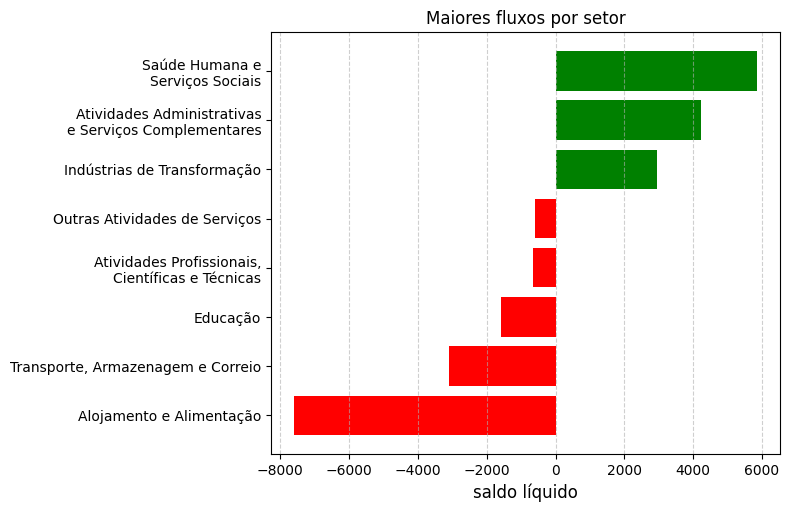

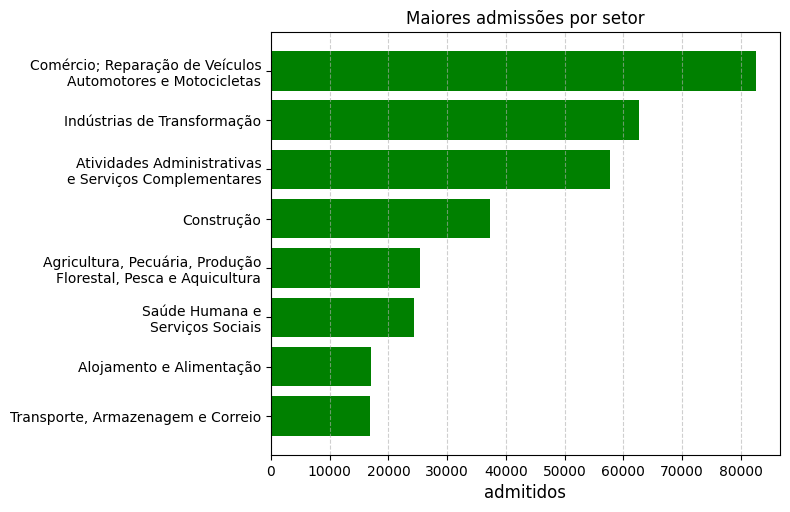

In [40]:
fig, ax = horizontal_bar_plot(df.filter(pl.col('ano') == 2020), 'saldo líquido', 'descrição setor', 8)
ax.set_title('Maiores fluxos por setor')
fig, ax = horizontal_bar_plot(df.filter(pl.col('ano') == 2020), 'admitidos', 'descrição setor', 8)
ax.set_title('Maiores admissões por setor')

# Salários médios de admissão/demissão

- Qual é o valor médio dos salários de admissão e de demissão em cada trimestre?
- Existe uma diferença visível entre os salários médios de quem entra e de quem sai?
- Em quais períodos o salário médio de admissão superou (ou se aproximou de) o de demissão?
- Há tendência de aumento ou queda em algum dos dois tipos de salário ao longo do tempo?
- O comportamento das duas curvas é paralelo (andam juntas) ou diverge em determinados momentos?

In [9]:
dataset_path = "datasets/caged_salarios.parquet"

query = f"""
    SELECT 
        ano,
        mes,
        cbo_2002,
        cnae_2_secao as setor,
        AVG(CASE WHEN saldo_movimentacao = 1 THEN salario_mensal ELSE 0 END) as salario_admissao,
        AVG(CASE WHEN saldo_movimentacao = -1 THEN salario_mensal ELSE 0 END) as salario_demissao
    FROM bronze.caged__base_dos_dados__novo
    WHERE 1=1
        AND sigla_uf = 'PE'
    GROUP BY 1, 2, 3, 4;
"""

if not os.path.exists(dataset_path):
    s3_url = "s3://observatorio-trabalho-pe-ds-resources-dev/"

    df = query_athena_to_polars(
        query,
        s3_url,
        lazy_mode=False
    )

    df = df.with_columns([
        pl.datetime("ano", "mes", pl.lit(1)).alias("date")
    ])

    df.write_parquet(dataset_path)

else:
    df = pl.read_parquet(dataset_path)

(<Figure size 800x500 with 1 Axes>, <Axes: xlabel='date', ylabel='Valor'>)

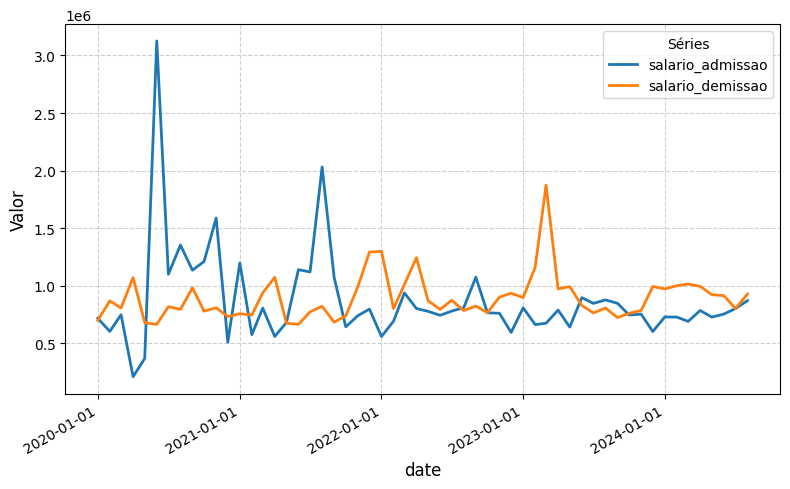

In [ ]:
fig, ax = line_plot(df.filter(pl.col('setor') == 'C'), 'date', ['salario_admissao', 'salario_demissao'])
ax.set_title('Salários médios de contratação/demissão')

# Maiores causas de dispensa no estado de Pernambuco

- Quais são os principais motivos de desligamento em Pernambuco?
- Qual é o motivo mais frequente de demissão no período analisado?
- Quais causas representam a maior parte dos desligamentos?
- Há motivos que possuem magnitudes semelhantes, sugerindo peso similar na dinâmica do mercado?
- Quantos desligamentos foram registrados para cada motivo?

In [ ]:
dataset_path = "datasets/caged_1.parquet"

query = f"""
    SELECT 
        ano,
        mes,
        tipo_movimentacao,
        (CASE WHEN saldo_movimentacao = 1 THEN 'admissao' ELSE 'demissao' END) as movimentacao,
        COUNT(*) as qtd
    FROM bronze.caged__base_dos_dados__novo
    WHERE 1=1
        AND sigla_uf = 'PE'
    GROUP BY 1, 2, 3, 4, 5, 6, 7, 8;
"""

if not os.path.exists(dataset_path):
    s3_url = "s3://observatorio-trabalho-pe-ds-resources-dev/"

    df = query_athena_to_polars(
        query,
        s3_url,
        lazy_mode=False
    )

    df = df.with_columns([
        pl.datetime("ano", "mes", pl.lit(1)).alias("date")
    ])

    df.write_parquet(dataset_path)

else:
    df = pl.read_parquet(dataset_path)

Text(0.5, 1.0, 'Maiores causas de dispensa no estado de Pernambuco')

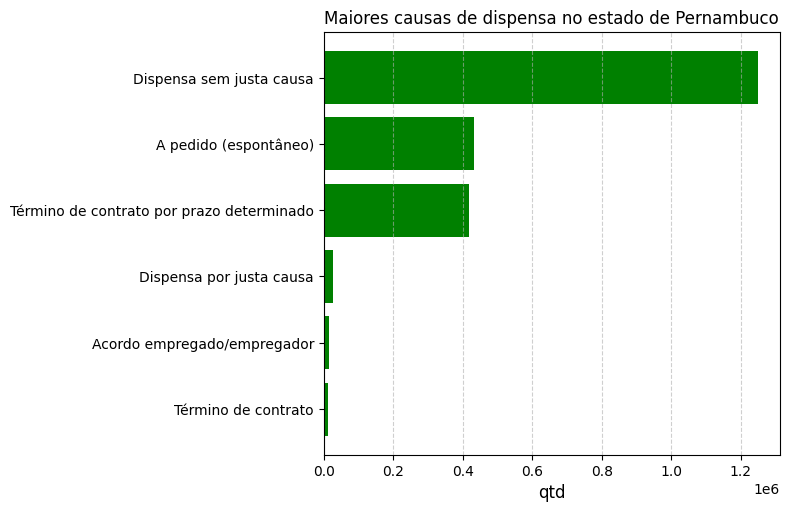

In [15]:
mapa_mov = {
    10: "Primeiro emprego",
    20: "Reemprego",
    25: "Contrato por prazo determinado",
    35: "Reintegração",
    70: "Transferência de entrada",
    31: "Dispensa sem justa causa",
    32: "Dispensa por justa causa",
    40: "A pedido (espontâneo)",
    43: "Término de contrato por prazo determinado",
    45: "Término de contrato",
    50: "Aposentado",
    60: "Morte",
    80: "Transferência de saída",
    90: "Acordo empregado/empregador"
}

df =  df.with_columns(
    pl.col('tipo_movimentacao')
        .cast(pl.Int64, strict=False)
        .map_elements(lambda x: mapa_mov.get(x, "Código de movimentação desconhecido"), return_dtype=pl.Utf8)
        .alias("descrição movimentação")
)

fig, ax = horizontal_bar_plot(df.filter(pl.col('movimentacao') == 'demissao'), 'qtd', 'descrição movimentação', 6)
ax.set_title('Maiores causas de dispensa no estado de Pernambuco')

# Maiores níveis de escolaridade por gênero

- Qual é a distribuição das pessoas por nível de escolaridade em Pernambuco (ou no universo analisado)?
- Em cada nível de escolaridade, quantos homens e quantas mulheres estão representados?
- Qual o nível de escolaridade mais comum em cada gênero?
- Há níveis em que a diferença entre gêneros é mais acentuada (por exemplo, ensino superior)?
- O número de mulheres supera o de homens em quais níveis — e vice-versa?

In [ ]:
dataset_path = "datasets/caged_2.parquet"

query = f"""
    SELECT 
        ano,
        mes,
        grau_instrucao,
        sexo,
        COUNT(*) as qtd
    FROM bronze.caged__base_dos_dados__novo
    WHERE 1=1
        AND sigla_uf = 'PE'
    GROUP BY 1, 2, 3, 4, 5, 6, 7, 8;
"""

if not os.path.exists(dataset_path):
    s3_url = "s3://observatorio-trabalho-pe-ds-resources-dev/"

    df = query_athena_to_polars(
        query,
        s3_url,
        lazy_mode=False
    )

    df = df.with_columns([
        pl.datetime("ano", "mes", pl.lit(1)).alias("date")
    ])

    df.write_parquet(dataset_path)

else:
    df = pl.read_parquet(dataset_path)

In [16]:
mapa_grau_instrucao = {
    "1": "Analfabeto",
    "2": "Até 5ª Incompleto (Fundamental Incompleto)",
    "3": "5ª Completa",
    "4": "6ª a 9ª Incompleto (Fundamental Completo)",
    "5": "Fundamental Completo",
    "6": "Médio Incompleto",
    "7": "Médio Completo",
    "8": "Superior Incompleto",
    "9": "Superior Completo",
    "10": "Mestrado",
    "11": "Doutorado",
    "80": "Não identificado",
    "99": "Ignorado"
}

mapa_sexo = {
    "1": "Masculino",
    "3": "Feminino",
    "9": "Não identificado"
}

df = df.with_columns([
    pl.col("grau_instrucao")
      .map_elements(lambda x: mapa_grau_instrucao.get(x, "Desconhecido"), return_dtype=pl.Utf8)
      .alias("escolaridade"),

    pl.col("sexo")
      .map_elements(lambda x: mapa_sexo.get(x, "Desconhecido"), return_dtype=pl.Utf8)
      .alias("sexo")
])

Text(0.5, 1.0, 'Maiores níveis de escolaridade por gênero')

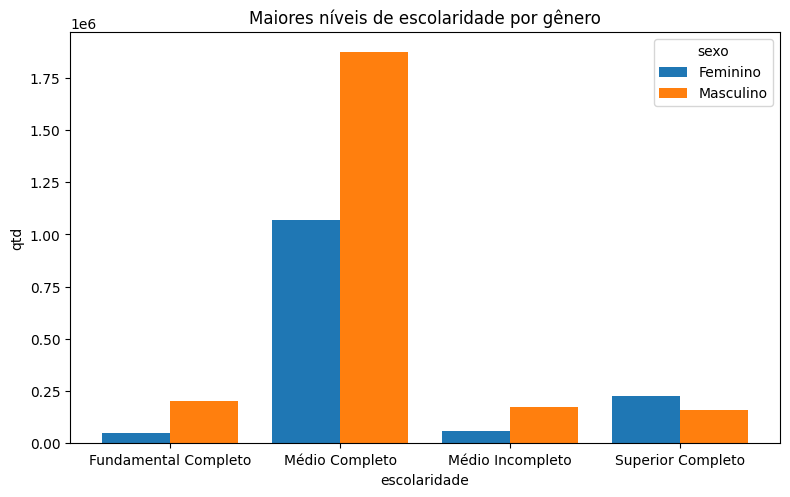

In [18]:
def grouped_bar_plot(
    df: pl.DataFrame,
    col_x: str,
    col_y: str,
    col_group: str | None = None,
    title: str | None = None,
    figsize: tuple = (8, 5),
    max_groups: int | None = None
):
    """
    Plota um gráfico de barras agrupadas com matplotlib a partir de um DataFrame Polars.

    Parâmetros
    ----------
    df : pl.DataFrame
        DataFrame de entrada (Polars).
    col_x : str
        Nome da coluna usada como eixo X (grupo primário).
    col_y : str
        Nome da coluna com os valores.
    col_group : str | None, opcional
        Nome da coluna de agrupamento secundário (define a cor das barras).
        Se None, plota apenas um grupo simples.
    title : str | None, opcional
        Título do gráfico.
    figsize : tuple, opcional
        Tamanho da figura (default = (8, 5)).
    max_groups : int | None, opcional
        Número máximo de grupos distintos de col_x a serem exibidos.
        Caso o total exceda esse número, apenas os grupos com maior soma em col_y são mantidos.
    """
    if col_group is not None:
        df = (
            df.group_by(col_x, col_group)
                .agg(pl.col(col_y).sum().alias(col_y))
                .with_columns(pl.col(col_y).abs().alias("_abs_val"))
                .sort("_abs_val", descending=True)
        )
    else:
        df = (
            df.group_by(col_x)
                .agg(pl.col(col_y).sum().alias(col_y))
                .with_columns(pl.col(col_y).abs().alias("_abs_val"))
                .sort("_abs_val", descending=True)
        )

    pdf = df.to_pandas()

    if col_group:
        agg_df = pdf.groupby([col_x, col_group], as_index=False)[col_y].sum()
    else:
        agg_df = pdf.groupby(col_x, as_index=False)[col_y].sum()

    if max_groups is not None and len(agg_df[col_x].unique()) > max_groups:
        top_groups = (
            agg_df.groupby(col_x)[col_y]
            .sum()
            .sort_values(ascending=False)
            .head(max_groups)
            .index
        )
        agg_df = agg_df[agg_df[col_x].isin(top_groups)]

    x_labels = list(agg_df[col_x].unique())
    x = np.arange(len(x_labels))

    fig, ax = plt.subplots(figsize=figsize)

    if col_group is None:
        values = agg_df.set_index(col_x).reindex(x_labels)[col_y].fillna(0)
        ax.bar(x, values, width=0.6)
    else:
        groups = agg_df[col_group].unique()
        n_groups = len(groups)
        width = 0.8 / n_groups

        for i, g in enumerate(groups):
            subset = agg_df[agg_df[col_group] == g].set_index(col_x).reindex(x_labels).fillna(0)
            ax.bar(
                x + i * width - 0.4 + width / 2,
                subset[col_y],
                width,
                label=str(g)
            )

        ax.legend(title=col_group, loc="best")

    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.set_xlabel(col_x)
    ax.set_ylabel(col_y)
    if title:
        ax.set_title(title)

    plt.tight_layout()
    return fig, ax

fig, ax = grouped_bar_plot(df, 'escolaridade', 'qtd', 'sexo', max_groups=4)
ax.set_title('Maiores níveis de escolaridade por gênero')

# Cruzamento salário x idade x gênero

- Qual é a relação geral entre idade e salário dos trabalhadores observados?
- Há uma tendência de aumento dos salários com a idade (experiência)?
- Quais são as faixas etárias com maior concentração de trabalhadores (pontos mais opacos)?
- Qual é o intervalo de salários mais comum para cada gênero?
- Existem diferenças visuais claras entre as distribuições masculinas e femininas no gráfico?

# Cruzamento salário x escolaridade x gênero

- Como varia o salário médio conforme o nível de escolaridade?
- Há uma tendência clara de aumento salarial com o aumento da escolaridade?
- Quais níveis de escolaridade concentram a maior parte dos trabalhadores (pontos mais opacos)?
- Qual é o nível de escolaridade mais frequente entre homens e mulheres?
- Existem níveis de ensino com remunerações semelhantes entre gêneros?

In [45]:
dataset_path = "datasets/caged_salarios_demografico.parquet"

query = f"""
    SELECT 
        ano,
        mes,
        cbo_2002,
        cnae_2_secao as setor,
        grau_instrucao,
        sexo,
        idade,
        AVG(salario_mensal) as salario,
        COUNT(*) as qtd
    FROM bronze.caged__base_dos_dados__novo
    WHERE 1=1
        AND sigla_uf = 'PE'
    GROUP BY 1, 2, 3, 4, 5, 6, 7;
"""

if not os.path.exists(dataset_path):
    s3_url = "s3://observatorio-trabalho-pe-ds-resources-dev/"

    df = query_athena_to_polars(
        query,
        s3_url,
        lazy_mode=False
    )

    df = df.with_columns([
        pl.datetime("ano", "mes", pl.lit(1)).alias("date")
    ])

    df.write_parquet(dataset_path)

else:
    df = pl.read_parquet(dataset_path)

df = df.with_columns([
    pl.col("grau_instrucao")
      .map_elements(lambda x: mapa_grau_instrucao.get(x, "Desconhecido"), return_dtype=pl.Utf8)
      .alias("escolaridade"),

    pl.col("sexo")
      .map_elements(lambda x: mapa_sexo.get(x, "Desconhecido"), return_dtype=pl.Utf8)
      .alias("sexo")
])

Text(0.5, 1.0, 'Cruzamento salário x escolaridade x gênero')

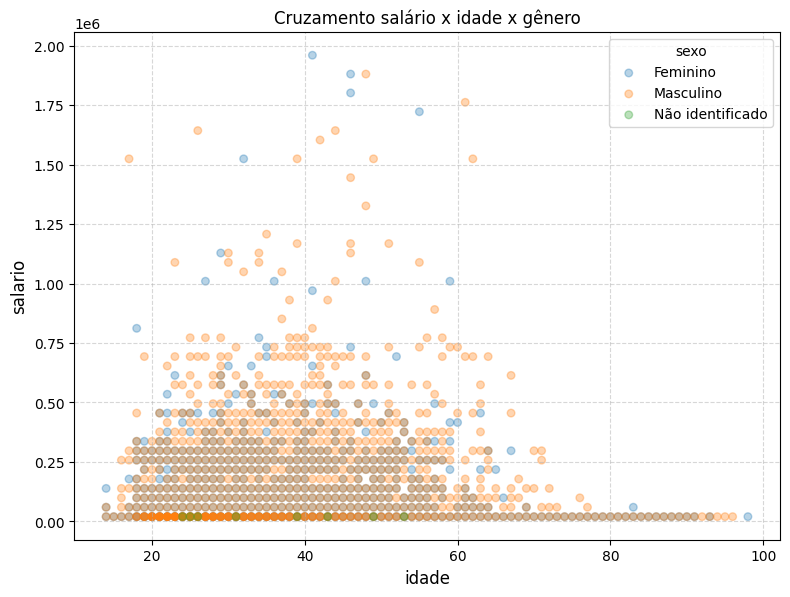

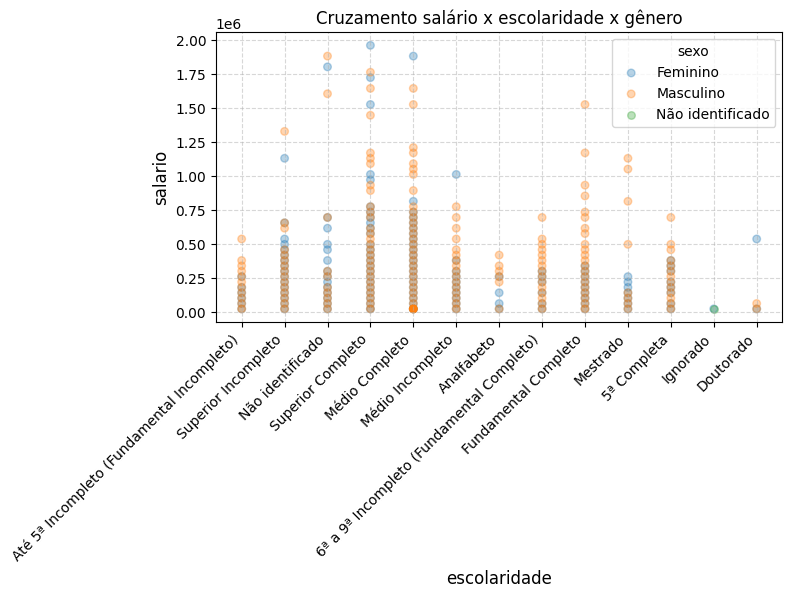

In [24]:
def scatter_cross_plot(
    df: pl.DataFrame,
    col_y: str,
    col_x: str,
    col_group: str | None = None,
    col_quant: str | None = None,
    num_classes: int = 5,
):
    """
    Gera um gráfico de dispersão a partir de um DataFrame Polars.
    Divide `col_y` em `num_classes` classes, agrega por (x, classe[, grupo]),
    substitui `col_y` pelo valor médio da classe e soma a quantidade antes do plot.
    A cor/legenda é definida apenas por `col_group` (se fornecido).
    Caso `col_x` não seja numérico, os rótulos do eixo X são rotacionados em 45°.

    Parâmetros
    ----------
    df : pl.DataFrame
        DataFrame de entrada.
    col_y : str
        Nome da coluna a ser usada no eixo Y.
    col_x : str
        Nome da coluna a ser usada no eixo X.
    col_group : str, opcional
        Nome da coluna categórica para colorir/legendar os pontos.
    col_quant : str, opcional
        Nome da coluna de quantidade para transparência (alpha). Se ausente, usa 1 por linha.
    num_classes : int
        Número de classes (faixas) para dividir `col_y` em intervalos iguais.
    """
    if isinstance(df, pl.LazyFrame):
        df = df.collect()

    base_qty_col = col_quant if col_quant is not None else "_unit_qty"
    if col_quant is None:
        df = df.with_columns(pl.lit(1).alias(base_qty_col))

    y_min = float(df[col_y].min())
    y_max = float(df[col_y].max())
    if not np.isfinite(y_min) or not np.isfinite(y_max):
        y_min, y_max = 0.0, 1.0
    if y_max == y_min:
        y_min, y_max = y_min - 0.5, y_max + 0.5

    num_classes = int(max(1, num_classes))
    bins = np.linspace(y_min, y_max, num_classes + 1)
    mids = [(bins[i] + bins[i + 1]) / 2 for i in range(num_classes)]

    df = df.with_columns(
        (
            ((pl.col(col_y) - y_min) / (y_max - y_min) * num_classes)
            .floor()
            .cast(pl.Int32)
            .clip(0, num_classes - 1)
        ).alias("_bin"),
        pl.lit(mids).list.get(
            ((pl.col(col_y) - y_min) / (y_max - y_min) * num_classes)
            .floor()
            .cast(pl.Int32)
            .clip(0, num_classes - 1)
        ).alias("_class_mid"),
    )

    keys = [col_x, "_bin"]
    if col_group is not None:
        keys.append(col_group)

    agg = (
        df.group_by(keys)
          .agg([
              pl.col(base_qty_col).sum().alias("_qty_sum"),
              pl.first("_class_mid").alias(col_y),
          ])
    )

    q = agg.select(pl.col("_qty_sum")).to_series()
    q_min = float(q.min())
    q_max = float(q.max())
    adjust = q_max * 0.25
    if np.isfinite(q_min) and np.isfinite(q_max) and q_max > q_min:
        alpha_vals = (adjust + q.to_numpy() - q_min) / (adjust + q_max - q_min)
    else:
        alpha_vals = np.full(agg.height, 0.8, dtype=float)
    alpha_vals = np.clip(0.15 + 0.85 * alpha_vals, 0.15, 1.0)
    agg = agg.with_columns(pl.Series(name="_alpha", values=alpha_vals))

    fig, ax = plt.subplots(figsize=(8, 6))

    if col_group is None:
        sub = agg.select([col_x, col_y, "_alpha"]).to_pandas()
        ax.scatter(sub[col_x], sub[col_y], alpha=sub["_alpha"], s=30)
    else:
        groups = agg.select(pl.col(col_group)).unique().to_series().to_list()
        groups = sorted(groups, key=lambda x: str(x))
        for g in groups:
            sub = (
                agg.filter(pl.col(col_group) == g)
                   .select([col_x, col_y, "_alpha"])
                   .to_pandas()
            )
            if not sub.empty:
                ax.scatter(sub[col_x], sub[col_y], alpha=sub["_alpha"], s=30, label=str(g))
        ax.legend(title=col_group, loc="best")

    ax.set_xlabel(col_x, fontsize=12)
    ax.set_ylabel(col_y, fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.5)

    if df[col_x].dtype not in (pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64):
        plt.xticks(rotation=45, ha="right")

    plt.tight_layout()
    return fig, ax

fig, ax = scatter_cross_plot(df.filter(pl.col('salario') < 2e6), 'salario', 'idade', 'sexo', 'qtd', 50)
ax.set_title('Cruzamento salário x idade x gênero')
fig, ax = scatter_cross_plot(df.filter(pl.col('salario') < 2e6), 'salario', 'escolaridade', 'sexo', 'qtd', 50)
ax.set_title('Cruzamento salário x escolaridade x gênero')

In [28]:
import geopandas as gpd
import pandas as pd

from geobr import read_municipality
from matplotlib.colors import Normalize, LogNorm
from matplotlib.cm import ScalarMappable, get_cmap


def plot_pe_choropleth(
    df: pl.DataFrame | pd.DataFrame,
    col_code: str,
    col_value: str,
    title: str = "Admissões – Confecção",
    cmap: str = "Blues",
    agg: str = "sum",
    year: int = 2022,
    norm_mode: str = "robust",
    p_low: float = 2.0,
    p_high: float = 98.0,
    log_eps: float = 1e-6,
    clip_min: bool = True,
    clip_max: bool = True,
):
    """
    Gera um coroplético dos municípios de PE com normalização robusta a outliers.

    Parâmetros
    ----------
    df : pl.DataFrame | pd.DataFrame
        Tabela com códigos de município (7 dígitos) e valores.
    col_code : str
        Nome da coluna com o código IBGE do município (7 dígitos; str ou int).
    col_value : str
        Nome da coluna com o valor a ser mapeado.
    title : str
        Título do mapa.
    cmap : str
        Colormap do matplotlib.
    agg : str
        Agregação quando houver códigos repetidos: "sum", "mean", etc.
    year : int
        Ano da malha municipal (geobr).
    norm_mode : {"robust","linear","log"}
        "robust": usa percentis (p_low–p_high) para vmin/vmax; melhora contraste.
        "linear": usa min/max dos dados.
        "log": usa LogNorm (valor transformado por log); bom para caudas longas.
    p_low, p_high : float
        Percentis usados no modo "robust". Ex.: 2 e 98.
    log_eps : float
        Deslocamento mínimo para LogNorm (evita log(0)).
    clip_min, clip_max : bool
        Se True, valores fora de [vmin, vmax] são “clipped” (melhor contraste).

    Retorno
    -------
    (fig, ax) : matplotlib.figure.Figure, matplotlib.axes.Axes
        Figura e eixo do mapa.
    """
    if isinstance(df, pl.LazyFrame):
        df = df.collect()
    pdf = df.to_pandas() if isinstance(df, pl.DataFrame) else df.copy()

    pdf = (
        pdf.assign(
            _code=pd.to_numeric(
                pdf[col_code].astype(str).str.extract(r"(\d{7})", expand=False),
                errors="coerce",
            )
        )
        .dropna(subset=["_code"])
        .astype({"_code": "int64"})
    )
    pdf = pdf.groupby("_code", as_index=False).agg({col_value: agg})

    muni = read_municipality(code_muni=26, year=year)[["code_muni", "geometry"]]
    gdf = muni.merge(pdf, how="left", left_on="code_muni", right_on="_code")

    vals = gdf[col_value].to_numpy(dtype=float)
    vals_no_nan = vals[~np.isnan(vals)]
    if vals_no_nan.size == 0:
        vmin, vmax = 0.0, 1.0
    else:
        if norm_mode == "robust":
            vmin = np.percentile(vals_no_nan, p_low)
            vmax = np.percentile(vals_no_nan, p_high)
        elif norm_mode == "log":
            vmin = max(vals_no_nan.min(), log_eps)
            vmax = vals_no_nan.max()
        else:
            vmin = vals_no_nan.min()
            vmax = vals_no_nan.max()
        if vmax <= vmin:
            vmax = vmin + 1.0

    if clip_min:
        vals = np.where(np.isnan(vals), np.nan, np.maximum(vals, vmin))
    if clip_max:
        vals = np.where(np.isnan(vals), np.nan, np.minimum(vals, vmax))
    gdf[col_value] = vals

    if norm_mode == "log":
        norm = LogNorm(vmin=max(vmin, log_eps), vmax=max(vmax, vmin + log_eps))
    else:
        norm = Normalize(vmin=vmin, vmax=vmax)

    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(
        ax=ax,
        column=col_value,
        cmap=cmap,
        norm=norm,
        linewidth=0.4,
        edgecolor="#cccccc",
        missing_kwds={"color": "#f2f2f2", "edgecolor": "#cccccc", "hatch": None},
    )
    ax.set_axis_off()

    sm = ScalarMappable(cmap=get_cmap(cmap), norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.045, pad=0.08)
    cbar.ax.tick_params(labelsize=9)
    ax.set_title(title)

    plt.tight_layout()
    return fig, ax

# Admições por município

- Quais municípios de Pernambuco apresentam os maiores volumes de admissões no período analisado?
- Onde estão localizadas as maiores concentrações geográficas de contratação?
- Quais municípios registram baixa atividade contratual (regiões mais “frias” no mapa)?
- O fluxo de admissões é concentrado em poucos polos ou espalhado pelo estado?
- Há regiões inteiras com pouca movimentação (ex.: Sertão, Agreste, Zona da Mata)?
- As áreas de maior contratação coincidem com centros econômicos ou industriais (como Recife, Suape, Caruaru)?
- Existe correlação espacial entre os municípios com mais admissões e os com maiores populações?
- Os municípios com mais contratações também tendem a ser sede de polos setoriais específicos (por exemplo, têxtil, turismo, construção civil)?
- O mapa revela desigualdades regionais na geração de emprego formal?
- Há concentração costeira versus interiorana das admissões?
- A intensidade das admissões está alinhada a infraestruturas logísticas (rodovias, portos, zonas industriais)?

# Demissões por município

- Quais municípios de Pernambuco registram os maiores volumes de demissões?
- Onde estão concentrados os principais polos de desligamento no período analisado?
- Quais regiões aparecem com menor intensidade de demissões (áreas mais “frias” no mapa)?
- O padrão geográfico das demissões é concentrado ou disperso?
- Há sobreposição entre os municípios com mais admissões e os com mais demissões?
- As áreas com mais demissões coincidem com os polos de maior atividade econômica, sugerindo alta rotatividade?
- Existe correlação espacial entre volume de demissões e população urbana/industrial?
- O mapa mostra assimetria regional — por exemplo, concentração de desligamentos na Região Metropolitana versus estabilidade no interior?

In [29]:
dataset_path = "datasets/caged_fluxo_cidade.parquet"

query = f"""
    SELECT 
        ano,
        mes,
        cbo_2002,
        cnae_2_secao as setor,
        id_municipio,
        SUM(CASE WHEN saldo_movimentacao = 1 THEN 1 ELSE 0 END) as admitidos,
        SUM(CASE WHEN saldo_movimentacao = -1 THEN 1 ELSE 0 END) as demitidos
    FROM bronze.caged__base_dos_dados__novo
    WHERE 1=1
        AND sigla_uf = 'PE'
    GROUP BY 1, 2, 3, 4, 5;
"""

if not os.path.exists(dataset_path):
    s3_url = "s3://observatorio-trabalho-pe-ds-resources-dev/"

    df = query_athena_to_polars(
        query,
        s3_url,
        lazy_mode=False
    )

    df = df.with_columns([
        pl.datetime("ano", "mes", pl.lit(1)).alias("date")
    ])

    df.write_parquet(dataset_path)

else:
    df = pl.read_parquet(dataset_path)

C:\Users\RafaelMarinh_5k9komz\AppData\Local\Temp\ipykernel_65824\195067880.py:118: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sm = ScalarMappable(cmap=get_cmap(cmap), norm=norm)
C:\Users\RafaelMarinh_5k9komz\AppData\Local\Temp\ipykernel_65824\195067880.py:118: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sm = ScalarMappable(cmap=get_cmap(cmap), norm=norm)


(<Figure size 1000x1000 with 2 Axes>,
 <Axes: title={'center': 'Demições por município'}>)

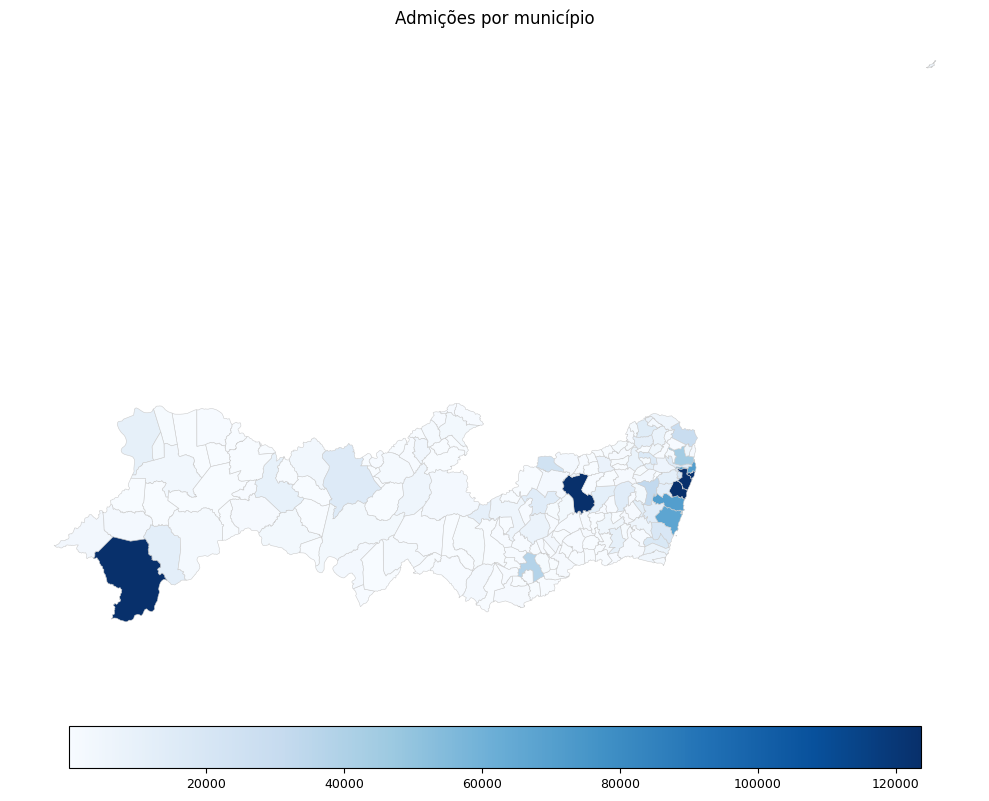

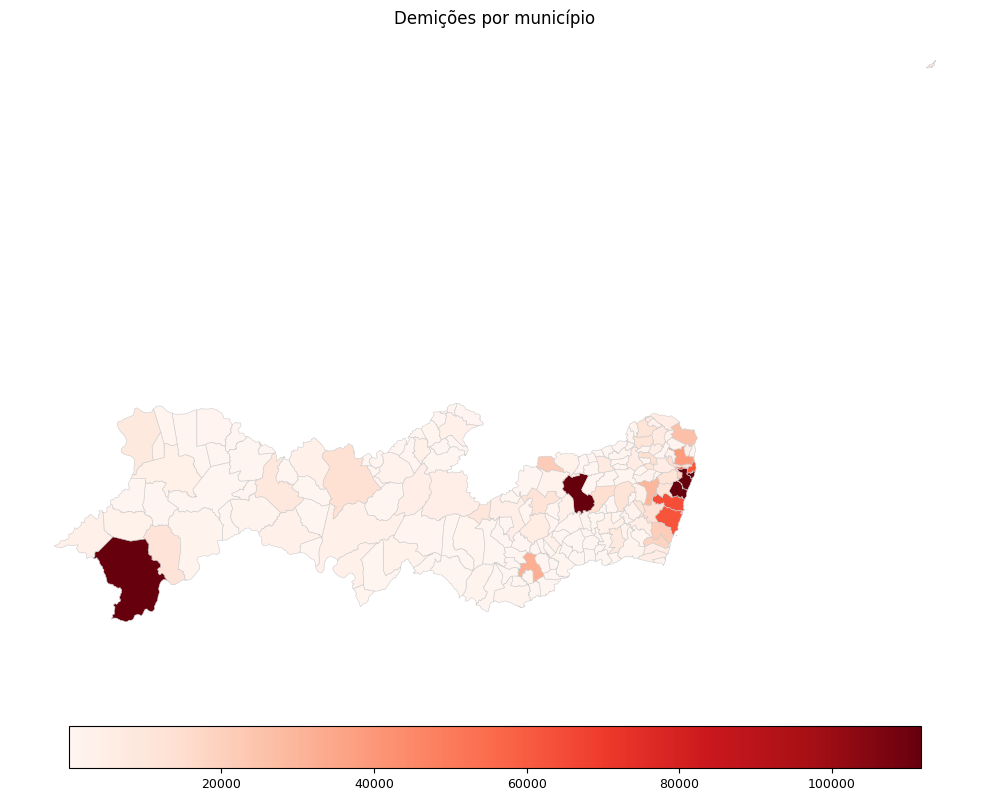

In [30]:
plot_pe_choropleth(df, 'id_municipio', 'admitidos', title="Admições por município")
plot_pe_choropleth(df, 'id_municipio', 'demitidos', title="Demições por município", cmap="Reds")

# PNADE

In [ ]:
from src.utils.athena_utils import query_athena_to_polars

import matplotlib.pyplot as plt
import polars as pl
import os

dataset_path = "datasets/PNAD_1.parquet"

query = f"""
SELECT
  ano,
  trimestre,
  CAST(ano AS VARCHAR) || '-T' || CAST(trimestre AS VARCHAR) AS ano_tri,
  uf,
  upa,
  v1008,
  COALESCE(CAST(v1027 AS DOUBLE), CAST(v1028 AS DOUBLE)) AS peso_dom,
  v1022
FROM bronze.ibge__pnadctri
WHERE uf = '26'
"""

if not os.path.exists(dataset_path):
    s3_url = "s3://observatorio-trabalho-pe-ds-resources-dev/"

    df = query_athena_to_polars(
        query,
        s3_url,
        lazy_mode=False
    )

    df.write_parquet(dataset_path)

else:
    df = pl.read_parquet(dataset_path)

In [3]:
from typing import Optional, Dict, Tuple
import polars as pl
import matplotlib.pyplot as plt

def plot_multiline_pnade(
    df: pl.DataFrame | pl.LazyFrame,
    class_col: str,
    *,
    time_col: str = "ano_tri",
    weight_col: Optional[str] = None,
    prefer_weight_order: Tuple[str, ...] = ("peso_dom", "v1032", "v1031", "v1027", "v1028"),
    domicile_keys: Optional[Tuple[str, ...]] = None,
    title: Optional[str] = None,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None,
    figsize: Tuple[float, float] = (11, 6),
    rotate_xticks: int | float | None = 45,
    class_labels: Optional[Dict[str, str]] = None,
    normalize: bool = False,
):
    """
    Plota a evolução temporal da quantidade (ponderada) de domicílios por classe.
    
    Parâmetros
    ----------
    df : pl.DataFrame | pl.LazyFrame
        Dados retornados das queries SQL, já filtrados para UF=26 e contendo ano/tri/peso.
    class_col : str
        Nome da coluna categórica de classe a ser analisada (ex.: "v1022" ou algum "s06xxxx").
    time_col : str
        Coluna temporal, padrão "ano_tri" (ex.: "2024-T1").
    weight_col : Optional[str]
        Coluna do peso. Se None, será escolhido automaticamente conforme `prefer_weight_order`.
    prefer_weight_order : Tuple[str, ...]
        Ordem de preferência para detecção automática do peso.
    domicile_keys : Optional[Tuple[str, ...]]
        Chaves para deduplicação de domicílios. Se None, usa ("upa","v1008","v1014") quando existir "v1014", caso contrário ("upa","v1008").
    title, xlabel, ylabel : Optional[str]
        Rótulos do gráfico. Se None, são definidos automaticamente.
    figsize : tuple
        Tamanho da figura.
    rotate_xticks : Optional[int | float]
        Rotação dos rótulos do eixo x.
    class_labels : Optional[Dict[str,str]]
        Mapeamento opcional de códigos para rótulos legíveis.
    normalize : bool
        Se True, converte valores para percentuais por período.
    
    Retorno
    -------
    (fig, ax) : tuple
        Objetos Matplotlib da figura e do eixo.
    """
    if isinstance(df, pl.LazyFrame):
        df = df.collect()

    cols = set(df.columns)
    if time_col not in cols:
        if "ano" in cols and "trimestre" in cols:
            df = df.with_columns((pl.col("ano").cast(pl.Utf8) + "-T" + pl.col("trimestre").cast(pl.Utf8)).alias("ano_tri"))
        else:
            raise ValueError(f"Coluna temporal '{time_col}' ausente e não foi possível derivá-la.")
    if class_col not in df.columns:
        raise ValueError(f"Coluna de classe '{class_col}' não encontrada no DataFrame.")

    if weight_col is None:
        for c in prefer_weight_order:
            if c in cols:
                weight_col = c
                break
        if weight_col is None:
            raise ValueError("Nenhuma coluna de peso encontrada conforme a ordem de preferência.")

    if domicile_keys is None:
        domicile_keys = ("upa", "v1008", "v1014") if "v1014" in cols else ("upa", "v1008")
    for k in domicile_keys:
        if k not in cols:
            raise ValueError(f"Chave domiciliar '{k}' não encontrada no DataFrame.")

    df_dom = (
        df.select([time_col, class_col, weight_col, *domicile_keys])
          .filter(pl.col(class_col).is_not_null() & pl.col(weight_col).is_not_null())
          .group_by([time_col, class_col, *domicile_keys])
          .agg(pl.max(weight_col).alias("__peso_dom"))
          .select([time_col, class_col, "__peso_dom"])
    )

    if normalize:
        df_agg = (
            df_dom.group_by([time_col, class_col])
                  .agg(pl.sum("__peso_dom").alias("valor"))
                  .with_columns((pl.col("valor") / pl.sum("valor").over(time_col) * 100).alias("valor_pct"))
        )
        value_col = "valor_pct"
    else:
        df_agg = df_dom.group_by([time_col, class_col]).agg(pl.sum("__peso_dom").alias("valor"))
        value_col = "valor"

    if class_labels is not None:
        keys = list(class_labels.keys())
        df_agg = df_agg.with_columns(
            pl.when(pl.col(class_col).cast(pl.Utf8).is_in(keys))
              .then(pl.col(class_col).cast(pl.Utf8).replace_strict(class_labels))
              .otherwise(pl.col(class_col).cast(pl.Utf8))
              .alias("__classe")
        )
        cat_col = "__classe"
    else:
        cat_col = class_col

    pdf = (
        df_agg.sort([time_col, cat_col])
              .to_pandas()
              .pivot(index=time_col, columns=cat_col, values=value_col)
              .sort_index()
              .fillna(0)
    )

    fig, ax = plt.subplots(figsize=figsize)
    for c in pdf.columns:
        ax.plot(pdf.index, pdf[c], marker="o", label=str(c))

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if rotate_xticks:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=rotate_xticks, ha="right")

    ax.set_title(title or "Evolução por classe (domicílios)")
    ax.set_xlabel(xlabel or "Período (ano-trimestre)")
    ax.set_ylabel(ylabel or ("Percentual (%)" if normalize else "Quantidade ponderada de domicílios"))
    ax.grid(True, linestyle="--", alpha=0.3, axis="y")
    ax.legend(title="Classe", frameon=False, ncol=2)

    return fig, ax

# Domicílios por situação (PE)

- Qual é o número de domicílios urbanos e rurais em cada trimestre observado?
- Há diferenças marcantes entre o total de domicílios urbanos e rurais?
- O número de domicílios urbanos aumenta de forma contínua ao longo do tempo?
- O número de domicílios rurais permanece estável ou em declínio?
- Em algum trimestre ocorreu mudança de tendência nas curvas (ex.: inflexão de crescimento/queda)?
- O ritmo de crescimento dos domicílios é maior nas áreas urbanas ou rurais?
- O gráfico indica processo de urbanização progressiva no estado de Pernambuco?
- Existe sazonalidade na contagem de domicílios (por exemplo, variações trimestrais pequenas mas recorrentes)?
- A diferença entre domicílios urbanos e rurais tem se ampliado ou reduzido ao longo do tempo?
- A evolução dos domicílios rurais está associada a fatores econômicos ou migratórios (êxodo rural, expansão urbana)?

C:\Users\RafaelMarinh_5k9komz\AppData\Local\Temp\ipykernel_22324\1916501108.py:126: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=rotate_xticks, ha="right")


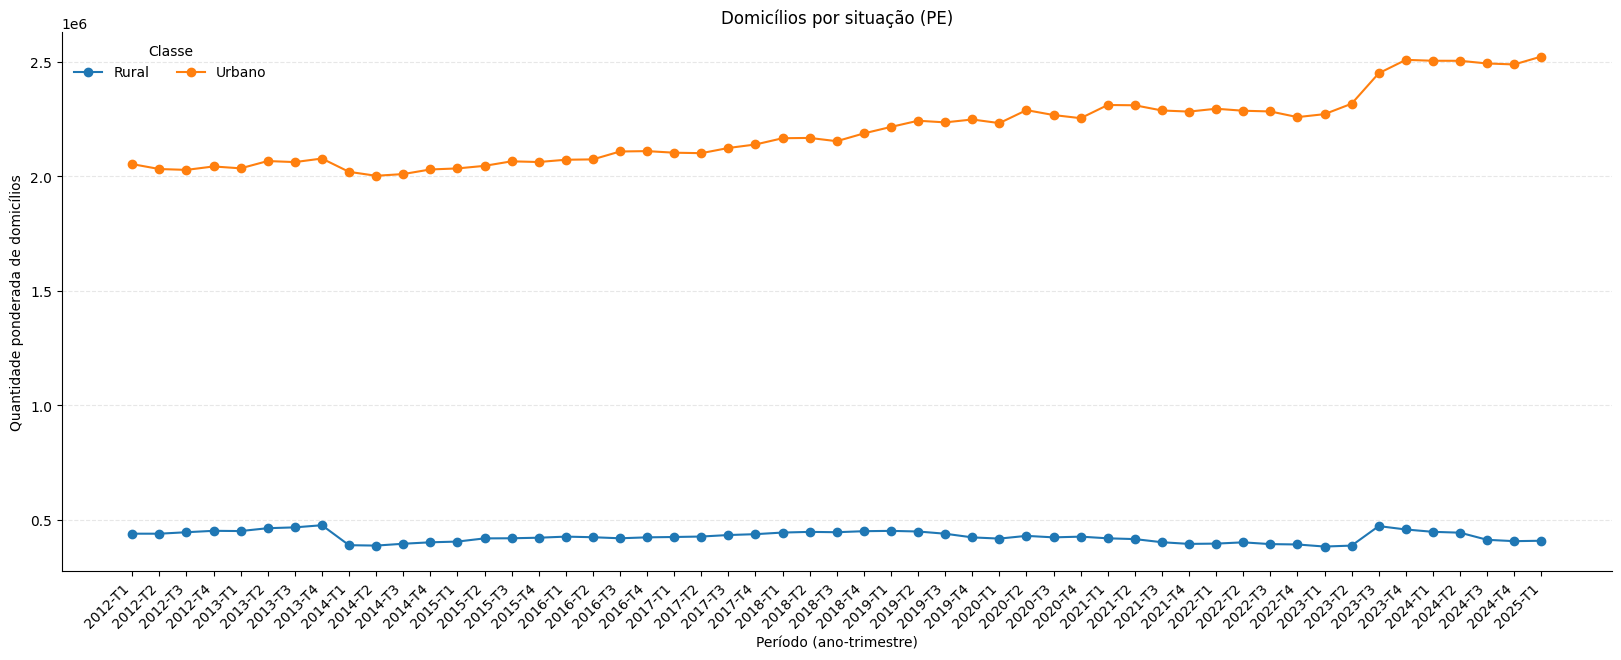

In [4]:
fig, ax = plot_multiline_pnade(
    df,
    class_col="v1022",
    class_labels={"1": "Urbano", "2": "Rural"},
    title="Domicílios por situação (PE)",
    xlabel="Período (ano-trimestre)",
    ylabel="Quantidade ponderada de domicílios",
    figsize=(20, 7)
)

In [3]:
from typing import Optional, Dict, Tuple, List
import polars as pl
import matplotlib.pyplot as plt
import numpy as np


def multiline_plot(
    df: pl.DataFrame | pl.LazyFrame,
    class_col: str,
    *,
    time_col: str = "ano_tri",
    weight_col: Optional[str] = None,
    prefer_weight_order: Tuple[str, ...] = ("peso_dom","v1032","v1031","v1027","v1028"),
    domicile_keys: Optional[Tuple[str, ...]] = None,
    class_labels: Optional[Dict[str, str]] = None,
    class_order: Optional[List[str]] = None,
    normalize: bool = False,
    drop_constant: bool = True,
    title: Optional[str] = None,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None,
    figsize: Tuple[float, float] = (11, 6),
    rotate_xticks: Optional[float] = 45,
):
    """
    Plota a evolução temporal ponderada por classe com ordenação temporal determinística (ano*4 + tri-1).
    """
    if isinstance(df, pl.LazyFrame):
        df = df.collect()
    cols = set(df.columns)
    if time_col not in cols:
        if "ano" in cols and "trimestre" in cols:
            df = df.with_columns((pl.col("ano").cast(pl.Utf8) + "-T" + pl.col("trimestre").cast(pl.Utf8)).alias("ano_tri"))
        else:
            raise ValueError("Coluna temporal ausente.")
    if class_col not in cols:
        raise ValueError(f"Coluna de classe '{class_col}' não encontrada.")
    if weight_col is None:
        for c in prefer_weight_order:
            if c in cols:
                weight_col = c
                break
        if weight_col is None:
            raise ValueError("Sem coluna de peso.")
    if domicile_keys is None:
        domicile_keys = ("upa","v1008","v1014") if "v1014" in cols else ("upa","v1008")
    for k in domicile_keys:
        if k not in cols:
            raise ValueError(f"Chave domiciliar '{k}' não encontrada.")

    df = df.with_columns(pl.col(time_col).cast(pl.Utf8).alias("__t"))
    df = df.with_columns([
        pl.col("__t").str.split("-T").list.get(0).cast(pl.Int32).alias("__ano"),
        pl.col("__t").str.split("-T").list.get(1).str.strip_chars().cast(pl.Int32).alias("__tri")
    ])
    df = df.with_columns((pl.col("__ano")*4 + (pl.col("__tri")-1)).alias("__tkey"))

    base = (
        df.select(["__tkey","__ano","__tri", time_col, class_col, weight_col, *domicile_keys])
          .filter(pl.col(class_col).is_not_null() & pl.col(weight_col).is_not_null())
          .group_by(["__tkey", "__ano", "__tri", time_col, class_col, *domicile_keys])
          .agg(pl.max(weight_col).alias("__peso_dom"))
          .select(["__tkey", "__ano", "__tri", time_col, class_col, "__peso_dom"])
    )

    agg = base.group_by(["__tkey", "__ano", "__tri", time_col, class_col]).agg(pl.sum("__peso_dom").alias("valor"))

    if class_labels:
        map_df = pl.DataFrame({"__raw": list(class_labels.keys()), "__lab": list(class_labels.values())})
        agg = (
            agg.with_columns(pl.col(class_col).cast(pl.Utf8).alias("__raw"))
               .join(map_df, on="__raw", how="left")
               .with_columns(pl.coalesce([pl.col("__lab"), pl.col("__raw")]).alias("__classe"))
               .drop(["__raw","__lab"])
        )
        cat_col = "__classe"
    else:
        cat_col = class_col

    if normalize:
        agg = agg.with_columns((pl.col("valor") / pl.sum("valor").over("__tkey") * 100).alias("valor"))
        ylab = "Percentual (%)"
    else:
        ylab = "Quantidade ponderada de domicílios"

    ord_df = agg.sort(["__tkey", cat_col])

    times = (ord_df.select(["__tkey","__ano","__tri", time_col])
                   .unique()
                   .sort("__tkey")
                   .to_dict(as_series=False))
    x_keys = times["__tkey"]
    x_labels = [f"{a}-T{t}" for a, t in zip(times["__ano"], times["__tri"])]

    classes = ord_df.select(cat_col).unique().to_series().to_list()
    if class_order:
        classes_sorted = [c for c in class_order if c in classes] + [c for c in classes if c not in set(class_order)]
    elif class_labels:
        desired = [class_labels[k] for k in class_labels if class_labels[k] in classes]
        classes_sorted = desired + [c for c in classes if c not in set(desired)]
    else:
        classes_sorted = sorted(classes, key=lambda x: str(x))

    fig, ax = plt.subplots(figsize=figsize)

    for c in classes_sorted:
        sub = (ord_df.filter(pl.col(cat_col) == c)
                     .select(["__tkey","valor"])
                     .to_dict(as_series=False))
        y = np.full(len(x_keys), np.nan, dtype=float)
        pos = {k:i for i,k in enumerate(x_keys)}
        for tk, val in zip(sub["__tkey"], sub["valor"]):
            y[pos[tk]] = float(val) if val is not None else np.nan
        if drop_constant:
            v = y[~np.isnan(y)]
            if v.size == 0 or np.allclose(v, v[0]):
                continue
        ax.plot(range(len(x_keys)), y, marker="o", label=str(c))

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xticks(range(len(x_keys)))
    ax.set_xticklabels(x_labels, rotation=rotate_xticks, ha="right" if rotate_xticks else "center")
    ax.set_title(title or "Evolução por classe (domicílios)")
    ax.set_xlabel(xlabel or "Período (ano-trimestre)")
    ax.set_ylabel(ylabel or ylab)
    ax.grid(True, linestyle="--", alpha=0.3, axis="y")
    ax.legend(title="Classe", frameon=False, ncol=2)
    fig.tight_layout()
    return fig, ax

In [ ]:
from typing import Optional, Dict, Tuple, List
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

def pie_plot(
    df: pl.DataFrame | pl.LazyFrame,
    class_col: str,
    *,
    weight_col: Optional[str] = None,
    prefer_weight_order: Tuple[str, ...] = ("peso_dom","v1032","v1031","v1027","v1028"),
    domicile_keys: Optional[Tuple[str, ...]] = None,
    class_labels: Optional[Dict[str, str]] = None,
    class_order: Optional[List[str]] = None,
    normalize: bool = True,
    top_k: Optional[int] = None,
    others_label: str = "Outros",
    title: Optional[str] = None,
    figsize: Tuple[float, float] = (7.5, 7.5),
    startangle: float = 90.0
):
    """
    Plota um gráfico de pizza ponderado a partir de uma coluna categórica.
    """
    if isinstance(df, pl.LazyFrame):
        df = df.collect()
    cols = set(dfa.columns)
    if class_col not in cols:
        raise ValueError(f"Coluna de classe '{class_col}' não encontrada.")
    if weight_col is None:
        for c in prefer_weight_order:
            if c in cols:
                weight_col = c
                break
        if weight_col is None:
            raise ValueError("Sem coluna de peso.")
    if domicile_keys is None:
        domicile_keys = tuple([k for k in ("upa","v1008","v1014") if k in cols]) or ("upa","v1008")
    for k in domicile_keys:
        if k not in cols:
            raise ValueError(f"Chave domiciliar '{k}' não encontrada.")
    base = (
        df.select([class_col, weight_col, *domicile_keys])
          .filter(pl.col(class_col).is_not_null() & pl.col(weight_col).is_not_null())
          .group_by([class_col, *domicile_keys])
          .agg(pl.max(weight_col).alias("__peso_dom"))
          .select([class_col, "__peso_dom"])
    )
    agg = base.group_by(class_col).agg(pl.sum("__peso_dom").alias("valor"))
    if class_labels:
        map_df = pl.DataFrame({"__raw": list(class_labels.keys()), "__lab": list(class_labels.values())})
        agg = (
            agg.with_columns(pl.col(class_col).cast(pl.Utf8).alias("__raw"))
               .join(map_df, on="__raw", how="left")
               .with_columns(pl.coalesce([pl.col("__lab"), pl.col("__raw")]).alias("__classe"))
               .drop(["__raw","__lab"])
        )
        cat_col = "__classe"
    else:
        agg = agg.with_columns(pl.col(class_col).cast(pl.Utf8).alias("__classe"))
        cat_col = "__classe"
    if normalize:
        tot = agg.select(pl.sum("valor")).item()
        agg = agg.with_columns((pl.col("valor")/pl.lit(tot)*100.0).alias("valor"))
    agg = agg.sort(by=["valor", cat_col], descending=[True, False])
    if top_k is not None and top_k > 0 and agg.height > top_k:
        head = agg.head(top_k)
        tail_sum = agg.slice(top_k).select(pl.sum("valor")).item()
        agg = pl.concat([
            head,
            pl.DataFrame({cat_col: [others_label], "valor": [tail_sum]})
        ])
    classes = agg.select(cat_col).to_series().to_list()
    if class_order:
        order_set = set(class_order)
        remaining = [c for c in classes if c not in order_set]
        classes_sorted = [c for c in class_order if c in classes] + remaining
        agg = agg.join(pl.DataFrame({cat_col: classes_sorted, "__ord": list(range(len(classes_sorted)))}), on=cat_col, how="left").sort("__ord").drop("__ord")
    labels = agg.select(cat_col).to_series().to_list()
    values = np.array(agg.select("valor").to_series().to_list(), dtype=float)
    fig, ax = plt.subplots(figsize=figsize)
    if normalize:
        wedges, texts, autotexts = ax.pie(values, labels=labels, startangle=startangle, autopct="%1.1f%%", counterclock=False)
    else:
        wedges, texts = ax.pie(values, labels=labels, startangle=startangle, counterclock=False)
    ax.axis("equal")
    ax.set_title(title or "Distribuição por classe (ponderado)")
    fig.tight_layout()
    return fig, ax

In [26]:
from typing import Optional, Dict, Tuple, List
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

def bar_count_by_class(
    df: pl.DataFrame | pl.LazyFrame,
    class_col: str,
    *,
    weight_col: Optional[str] = None,
    prefer_weight_order: Tuple[str, ...] = ("peso_dom","v1032","v1031","v1027","v1028"),
    domicile_keys: Optional[Tuple[str, ...]] = None,
    class_labels: Optional[Dict[str, str]] = None,
    class_order: Optional[List[str]] = None,
    normalize: bool = False,
    title: Optional[str] = None,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None,
    figsize: Tuple[float, float] = (9, 5),
    rotate_xticks: Optional[float] = 0.0,
):
    """
    Plota um gráfico de barras com a contagem (ponderada) por classe de uma coluna categórica.
    """
    if isinstance(df, pl.LazyFrame):
        df = df.collect()

    cols = set(df.columns)
    if class_col not in cols:
        raise ValueError(f"Coluna de classe '{class_col}' não encontrada.")

    if weight_col is None:
        for c in prefer_weight_order:
            if c in cols:
                weight_col = c
                break
        if weight_col is None:
            raise ValueError("Sem coluna de peso.")

    if domicile_keys is None:
        domicile_keys = tuple([k for k in ("upa","v1008","v1014") if k in cols]) or ("upa","v1008")
    for k in domicile_keys:
        if k not in cols:
            raise ValueError(f"Chave domiciliar '{k}' não encontrada.")

    base = (
        df.select([class_col, weight_col, *domicile_keys])
          .filter(pl.col(class_col).is_not_null() & pl.col(weight_col).is_not_null())
          .group_by([class_col, *domicile_keys])
          .agg(pl.max(weight_col).alias("__peso_dom"))
          .select([class_col, "__peso_dom"])
    )

    agg = base.group_by(class_col).agg(pl.sum("__peso_dom").alias("valor"))

    if class_labels:
        map_df = pl.DataFrame({"__raw": list(class_labels.keys()), "__lab": list(class_labels.values())})
        agg = (
            agg.with_columns(pl.col(class_col).cast(pl.Utf8).alias("__raw"))
               .join(map_df, on="__raw", how="left")
               .with_columns(pl.coalesce([pl.col("__lab"), pl.col("__raw")]).alias("__classe"))
               .drop(["__raw","__lab"])
        )
        cat_col = "__classe"
    else:
        agg = agg.with_columns(pl.col(class_col).cast(pl.Utf8).alias("__classe"))
        cat_col = "__classe"

    if normalize:
        tot = agg.select(pl.sum("valor")).item()
        agg = agg.with_columns((pl.col("valor")/pl.lit(tot)*100.0).alias("valor"))

    if class_order:
        order_df = pl.DataFrame({cat_col: list(class_order)}).with_row_count("__ord")
        agg = (agg.join(order_df, on=cat_col, how="left")
                  .with_columns(pl.col("__ord").fill_null(1e9))
                  .sort([pl.col("__ord"), pl.col("valor").rank("ordinal")])
                  .drop("__ord"))
    else:
        agg = agg.sort([cat_col])

    labels = agg.select(cat_col).to_series().to_list()
    values = np.array(agg.select("valor").to_series().to_list(), dtype=float)

    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(range(len(labels)), values)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=rotate_xticks if rotate_xticks is not None else 0,
                       ha="right" if rotate_xticks else "center")
    ax.set_title(title or "Contagem por classe (ponderada)")
    ax.set_xlabel(xlabel or "Classe")
    ax.set_ylabel(ylabel or ("Percentual (%)" if normalize else "Quantidade ponderada"))
    ax.grid(True, axis="y", linestyle="--", alpha=0.3)
    fig.tight_layout()
    return fig, ax

In [5]:
VARDICT_TRABALHO_BASICO = {
    "vd4001_c": {
        "1": "Na força de trabalho",
        "2": "Fora da força de trabalho"
    },
    "vd4002_c": {
        "1": "Ocupada",
        "2": "Desocupada"
    },
    'v4012_c': {
        "1": "Trabalhador doméstico",
        "2":"Militar",
        "3":"Setor privado",
        "4":"Setor público",
        "5":"Empregador",
        "6":"Conta própria",
        "7":"Não remunerado"
    },
    'vd4036_faixa_horas': {
        "1": "Até 14 horas",
        "2": "15 a 39 horas",
        "3": "40 a 44 horas",
        "4": "45 a 48 horas",
        "5": "49 horas ou mais"
    }
}

# Situação de trabalho

## Linha

- Qual é o número de pessoas na força de trabalho e fora dela em cada trimestre?
- O total de trabalhadores ativos (ocupados + desocupados) tem aumentado ou diminuído?
- O número de pessoas fora da força de trabalho mostra tendência de alta ou estabilidade?
- Em quais trimestres há maior distância entre as duas curvas?
- Há pontos de inflexão (mudança de tendência) nas séries ao longo do tempo?
- O gráfico indica crescimento da participação no mercado de trabalho (expansão da força laboral)?
- A diferença entre os dois grupos está se ampliando ou reduzindo com o tempo?
- Existe sazonalidade na entrada ou saída de pessoas da força de trabalho (por exemplo, variações em períodos de colheita, fim de ano ou início de ciclos letivos)?
- As curvas sugerem correlação inversa (quando um cresce, o outro cai)?
- A proporção de pessoas fora da força de trabalho reflete envelhecimento populacional ou retração econômica?

## Pizza / Barras

- Quantas pessoas estão na força de trabalho e fora dela no período observado?
- Qual grupo é maior em termos absolutos?
- Qual é a proporção entre pessoas na força de trabalho e fora dela?
- O número total de pessoas consideradas na amostra é compatível com a população em idade de trabalhar estimada?
- Qual é o peso relativo de cada grupo (porcentagem do total)?
- A diferença entre força de trabalho e população fora dela é grande ou pequena, em termos relativos?
- O tamanho da força de trabalho indica alta taxa de participação ou baixa inserção laboral?

In [28]:
dataset_path = "datasets/PNAD_2_.parquet"

query = """
SELECT
  TRY_CAST(ano AS INTEGER) AS ano,
  TRY_CAST(trimestre AS INTEGER) AS trimestre,
  CAST(ano AS VARCHAR) || '-T' || CAST(trimestre AS VARCHAR) AS ano_tri,
  CAST(uf AS INTEGER) AS uf,
  upa,
  v1008,
  v1014,
  COALESCE(CAST(v1027 AS DOUBLE), CAST(v1028 AS DOUBLE)) AS peso_dom,

  CASE WHEN TRY_CAST(vd4001 AS INTEGER) IN (1,2) THEN TRY_CAST(vd4001 AS INTEGER) END AS vd4001_c

FROM bronze.ibge__pnadctri
WHERE CAST(uf AS INTEGER) = 26;
"""

if not os.path.exists(dataset_path):
    s3_url = "s3://observatorio-trabalho-pe-ds-resources-dev/"

    df = query_athena_to_polars(
        query,
        s3_url,
        lazy_mode=False
    )

    df.write_parquet(dataset_path)

else:
    df = pl.read_parquet(dataset_path)

C:\Users\RafaelMarinh_5k9komz\AppData\Local\Temp\ipykernel_26504\3725871730.py:74: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  order_df = pl.DataFrame({cat_col: list(class_order)}).with_row_count("__ord")


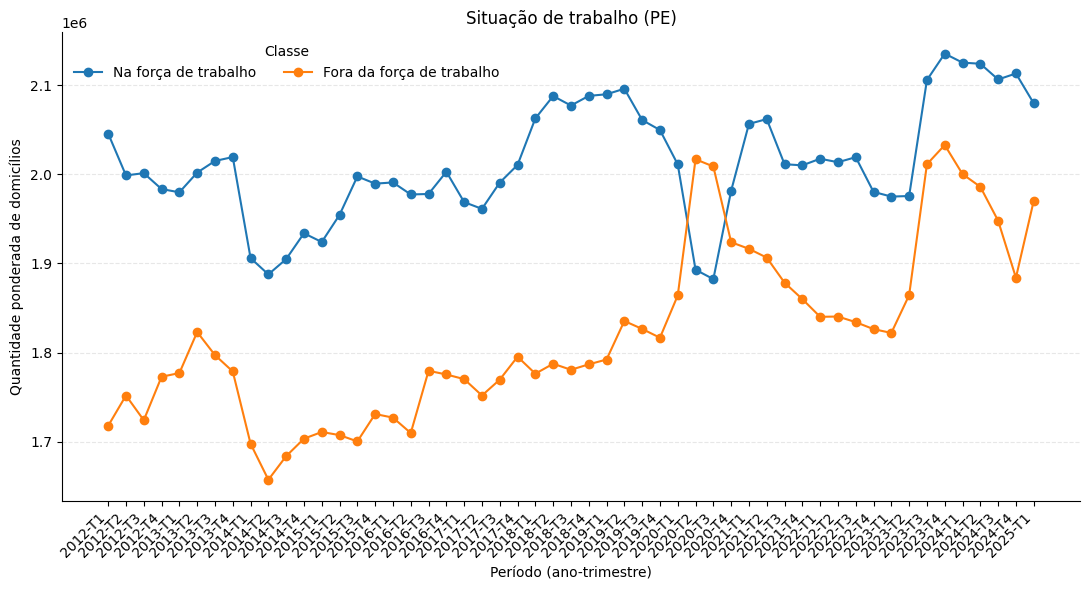

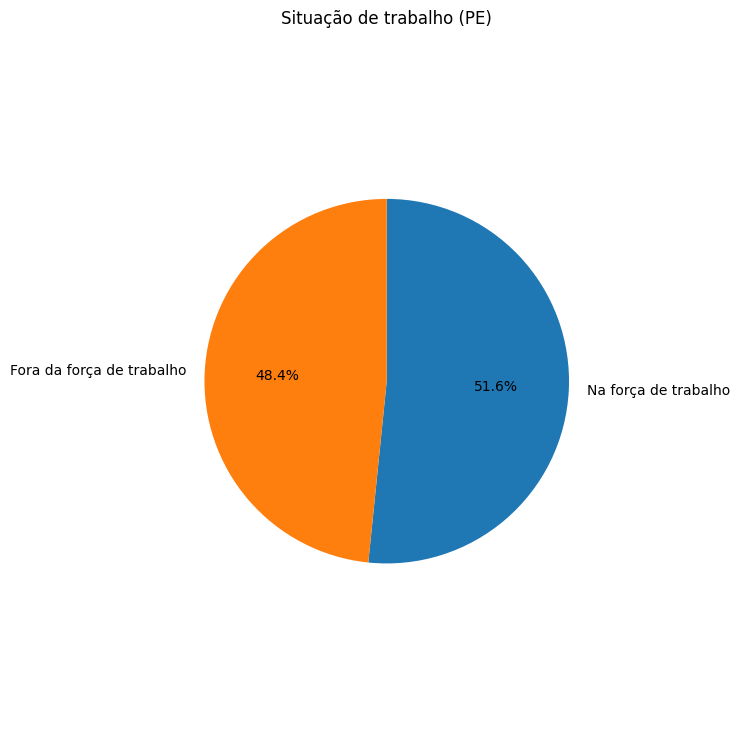

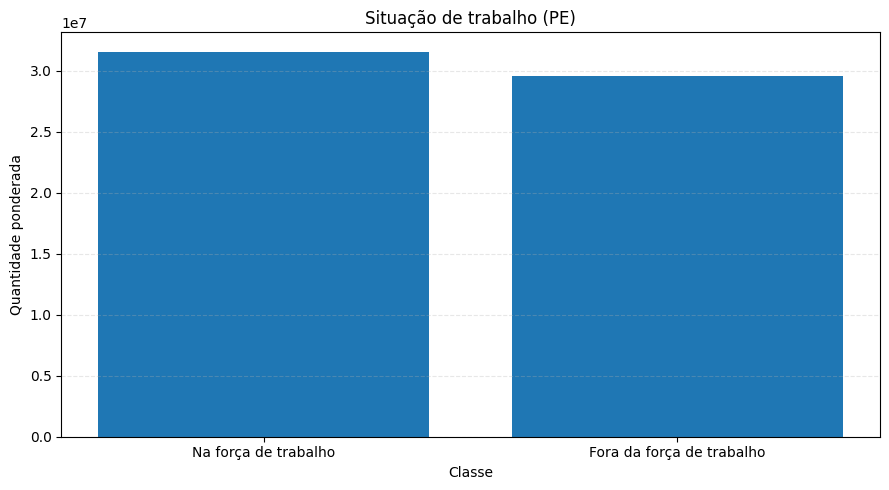

In [29]:
fig, ax = multiline_plot(
    df, class_col="vd4001_c",
    class_labels=VARDICT_TRABALHO_BASICO["vd4001_c"],
    class_order=VARDICT_TRABALHO_BASICO["vd4001_c"].values(),
    title="Situação de trabalho (PE)"
)
fig, ax = pie_plot(
    df, class_col="vd4001_c",
    class_labels=VARDICT_TRABALHO_BASICO["vd4001_c"],
    class_order=VARDICT_TRABALHO_BASICO["vd4001_c"].values(),
    title="Situação de trabalho (PE)"
)
fig, ax = bar_count_by_class(
    df, class_col="vd4001_c",
    class_labels=VARDICT_TRABALHO_BASICO["vd4001_c"],
    class_order=VARDICT_TRABALHO_BASICO["vd4001_c"].values(),
    title="Situação de trabalho (PE)"
)

# Situação de trabalho (PE)

## Linha

- Qual é o número de pessoas ocupadas e desocupadas em cada trimestre em Pernambuco?
- Em quais trimestres há aumento do número de ocupados?
- Quando o número de desocupados cresce mais fortemente?
- O volume total da força de trabalho (ocupados + desocupados) se mantém estável ou varia ao longo do tempo?
- Qual é a distância entre as duas curvas (ocupados vs. desocupados) em cada trimestre?
- Há picos ou vales visíveis nas séries, indicando períodos de maior ou menor atividade econômica?
- O gráfico indica recuperação do emprego (crescimento dos ocupados e queda dos desocupados)?
- As curvas mostram movimento oposto (quando o desemprego cai, o emprego sobe)?
- A variação da ocupação é mais intensa que a da desocupação — ou vice-versa?
- Existe sazonalidade no comportamento das séries (ex.: aumento de ocupações em determinados trimestres do ano)?
- A diferença entre ocupados e desocupados tem se ampliado ou reduzido ao longo dos trimestres?
- Há períodos de estabilidade simultânea, sugerindo um mercado de trabalho em equilíbrio temporário?

## Pizza / Barras

- Quantas pessoas estão ocupadas e quantas estão desocupadas no período analisado?
- Qual grupo é maior em termos absolutos?
- Qual é a proporção de desocupados dentro da força de trabalho?
- Qual é a diferença numérica entre ocupados e desocupados?
- O total da força de trabalho é de quantas pessoas no período observado?
- A proporção de desocupados indica um nível de desemprego alto, moderado ou baixo?
- O gráfico sugere estabilidade ou desequilíbrio entre os grupos (ocupados vs. desocupados)?
- A diferença entre os dois grupos é coerente com a taxa de desocupação histórica do estado?

In [30]:
dataset_path = "datasets/PNAD_3_.parquet"

query = """
SELECT
  TRY_CAST(ano AS INTEGER) AS ano,
  TRY_CAST(trimestre AS INTEGER) AS trimestre,
  CAST(ano AS VARCHAR) || '-T' || CAST(trimestre AS VARCHAR) AS ano_tri,
  CAST(uf AS INTEGER) AS uf,
  upa,
  v1008,
  v1014,
  COALESCE(CAST(v1027 AS DOUBLE), CAST(v1028 AS DOUBLE)) AS peso_dom,

  CASE WHEN TRY_CAST(vd4002 AS INTEGER) IN (1,2) THEN TRY_CAST(vd4002 AS INTEGER) END AS vd4002_c

FROM bronze.ibge__pnadctri
WHERE CAST(uf AS INTEGER) = 26;
"""

if not os.path.exists(dataset_path):
    s3_url = "s3://observatorio-trabalho-pe-ds-resources-dev/"

    df = query_athena_to_polars(
        query,
        s3_url,
        lazy_mode=False
    )

    df.write_parquet(dataset_path)

else:
    df = pl.read_parquet(dataset_path)

C:\Users\RafaelMarinh_5k9komz\AppData\Local\Temp\ipykernel_26504\3725871730.py:74: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  order_df = pl.DataFrame({cat_col: list(class_order)}).with_row_count("__ord")


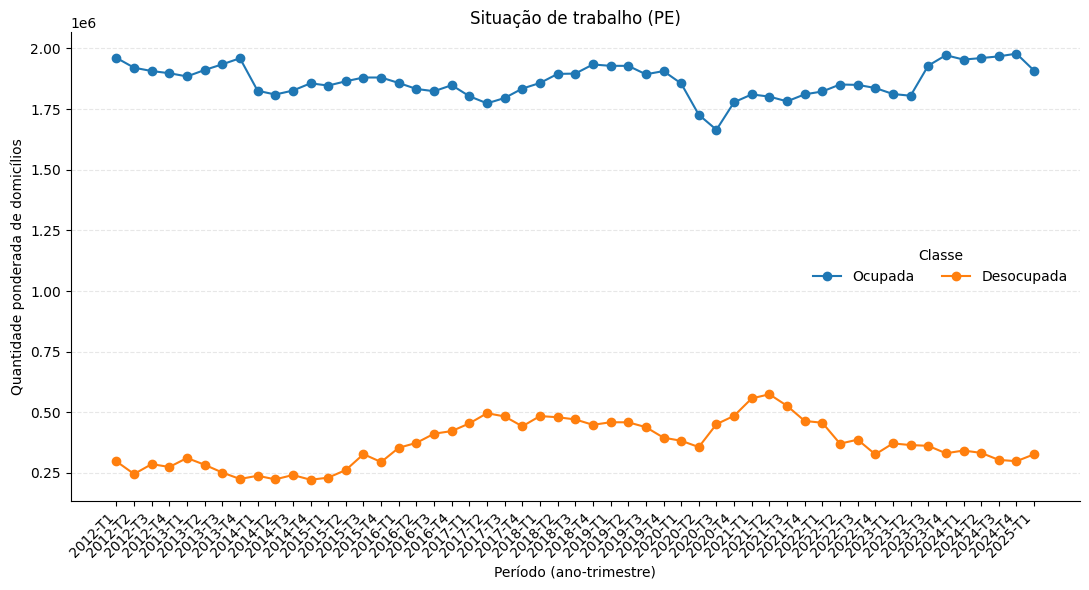

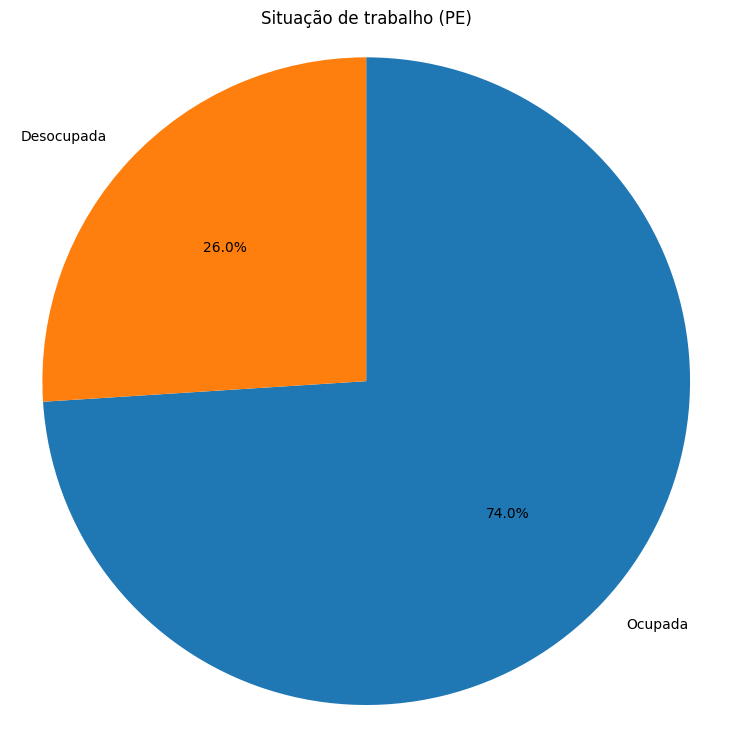

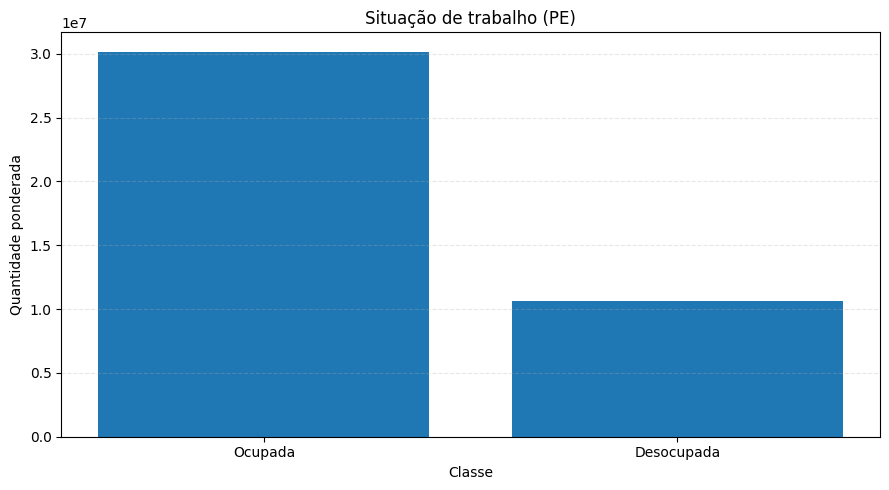

In [31]:
fig, ax = multiline_plot(
    df, class_col="vd4002_c",
    class_labels=VARDICT_TRABALHO_BASICO["vd4002_c"],
    class_order=VARDICT_TRABALHO_BASICO["vd4002_c"].values(),
    title="Situação de trabalho (PE)"
)
fig, ax = pie_plot(
    df, class_col="vd4002_c",
    class_labels=VARDICT_TRABALHO_BASICO["vd4002_c"],
    class_order=VARDICT_TRABALHO_BASICO["vd4002_c"].values(),
    title="Situação de trabalho (PE)"
)
fig, ax = bar_count_by_class(
    df, class_col="vd4002_c",
    class_labels=VARDICT_TRABALHO_BASICO["vd4002_c"],
    class_order=VARDICT_TRABALHO_BASICO["vd4002_c"].values(),
    title="Situação de trabalho (PE)"
)

# Tipo de ocupação

## Linha

- Qual é o número de trabalhadores em cada tipo de ocupação em cada trimestre?
- Quais categorias possuem maior participação no total de ocupados?
- Em quais trimestres houve crescimento ou queda em cada tipo de ocupação?
- Qual categoria apresenta maior variação absoluta ou relativa ao longo do período?
- Existem mudanças de posição entre as categorias (ex.: uma ultrapassando outra em volume de ocupados)?
- Quais tipos de ocupação crescem de forma consistente, indicando expansão setorial (ex.: conta própria, doméstico)?
- Alguma categoria mostra tendência de retração, sinalizando mudança estrutural no mercado de trabalho?
- A participação relativa dos empregados com carteira assinada tem se reduzido ou aumentado ao longo dos trimestres?
- Há aumento do trabalho por conta própria em períodos de crise, sugerindo informalização?
- O comportamento dos trabalhadores domésticos reflete efeitos de políticas públicas, como mudanças na legislação trabalhista?
- Existem padrões sazonais (ex.: aumento temporário de militares ou trabalhadores públicos em determinados períodos)?

## Pizza / Barras

- Quantos trabalhadores existem em cada tipo de ocupação (empregado com carteira, sem carteira, conta própria, doméstico, militar, empregador etc.)?
- Qual é o tipo de ocupação mais comum em Pernambuco no período analisado?
- Quais categorias têm menor número de trabalhadores?
- Qual é a proporção de trabalhadores formais vs. informais?
- O número total de ocupados é dominantemente concentrado em poucas categorias ou distribuído de forma equilibrada?
- O predomínio de determinadas categorias (ex.: conta própria) sugere tendência de informalização ou empreendedorismo de necessidade?
- A elevada participação de empregados com carteira reflete mercado formal consolidado ou recuperação recente de empregos regulares?
- A presença de um número expressivo de trabalhadores domésticos pode indicar persistência de ocupações de baixa remuneração e vulnerabilidade?
- O padrão observado reflete mudanças estruturais pós-crise, novas formas de trabalho (autônomo, plataformas digitais) ou rigidez institucional?
- As diferenças entre categorias podem orientar políticas de formalização, capacitação ou estímulo ao empreendedorismo?

In [46]:
dataset_path = "datasets/PNAD_4_.parquet"

query = """
SELECT
  TRY_CAST(ano AS INTEGER) AS ano,
  TRY_CAST(trimestre AS INTEGER) AS trimestre,
  CAST(ano AS VARCHAR) || '-T' || CAST(trimestre AS VARCHAR) AS ano_tri,
  CAST(uf AS INTEGER) AS uf,
  upa,
  v1008,
  v1014,
  COALESCE(CAST(v1027 AS DOUBLE), CAST(v1028 AS DOUBLE)) AS peso_dom,

  TRY_CAST(v4012 AS INTEGER) AS v4012_c

FROM bronze.ibge__pnadctri
WHERE CAST(uf AS INTEGER) = 26;
"""

if not os.path.exists(dataset_path):
    s3_url = "s3://observatorio-trabalho-pe-ds-resources-dev/"

    df = query_athena_to_polars(
        query,
        s3_url,
        lazy_mode=False
    )

    df.write_parquet(dataset_path)

else:
    df = pl.read_parquet(dataset_path)

C:\Users\RafaelMarinh_5k9komz\AppData\Local\Temp\ipykernel_26504\3725871730.py:74: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  order_df = pl.DataFrame({cat_col: list(class_order)}).with_row_count("__ord")


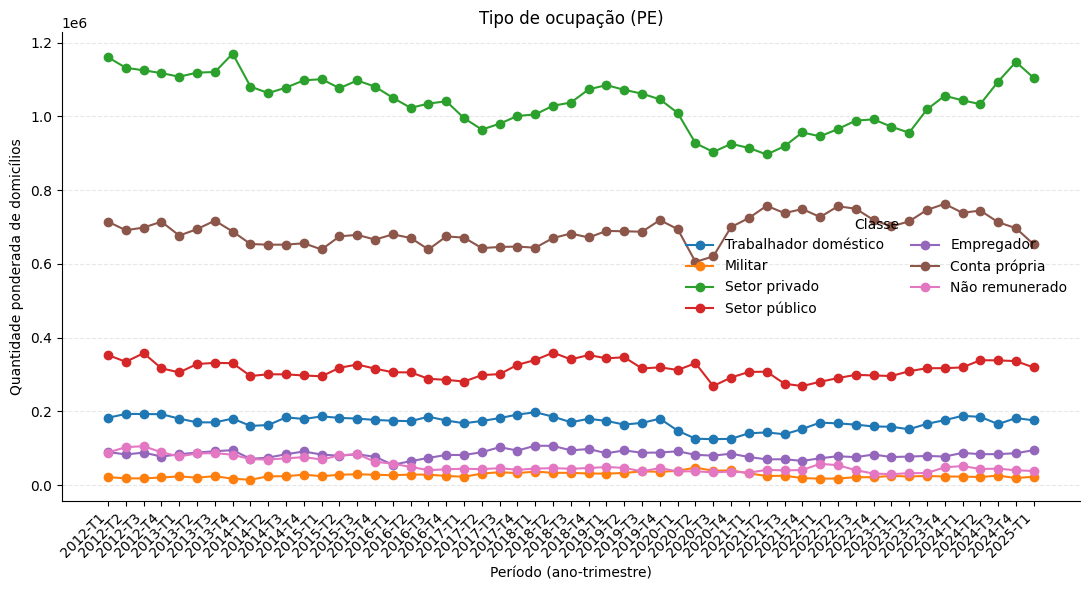

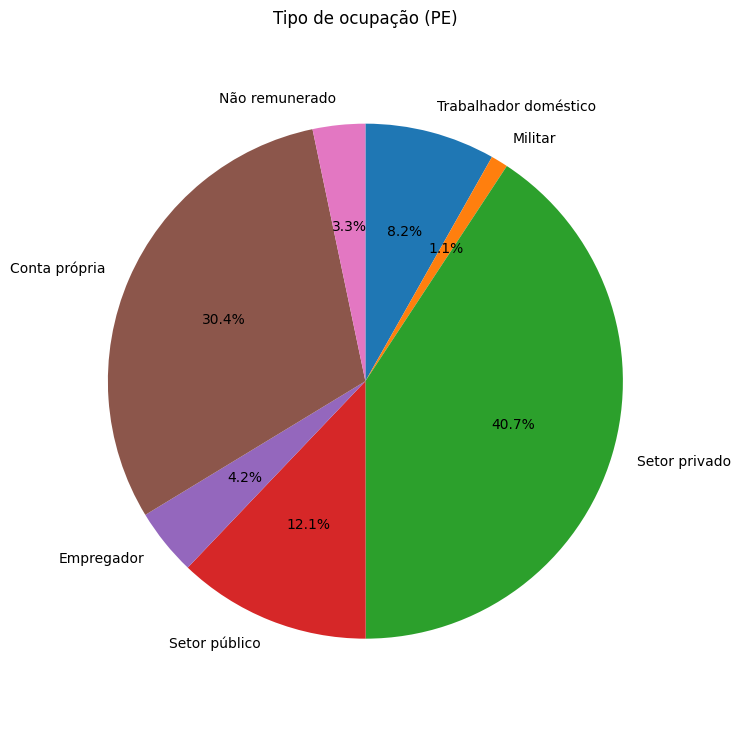

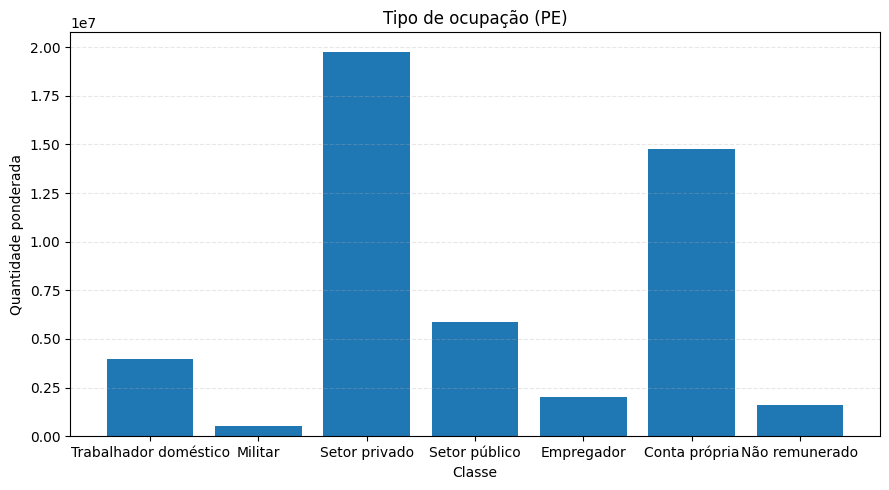

In [33]:
fig, ax = multiline_plot(
    df, class_col="v4012_c",
    class_labels=VARDICT_TRABALHO_BASICO["v4012_c"],
    class_order=VARDICT_TRABALHO_BASICO["v4012_c"].values(),
    title="Tipo de ocupação (PE)"
)
fig, ax = pie_plot(
    df, class_col="v4012_c",
    class_labels=VARDICT_TRABALHO_BASICO["v4012_c"],
    class_order=VARDICT_TRABALHO_BASICO["v4012_c"].values(),
    title="Tipo de ocupação (PE)"
)
fig, ax = bar_count_by_class(
    df, class_col="v4012_c",
    class_labels=VARDICT_TRABALHO_BASICO["v4012_c"],
    class_order=VARDICT_TRABALHO_BASICO["v4012_c"].values(),
    title="Tipo de ocupação (PE)"
)

# Quantidade de trabalhadores por CNAE

- Quantos trabalhadores havia em cada setor econômico (CNAE) em cada trimestre?
- Quais setores concentram o maior número absoluto de trabalhadores?
- Quais setores apresentam crescimento contínuo na ocupação ao longo do tempo?
- Há setores em declínio, com perda de trabalhadores?
- Existem picos ou quedas sazonais (por exemplo, aumento temporário em agricultura, comércio ou construção)?
- Em algum trimestre há mudança de posição entre setores (um ultrapassa outro em número de ocupados)?
- Quais setores lideram a geração de empregos e quais perdem participação ao longo dos trimestres?
- A evolução setorial indica diversificação econômica ou dependência de poucos setores empregadores?
- O padrão de crescimento é uniforme entre setores ou há segmentos com forte volatilidade?
- Há correlação entre variações sazonais e o ciclo econômico estadual (ex.: turismo, safra, construção civil)?
- Quais setores demonstram resiliência frente a crises (mantêm níveis de emprego estáveis)?
- O crescimento de determinados setores ocorre paralelamente à retração de outros, sugerindo recomposição da estrutura produtiva?

In [16]:
dataset_path = "datasets/PNAD_5_.parquet"

query = """
SELECT
  TRY_CAST(ano AS INTEGER) AS ano,
  TRY_CAST(trimestre AS INTEGER) AS trimestre,
  CAST(ano AS VARCHAR) || '-T' || CAST(trimestre AS VARCHAR) AS ano_tri,
  CAST(uf AS INTEGER) AS uf,
  upa,
  v1008,
  v1014,
  COALESCE(CAST(v1027 AS DOUBLE), CAST(v1028 AS DOUBLE)) AS peso_dom,

  CAST(NULLIF(CAST(v4013 AS VARCHAR), '') AS VARCHAR) AS v4013_cnae

FROM bronze.ibge__pnadctri
WHERE CAST(uf AS INTEGER) = 26;
"""

if not os.path.exists(dataset_path):
    s3_url = "s3://observatorio-trabalho-pe-ds-resources-dev/"

    df = query_athena_to_polars(
        query,
        s3_url,
        lazy_mode=False
    )

    df.write_parquet(dataset_path)

else:
    df = pl.read_parquet(dataset_path)

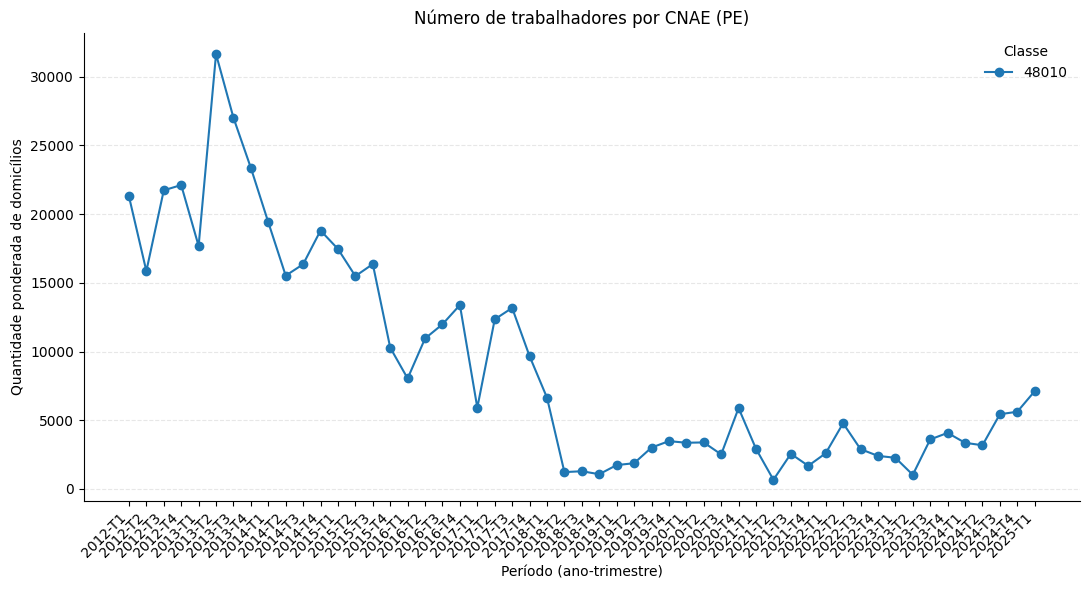

In [17]:
fig, ax = multiline_plot(
    df.filter(pl.col("v4013_cnae") == '48010'), class_col="v4013_cnae",
    class_labels={},
    class_order={}.values(),
    title="Número de trabalhadores por CNAE (PE)"
)

# Quantidade de trabalhadores por CBO

- Qual é o número de trabalhadores em cada grupo ocupacional (CBO) em cada trimestre?
- Quais ocupações possuem maior contingente de trabalhadores no estado?
- Quais ocupações apresentam crescimento consistente ao longo dos trimestres?
- Há ocupações em declínio, com perda de representatividade?
- Existem picos ou quedas sazonais em determinadas ocupações (por exemplo, trabalhadores agrícolas, comerciários, temporários)?
- Em algum trimestre, alguma ocupação ultrapassa outra em volume de emprego?
- Quais ocupações são mais dinâmicas (variações frequentes de crescimento e queda)?
- O gráfico revela expansão de ocupações de alta qualificação (ex.: analistas, técnicos) ou de baixa qualificação (ex.: auxiliares, operários)?
- Há movimentos estruturais indicando substituição de certos tipos de ocupação por outros (ex.: administrativos → técnicos)?
- As tendências por CBO estão alinhadas às tendências setoriais (CNAE) vistas em outros gráficos?
- O comportamento das ocupações indica maior formalização, terceirização ou precarização do mercado de trabalho?
- Quais ocupações mostram maior resiliência a choques econômicos (mantêm estabilidade mesmo em períodos de retração)?

In [18]:
dataset_path = "datasets/PNAD_6_.parquet"

query = """
SELECT
  TRY_CAST(ano AS INTEGER) AS ano,
  TRY_CAST(trimestre AS INTEGER) AS trimestre,
  CAST(ano AS VARCHAR) || '-T' || CAST(trimestre AS VARCHAR) AS ano_tri,
  CAST(uf AS INTEGER) AS uf,
  upa,
  v1008,
  v1014,
  COALESCE(CAST(v1027 AS DOUBLE), CAST(v1028 AS DOUBLE)) AS peso_dom,

  CAST(NULLIF(CAST(v4010 AS VARCHAR), '') AS VARCHAR) AS v4010_cbo

FROM bronze.ibge__pnadctri
WHERE CAST(uf AS INTEGER) = 26;
"""

if not os.path.exists(dataset_path):
    s3_url = "s3://observatorio-trabalho-pe-ds-resources-dev/"

    df = query_athena_to_polars(
        query,
        s3_url,
        lazy_mode=False
    )

    df.write_parquet(dataset_path)

else:
    df = pl.read_parquet(dataset_path)

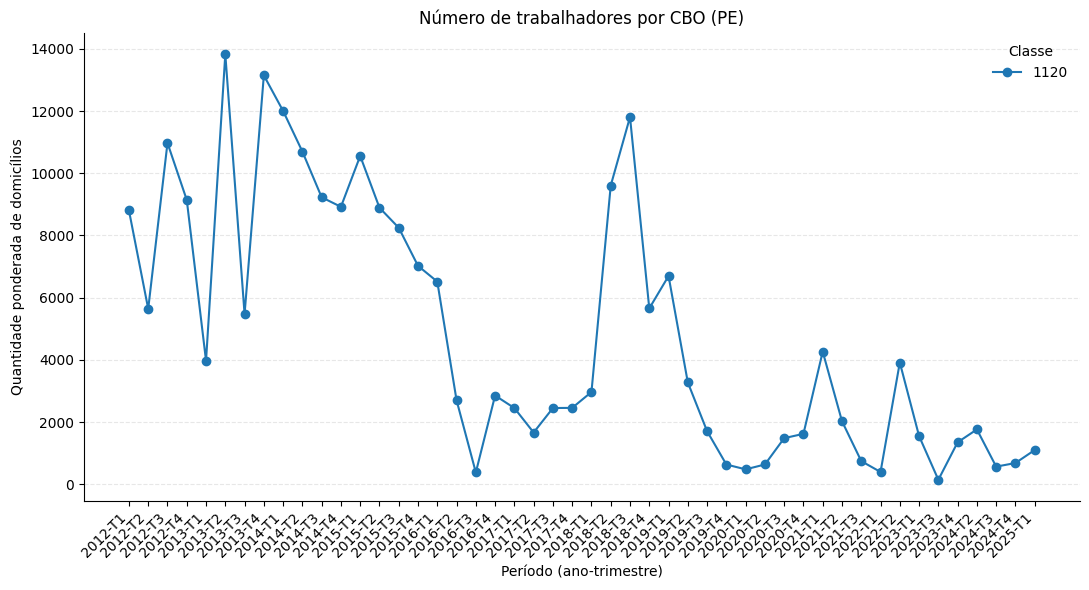

In [19]:
fig, ax = multiline_plot(
    df.filter(pl.col("v4010_cbo") == '1120'), class_col="v4010_cbo",
    class_labels={},
    class_order={}.values(),
    title="Número de trabalhadores por CBO (PE)"
)

# Número de trabalhadores por faixa de horas trabalhadas

## Linha

- Quantos trabalhadores atuam em cada faixa de horas semanais (ex.: até 14h, 15–39h, 40–44h, 45h ou mais) em cada trimestre?
- Qual é a faixa de jornada mais comum entre os trabalhadores pernambucanos?
- Há crescimento ou redução do número de trabalhadores em jornadas completas (ex.: 40–44h)?
- Em quais trimestres aumentam os trabalhadores em jornadas parciais (indicando subocupação)?
- Há variações sazonais (ex.: aumento temporário de trabalho parcial em determinados períodos)?
- Alguma faixa ultrapassa outra em volume ao longo do tempo?
- O gráfico indica formalização (crescimento das jornadas completas) ou precarização (aumento das jornadas reduzidas)?
- Há tendência de subutilização da força de trabalho, com expansão das faixas de menos horas trabalhadas?
- As faixas de jornada acompanhadas de crescimento do emprego formal (em CNAE/CBO) sugerem melhora da qualidade do emprego?
- O aumento das jornadas longas (45h+) pode indicar excesso de carga de trabalho em setores específicos?
- A redução nas jornadas médias pode refletir políticas de flexibilização, informalidade ou mudanças no perfil setorial?
- Existe sincronia entre as variações de jornada e as oscilações da ocupação total observadas em outros gráficos?

## Pizza / Barras

- Quantos trabalhadores estão em cada faixa de horas semanais no período analisado?
- Qual é a faixa de jornada mais comum entre os trabalhadores pernambucanos?
- Qual é o número total de trabalhadores em jornadas completas (ex.: 40–44h), reduzidas ou excessivas (45h+)?
- Há grande diferença entre as faixas intermediárias e extremas (muito poucas ou muitas horas)?
- Qual a proporção relativa de trabalhadores em tempo integral versus parcial?
- O gráfico sugere predomínio de vínculos formais (jornadas completas) ou precarizados (jornadas reduzidas)?
- A presença significativa de jornadas menores que 40h indica subocupação ou flexibilização do trabalho?
- Há polarização — concentração nas faixas extremas (poucas ou muitas horas) — indicando desigualdade nas condições de emprego?
- A proporção de trabalhadores com carga horária reduzida é compatível com a taxa de desocupação (pode indicar subutilização)?

In [34]:
dataset_path = "datasets/PNAD_7_.parquet"

query = """
SELECT
  TRY_CAST(ano AS INTEGER) AS ano,
  TRY_CAST(trimestre AS INTEGER) AS trimestre,
  CAST(ano AS VARCHAR) || '-T' || CAST(trimestre AS VARCHAR) AS ano_tri,
  CAST(uf AS INTEGER) AS uf,
  upa,
  v1008,
  v1014,
  COALESCE(CAST(v1027 AS DOUBLE), CAST(v1028 AS DOUBLE)) AS peso_dom,

  TRY_CAST(vd4036 AS INTEGER) AS vd4036_faixa_horas

FROM bronze.ibge__pnadctri
WHERE CAST(uf AS INTEGER) = 26;
"""

if not os.path.exists(dataset_path):
    s3_url = "s3://observatorio-trabalho-pe-ds-resources-dev/"

    df = query_athena_to_polars(
        query,
        s3_url,
        lazy_mode=False
    )

    df.write_parquet(dataset_path)

else:
    df = pl.read_parquet(dataset_path)

C:\Users\RafaelMarinh_5k9komz\AppData\Local\Temp\ipykernel_26504\3725871730.py:74: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  order_df = pl.DataFrame({cat_col: list(class_order)}).with_row_count("__ord")


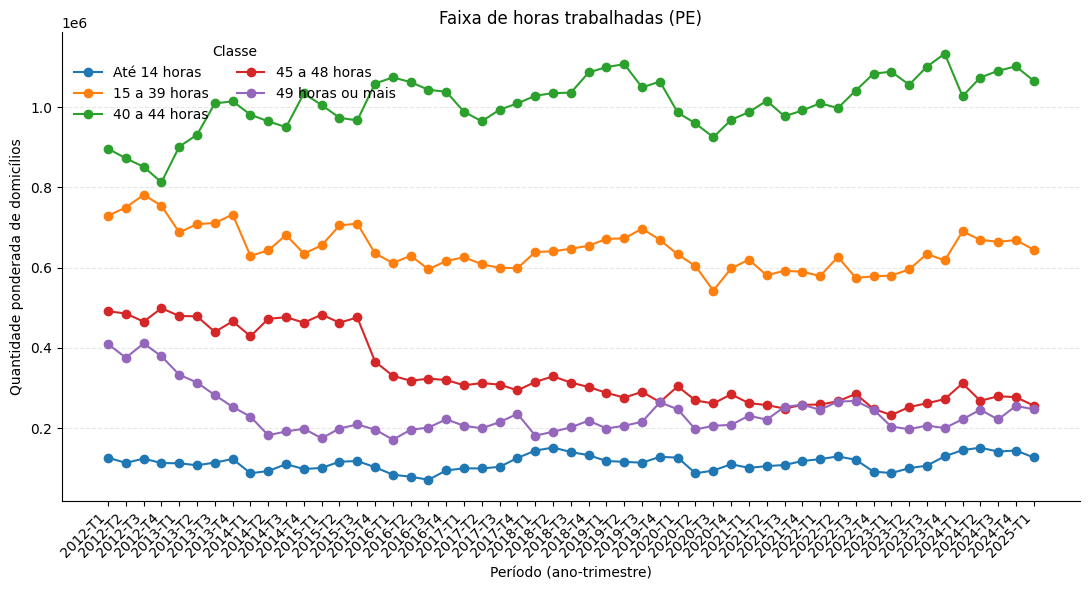

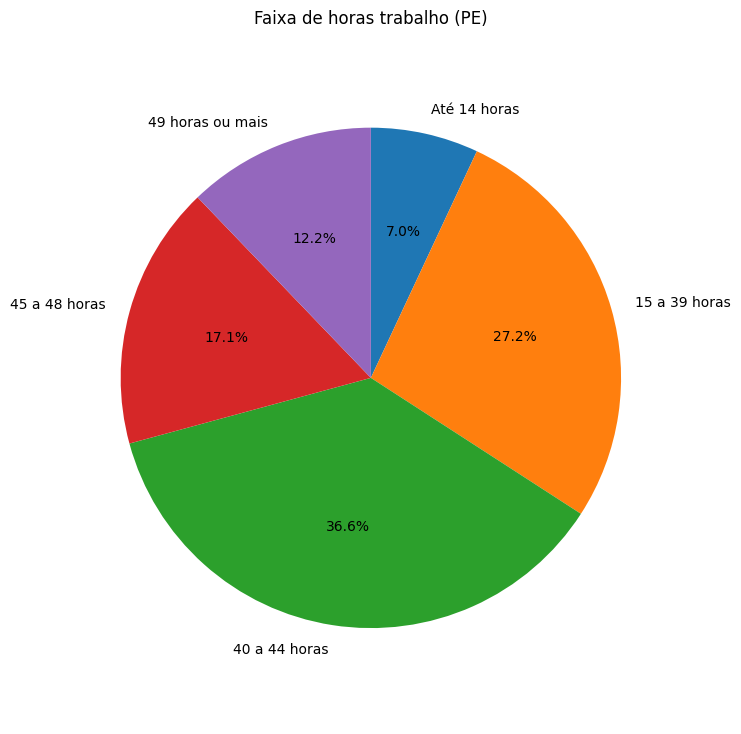

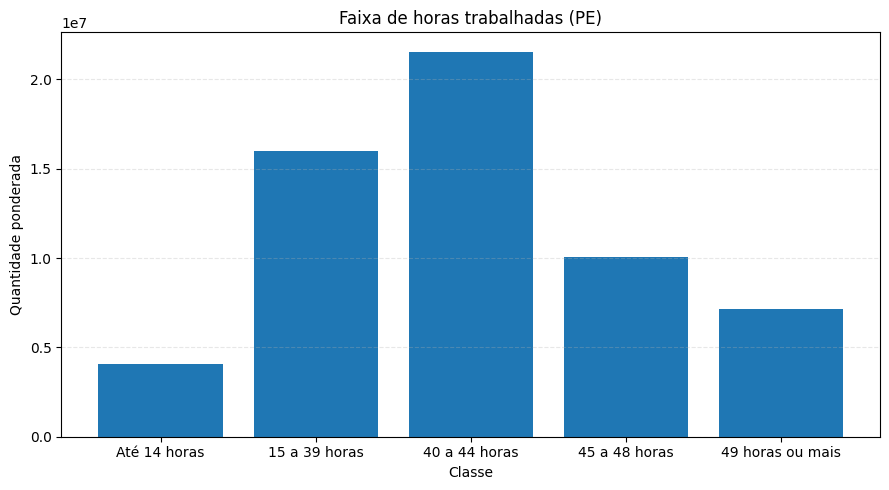

In [35]:
fig, ax = multiline_plot(
    df, class_col="vd4036_faixa_horas",
    class_labels=VARDICT_TRABALHO_BASICO["vd4036_faixa_horas"],
    class_order=VARDICT_TRABALHO_BASICO["vd4036_faixa_horas"].values(),
    title="Faixa de horas trabalhadas (PE)"
)
fig, ax = pie_plot(
    df, class_col="vd4036_faixa_horas",
    class_labels=VARDICT_TRABALHO_BASICO["vd4036_faixa_horas"],
    class_order=VARDICT_TRABALHO_BASICO["vd4036_faixa_horas"].values(),
    title="Faixa de horas trabalho (PE)"
)
fig, ax = bar_count_by_class(
    df, class_col="vd4036_faixa_horas",
    class_labels=VARDICT_TRABALHO_BASICO["vd4036_faixa_horas"],
    class_order=VARDICT_TRABALHO_BASICO["vd4036_faixa_horas"].values(),
    title="Faixa de horas trabalhadas (PE)"
)

# Rendimento médio mensal

- Qual é o rendimento médio mensal de cada tipo de ocupação em cada trimestre?
- Quais tipos de ocupação possuem maiores e menores rendimentos?
- As curvas mostram tendência de crescimento, estabilidade ou queda nos rendimentos?
- Há momentos de inflexão — aumento ou redução significativa em determinado trimestre?
- Em algum período, a diferença entre ocupações se ampliou ou diminuiu?
- O gráfico indica aumento das desigualdades salariais entre tipos de ocupação ao longo do tempo?
- Os empregados com carteira mantêm rendimentos consistentemente superiores aos sem carteira?
- O rendimento dos conta própria acompanha o dos empregados formais ou se distancia com o tempo?
- Os militares e servidores públicos têm comportamento salarial mais estável que as demais categorias?
- Há padrões sazonais — por exemplo, quedas nos rendimentos em determinados trimestres do ano?
- O crescimento de renda é homogêneo entre as categorias ou concentrado em poucos grupos?
- A evolução dos rendimentos está alinhada à variação da ocupação total (crescimento do emprego formal impulsiona salários)?

In [24]:
from typing import Optional, Dict, Tuple, List
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

def line_mean_by_quarter_grouped(
    df: pl.DataFrame | pl.LazyFrame,
    value_col: str,
    group_col: str,
    *,
    time_col: str = "ano_tri",
    weight_col: Optional[str] = None,
    prefer_weight_order: Tuple[str, ...] = ("v1032","v1031","peso_dom","v1027","v1028"),
    domicile_keys: Optional[Tuple[str, ...]] = None,
    class_labels: Optional[Dict[str, str]] = None,
    class_order: Optional[List[str]] = None,
    drop_constant: bool = False,
    title: Optional[str] = None,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None,
    figsize: Tuple[float, float] = (11, 6),
    rotate_xticks: Optional[float] = 45.0,
):
    """
    Plota linhas da média ponderada trimestral de uma variável contínua, agrupada por uma coluna categórica.
    """
    if isinstance(df, pl.LazyFrame):
        df = df.collect()

    cols = set(df.columns)
    if time_col not in cols:
        if "ano" in cols and "trimestre" in cols:
            df = df.with_columns((pl.col("ano").cast(pl.Utf8) + "-T" + pl.col("trimestre").cast(pl.Utf8)).alias("ano_tri"))
        else:
            raise ValueError("Coluna temporal ausente.")
    if value_col not in cols:
        raise ValueError(f"Coluna '{value_col}' não encontrada.")
    if group_col not in cols:
        raise ValueError(f"Coluna de agrupamento '{group_col}' não encontrada.")

    if weight_col is None:
        for c in prefer_weight_order:
            if c in cols:
                weight_col = c
                break
        if weight_col is None:
            raise ValueError("Sem coluna de peso.")

    if domicile_keys is None:
        domicile_keys = tuple([k for k in ("upa","v1008","v1014") if k in cols]) or ("upa","v1008")
    for k in domicile_keys:
        if k not in cols:
            raise ValueError(f"Chave domiciliar '{k}' não encontrada.")

    df = df.with_columns(pl.col(time_col).cast(pl.Utf8).alias("__t"))
    df = df.with_columns([
        pl.col("__t").str.split("-T").list.get(0).cast(pl.Int32).alias("__ano"),
        pl.col("__t").str.split("-T").list.get(1).str.strip_chars().cast(pl.Int32).alias("__tri"),
    ])
    df = df.with_columns((pl.col("__ano")*4 + (pl.col("__tri")-1)).alias("__tkey"))

    unit_keys = domicile_keys + (("v2003",) if weight_col in ("v1032","v1031") and "v2003" in cols else ())

    prep = (
        df.select(["__tkey","__ano","__tri", time_col, group_col, value_col, weight_col, *unit_keys])
          .filter(pl.all_horizontal([
              pl.col(group_col).is_not_null(),
              pl.col(value_col).is_not_null(),
              pl.col(weight_col).is_not_null()
          ]))
          .with_columns([
              pl.col(value_col).cast(pl.Float64).alias("__x"),
              pl.col(weight_col).cast(pl.Float64).alias("__w"),
          ])
    )

    per_unit = (
        prep.group_by(["__tkey","__ano","__tri", time_col, group_col, *unit_keys])
            .agg([
                pl.max("__w").alias("__w_u"),
                pl.mean("__x").alias("__x_u"),
            ])
            .select(["__tkey","__ano","__tri", time_col, group_col, "__w_u","__x_u"])
    )

    agg = (
        per_unit.group_by(["__tkey","__ano","__tri", time_col, group_col])
                .agg(((pl.col("__w_u") * pl.col("__x_u")).sum() / pl.col("__w_u").sum()).alias("media"))
    )

    if class_labels:
        map_df = pl.DataFrame({"__raw": list(class_labels.keys()), "__lab": list(class_labels.values())})
        agg = (
            agg.with_columns(pl.col(group_col).cast(pl.Utf8).alias("__raw"))
               .join(map_df, on="__raw", how="left")
               .with_columns(pl.coalesce([pl.col("__lab"), pl.col("__raw")]).alias("__classe"))
               .drop(["__raw","__lab"])
        )
        cat_col = "__classe"
    else:
        agg = agg.with_columns(pl.col(group_col).cast(pl.Utf8).alias("__classe"))
        cat_col = "__classe"

    ord_df = agg.sort(["__tkey", cat_col])

    times = (ord_df.select(["__tkey","__ano","__tri", time_col])
                   .unique()
                   .sort("__tkey")
                   .to_dict(as_series=False))
    x_keys = times["__tkey"]
    x_labels = [f"{a}-T{t}" for a, t in zip(times["__ano"], times["__tri"])]

    classes = ord_df.select(cat_col).unique().to_series().to_list()
    if class_order:
        class_order = list(class_order)
        classes_sorted = [c for c in class_order if c in classes] + [c for c in classes if c not in set(class_order)]
    elif class_labels:
        desired = [class_labels[k] for k in class_labels if class_labels[k] in classes]
        classes_sorted = desired + [c for c in classes if c not in set(desired)]
    else:
        classes_sorted = sorted(classes, key=lambda x: str(x))

    fig, ax = plt.subplots(figsize=figsize)
    for c in classes_sorted:
        sub = (ord_df.filter(pl.col(cat_col) == c)
                     .select(["__tkey","media"])
                     .to_dict(as_series=False))
        y = np.full(len(x_keys), np.nan, dtype=float)
        pos = {k:i for i,k in enumerate(x_keys)}
        for tk, val in zip(sub["__tkey"], sub["media"]):
            y[pos[tk]] = float(val) if val is not None else np.nan
        if drop_constant:
            v = y[~np.isnan(y)]
            if v.size == 0 or np.allclose(v, v[0]):
                continue
        ax.plot(range(len(x_keys)), y, marker="o", label=str(c))

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xticks(range(len(x_keys)))
    ax.set_xticklabels(
        x_labels,
        rotation=rotate_xticks if rotate_xticks is not None else 0,
        ha="right" if rotate_xticks else "center",
    )
    ax.set_title(title or f"Média trimestral ponderada de {value_col}")
    ax.set_xlabel(xlabel or "Período (ano-trimestre)")
    ax.set_ylabel(ylabel or "Média ponderada")
    ax.grid(True, linestyle="--", alpha=0.3, axis="y")
    ax.legend(title="Grupo", frameon=False, ncol=2)
    fig.tight_layout()
    return fig, ax


In [22]:
dataset_path = "datasets/PNAD_8_.parquet"

query = """
SELECT
  TRY_CAST(ano AS INTEGER) AS ano,
  TRY_CAST(trimestre AS INTEGER) AS trimestre,
  CAST(ano AS VARCHAR) || '-T' || CAST(trimestre AS VARCHAR) AS ano_tri,
  CAST(uf AS INTEGER) AS uf,
  upa,
  v1008,
  v1014,
  COALESCE(CAST(v1027 AS DOUBLE), CAST(v1028 AS DOUBLE)) AS peso_dom,
  
  TRY_CAST(v4012 AS INTEGER) AS v4012_c,
  TRY_CAST(vd4020 AS DOUBLE) AS vd4020_rend_efet_trab_total

FROM bronze.ibge__pnadctri
WHERE CAST(uf AS INTEGER) = 26;
"""

if not os.path.exists(dataset_path):
    s3_url = "s3://observatorio-trabalho-pe-ds-resources-dev/"

    df = query_athena_to_polars(
        query,
        s3_url,
        lazy_mode=False
    )

    df.write_parquet(dataset_path)

else:
    df = pl.read_parquet(dataset_path)

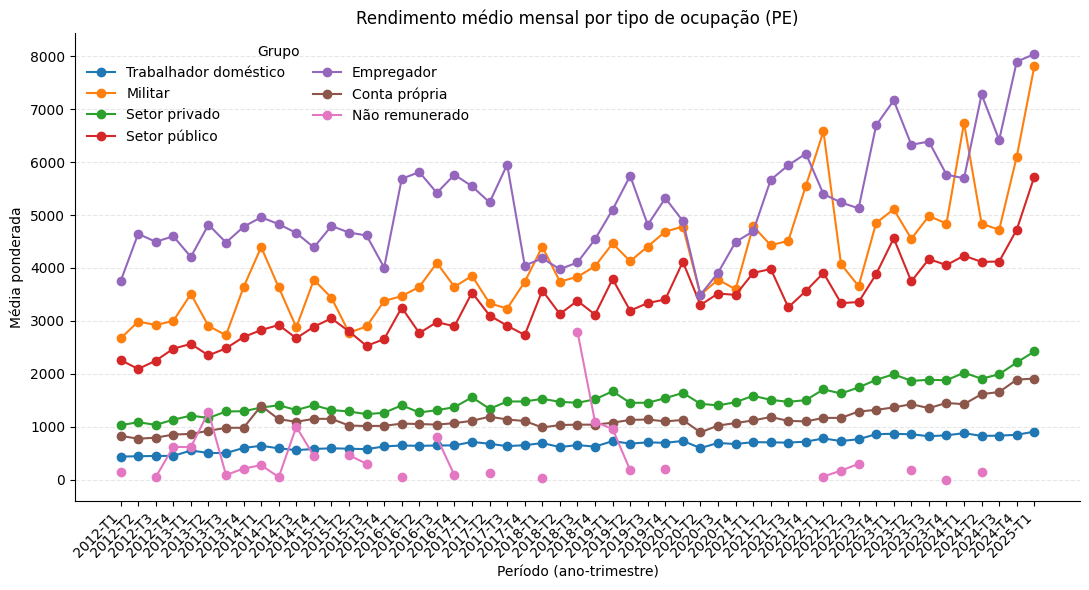

In [25]:
fig, ax = line_mean_by_quarter_grouped(
    df, value_col="vd4020_rend_efet_trab_total",
    group_col="v4012_c",
    class_labels=VARDICT_TRABALHO_BASICO["v4012_c"],
    class_order=VARDICT_TRABALHO_BASICO["v4012_c"].values(),
    title="Rendimento médio mensal por tipo de ocupação (PE)"
)

# Frequência escolar x idade x sexo

## Anos de educação × Densidade por sexo

- Qual é a distribuição dos anos de educação entre os indivíduos que frequentam escola?
- As curvas masculina e feminina apresentam formatos semelhantes ou distintos?
- Em quais faixas de anos de estudo há maior concentração de estudantes?
- O pico da densidade ocorre em quantos anos de escolarização para cada sexo?
- Há faixas em que a presença feminina ou masculina é predominante?
- As curvas indicam presença de atraso escolar (acúmulo em faixas baixas de anos de estudo)?
- O gráfico mostra maior continuidade educacional entre meninas (densidade mais alta em anos avançados)?
- Os meninos apresentam maior evasão ou atraso escolar, concentrando-se em anos iniciais?
- As densidades sugerem diferenças na progressão educacional por gênero?
- Há sobreposição entre as curvas (equilíbrio) ou distanciamento crescente com o avanço dos anos de estudo?
- O formato das curvas indica normalidade (concentração no meio) ou assimetria (cauda longa de permanência ou evasão)?

## Idade × Densidade por sexo — frequenta escola (PE)

- Qual é a faixa etária com maior concentração de estudantes em Pernambuco?
- As curvas masculinas e femininas apresentam formatos semelhantes ou diferentes?
- Em que idades a densidade é mais alta (pico da frequência escolar)?
- Há diferenças de idade média entre meninos e meninas que frequentam escola?
- As curvas indicam presença de estudantes mais velhos (atraso escolar) ou muito jovens (entrada precoce)?
- Existe sobreposição significativa entre as curvas ou uma delas domina em determinadas idades?
- O gráfico sugere maior permanência escolar entre meninas, com densidade prolongada em idades mais altas?
- Os meninos tendem a abandonar a escola mais cedo, concentrando-se em idades menores?
- Há deslocamento etário — diferença entre a idade modal (mais frequente) de frequência escolar por sexo?
- O formato das curvas é assimétrico, indicando concentração e evasão em idades específicas?
- A dispersão das curvas revela heterogeneidade na trajetória escolar, como atraso escolar mais acentuado entre meninos?
- As densidades indicam equilíbrio de gênero nas idades escolares típicas (6 a 17 anos)?
- Existe cauda longa (presença de adultos que ainda frequentam escola), e isso difere por sexo?

In [15]:
dataset_path = "datasets/PNAD_3.parquet"

query = """
SELECT
  26 AS uf,
  CAST(COALESCE(NULLIF(v2007, ''), NULL) AS INTEGER) AS v2007,
  CAST(COALESCE(NULLIF(v2009, ''), NULL) AS INTEGER) AS v2009,
  COALESCE(
    CAST(v1027 AS DOUBLE),
    CAST(v1028 AS DOUBLE)
  ) AS peso,
  CAST(COALESCE(NULLIF(v3001, ''), NULL) AS INTEGER) AS v3001,
  CAST(COALESCE(NULLIF(vd3005, ''), NULL) AS DOUBLE) AS vd3005
FROM bronze.ibge__pnadctri
WHERE uf = '26'
  AND v2007 IN ('1','2')
"""

if not os.path.exists(dataset_path):
    s3_url = "s3://observatorio-trabalho-pe-ds-resources-dev/"

    df = query_athena_to_polars(
        query,
        s3_url,
        lazy_mode=False
    )

    df.write_parquet(dataset_path)

else:
    df = pl.read_parquet(dataset_path)

df.shape

(1101633, 6)

In [16]:
from typing import Optional, Tuple
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

def graf2_densidade_por_sexo(
    df: pl.DataFrame | pl.LazyFrame,
    x_col: str = "vd3005",
    *,
    sex_col: str = "v2007",
    weight_col: Optional[str] = None,
    prefer_weight_order: Tuple[str, ...] = ("peso","v1032","v1031","v1028","v1027"),
    enrolled_only: bool = True,
    enrolled_col: str = "v3001",
    enrolled_value: int = 1,
    bins: int = 128,
    bandwidth: Optional[float] = None,
    trim_quantiles: Tuple[float, float] = (0.01, 0.99),
    title: Optional[str] = None,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None,
    figsize: Tuple[float, float] = (10, 6),
):
    """
    Plota densidades com linhas preenchidas por sexo (1=Masculino, 2=Feminino) para a variável contínua `x_col`, ponderadas por peso.
    """
    if isinstance(df, pl.LazyFrame):
        df = df.collect()
    cols = set(df.columns)
    if x_col not in cols:
        raise ValueError(f"{x_col} ausente")
    if sex_col not in cols:
        raise ValueError(f"{sex_col} ausente")
    if weight_col is None:
        for c in prefer_weight_order:
            if c in cols:
                weight_col = c
                break
    if weight_col is None:
        raise ValueError("Coluna de peso não encontrada")
    use_cols = [x_col, sex_col, weight_col]
    if enrolled_only and enrolled_col in cols:
        use_cols.append(enrolled_col)
    df = df.select(use_cols).drop_nulls(subset=[x_col, sex_col, weight_col])
    df = df.filter(pl.col(sex_col).is_in([1, 2]))
    if enrolled_only and enrolled_col in df.columns:
        df = df.filter(pl.col(enrolled_col) == enrolled_value)
    if df.height == 0:
        fig, ax = plt.subplots(figsize=figsize)
        ax.set_title("Sem dados para plotar")
        return fig, ax
    v = df.select(pl.col(x_col)).to_series().to_numpy()
    lo, hi = np.nanquantile(v, trim_quantiles[0]), np.nanquantile(v, trim_quantiles[1])
    if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
        lo, hi = float(np.nanmin(v)), float(np.nanmax(v))
    if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
        lo, hi = 0.0, 1.0
    grid = np.linspace(lo, hi, bins)
    def _hist_smooth(values: np.ndarray, w: np.ndarray, grid: np.ndarray, bw: Optional[float]) -> np.ndarray:
        if values.size == 0 or np.sum(w) <= 0:
            return np.zeros_like(grid)
        h, edges = np.histogram(values, bins=bins, range=(grid.min(), grid.max()), weights=w, density=False)
        mids = 0.5 * (edges[1:] + edges[:-1])
        step = mids[1] - mids[0] if len(mids) > 1 else (grid[1] - grid[0])
        total_w = np.sum(w)
        h = h.astype(float) / (total_w * max(step, 1e-9))
        if bw is None or not np.isfinite(bw) or bw <= 0:
            q75, q25 = np.nanpercentile(values, 75), np.nanpercentile(values, 25)
            iqr = q75 - q25 if np.isfinite(q75 - q25) and (q75 - q25) > 0 else np.nanstd(values) * 1.349
            bw = 0.9 * min(np.nanstd(values), iqr) * (len(values) ** (-1/5)) if len(values) > 1 else max(step, 1e-9)
            if not np.isfinite(bw) or bw <= 0:
                bw = max(step, 1e-9) * 2.0
        radius = int(max(1, np.ceil(3 * bw / max(step, 1e-9))))
        xk = np.arange(-radius, radius + 1) * step
        kernel = np.exp(-0.5 * (xk / bw) ** 2)
        kernel /= kernel.sum()
        hs = np.convolve(h, kernel, mode="same")
        return np.interp(grid, mids, hs) if len(mids) > 1 else np.full_like(grid, hs[0] if hs.size else 0.0)
    male = df.filter(pl.col(sex_col) == 1)
    female = df.filter(pl.col(sex_col) == 2)
    x_m = male.select(pl.col(x_col)).to_series().to_numpy()
    w_m = male.select(pl.col(weight_col)).to_series().to_numpy()
    x_f = female.select(pl.col(x_col)).to_series().to_numpy()
    w_f = female.select(pl.col(weight_col)).to_series().to_numpy()
    d_m = _hist_smooth(x_m, w_m, grid, bandwidth)
    d_f = _hist_smooth(x_f, w_f, grid, bandwidth)
    fig, ax = plt.subplots(figsize=figsize)
    line_m, = ax.plot(grid, d_m, label="Masculino")
    fill_m = ax.fill_between(grid, d_m, 0, alpha=0.25)
    line_f, = ax.plot(grid, d_f, label="Feminino")
    fill_f = ax.fill_between(grid, d_f, 0, alpha=0.25)
    line_m.set_color("#1f77b4")
    line_f.set_color("#e377c2")
    fill_m.set_color("#1f77b4")
    fill_f.set_color("#e377c2")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_title(title or "Frequência escolar × Densidade por sexo")
    ax.set_xlabel(xlabel or x_col)
    ax.set_ylabel(ylabel or "Densidade")
    ax.grid(True, linestyle="--", alpha=0.3, axis="y")
    ax.legend(frameon=False)
    fig.tight_layout()
    return fig, ax

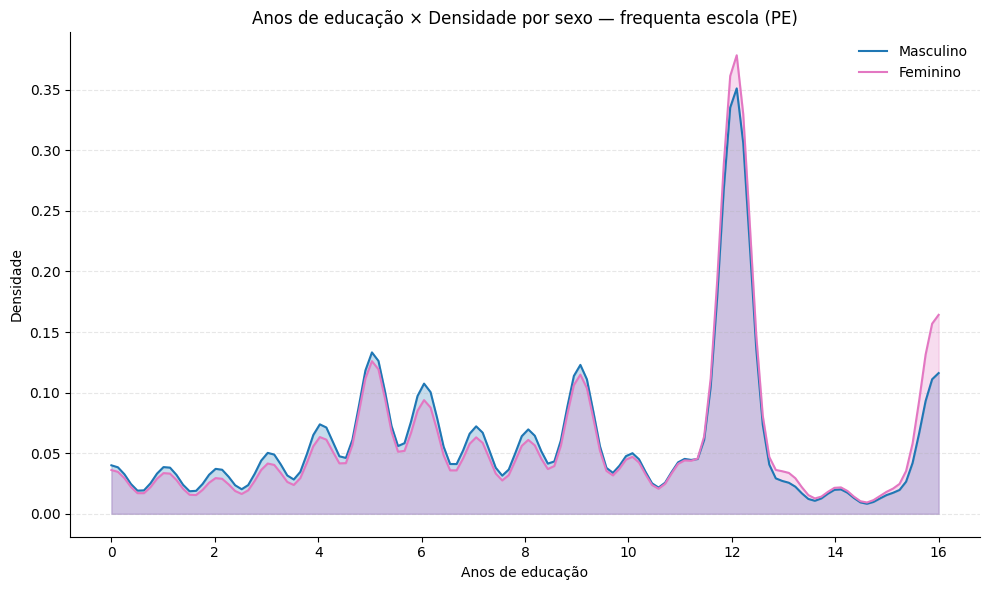

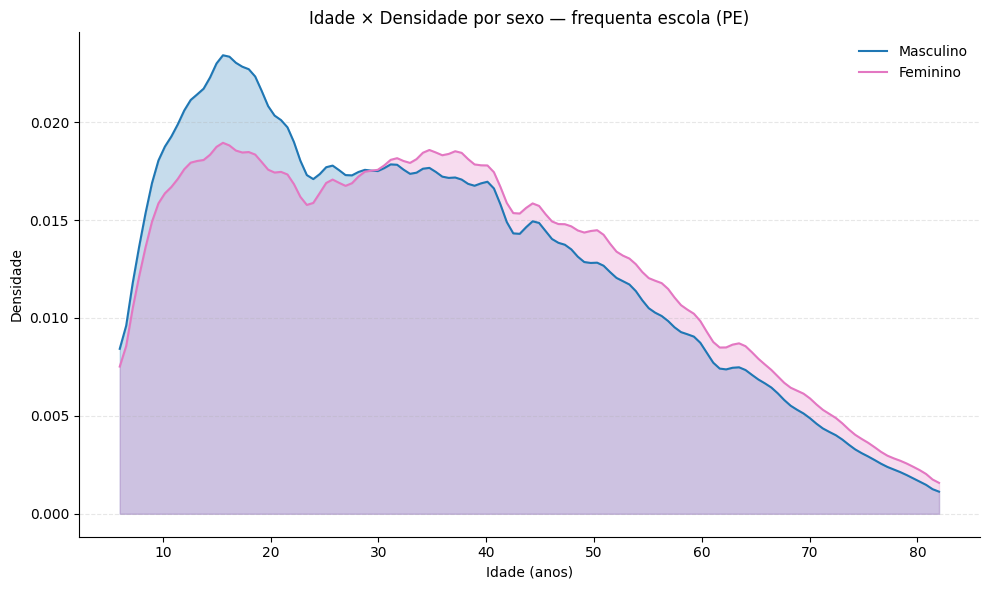

In [17]:
fig, ax = graf2_densidade_por_sexo(
    df, x_col="vd3005",
    title="Anos de educação × Densidade por sexo — frequenta escola (PE)",
    xlabel="Anos de educação", ylabel="Densidade"
)
fig, ax = graf2_densidade_por_sexo(
    df, x_col="v2009",
    title="Idade × Densidade por sexo — frequenta escola (PE)",
    xlabel="Idade (anos)", ylabel="Densidade"
)
plt.show()

# Cruzamento de sexo x idade x nível de escolaridade

- Qual é o nível de escolaridade mais comum em cada faixa etária?
- Há diferenças visíveis entre homens e mulheres em termos de escolaridade média?
- A concentração de pontos (densidade) é maior em quais idades e níveis de escolaridade?
- Existe acúmulo de indivíduos com baixa escolaridade em idades mais avançadas?
- Há tendência de aumento da escolaridade conforme a idade (gerações mais novas com mais anos de estudo)?
- As curvas implícitas (nuvens) masculinas e femininas têm formatos semelhantes ou distintos?
- O gráfico indica maior escolarização feminina nas faixas etárias jovens?
- As diferenças de escolaridade entre os sexos diminuem ou aumentam com a idade?
- As gerações mais velhas apresentam baixa escolarização independentemente do gênero?
- Há indícios de convergência educacional (homens e mulheres alcançando níveis similares nas coortes mais novas)?
- A distribuição sugere transição educacional ao longo das gerações, com crescimento da escolaridade entre jovens?
- Existe maior variabilidade (dispersão) de escolaridade em um dos sexos?
- As mulheres mostram menor dispersão e maior concentração em níveis altos, sinalizando trajetória mais homogênea?

In [18]:
dataset_path = "datasets/PNAD_4.parquet"

query = """
WITH base AS (
  SELECT
    26 AS uf,
    CAST(COALESCE(NULLIF(v2007, ''), NULL) AS INTEGER) AS v2007,
    CAST(COALESCE(NULLIF(v2009, ''), NULL) AS INTEGER) AS v2009,
    COALESCE(
      CAST(v1027 AS DOUBLE),
      CAST(v1028 AS DOUBLE)
    ) AS peso,
    CAST(COALESCE(NULLIF(vd3004, ''), NULL) AS INTEGER) AS vd3004
  FROM bronze.ibge__pnadctri
  WHERE uf = '26'
)
SELECT *
FROM base
WHERE v2007 IN (1,2)
  AND vd3004 IS NOT NULL
  AND v2009 IS NOT NULL
"""

if not os.path.exists(dataset_path):
    s3_url = "s3://observatorio-trabalho-pe-ds-resources-dev/"

    df = query_athena_to_polars(
        query,
        s3_url,
        lazy_mode=False
    )

    df.write_parquet(dataset_path)

else:
    df = pl.read_parquet(dataset_path)

In [19]:
from typing import Optional, Dict, Tuple, Literal
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def graf3_scatter_escolaridade_idade_sexo_v2(
    df: pl.DataFrame | pl.LazyFrame,
    *,
    x_col: str = "vd3004",
    y_col: str = "v2009",
    sex_col: str = "v2007",
    weight_col: Optional[str] = None,
    prefer_weight_order: Tuple[str, ...] = ("peso","v1032","v1031","v1028","v1027"),
    mode: Literal["points","hex"] = "points",
    alpha: float = 0.25,
    size: float = 18.0,
    jitter_x: float = 0.15,
    jitter_y: float = 0.0,
    dodge_x: float = 0.12,
    max_points_per_sex: Optional[int] = 20000,
    gridsize: int = 35,
    min_count: float = 0.0,
    class_labels: Optional[Dict[int, str]] = None,
    figsize: Tuple[float, float] = (10, 6),
    title: Optional[str] = None,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None,
):
    """
    Scatter de escolaridade (x) vs idade (y) por sexo, com modos 'points' (transparência/jitter/amostragem) e 'hex' (agregação). Se `class_labels` for passado, aplica rótulos no eixo X.
    """
    if isinstance(df, pl.LazyFrame):
        df = df.collect()
    cols = set(df.columns)
    if x_col not in cols or y_col not in cols or sex_col not in cols:
        raise ValueError("Colunas obrigatórias ausentes")
    if weight_col is None:
        for c in prefer_weight_order:
            if c in cols:
                weight_col = c
                break
    d = df.select([x_col, y_col, sex_col] + ([weight_col] if weight_col else []))
    d = d.drop_nulls(subset=[x_col, y_col, sex_col]).filter(pl.col(sex_col).is_in([1, 2]))
    if d.height == 0:
        fig, ax = plt.subplots(figsize=figsize)
        ax.set_title("Sem dados para plotar")
        return fig, ax
    x = d.select(pl.col(x_col).cast(pl.Float64)).to_series().to_numpy()
    y = d.select(pl.col(y_col).cast(pl.Float64)).to_series().to_numpy()
    s = d.select(pl.col(sex_col).cast(pl.Int32)).to_series().to_numpy()
    w = d.select(pl.col(weight_col).cast(pl.Float64)).to_series().to_numpy() if weight_col and weight_col in d.columns else None
    rng = np.random.default_rng(12345)
    if mode == "points":
        if max_points_per_sex is not None:
            idx_m = np.where(s == 1)[0]
            idx_f = np.where(s == 2)[0]
            if idx_m.size > max_points_per_sex:
                if w is not None:
                    p = w[idx_m] / np.sum(w[idx_m])
                    idx_m = rng.choice(idx_m, size=max_points_per_sex, replace=False, p=p)
                else:
                    idx_m = rng.choice(idx_m, size=max_points_per_sex, replace=False)
            if idx_f.size > max_points_per_sex:
                if w is not None:
                    p = w[idx_f] / np.sum(w[idx_f])
                    idx_f = rng.choice(idx_f, size=max_points_per_sex, replace=False, p=p)
                else:
                    idx_f = rng.choice(idx_f, size=max_points_per_sex, replace=False)
            keep = np.concatenate([idx_m, idx_f])
            x, y, s = x[keep], y[keep], s[keep]
            if w is not None:
                w = w[keep]
        dx_m = -dodge_x if dodge_x else 0.0
        dx_f = +dodge_x if dodge_x else 0.0
        jx = rng.normal(0.0, jitter_x, size=x.shape) if jitter_x and jitter_x > 0 else 0.0
        jy = rng.normal(0.0, jitter_y, size=y.shape) if jitter_y and jitter_y > 0 else 0.0
        x_adj = x + jx + np.where(s == 1, dx_m, dx_f)
        y_adj = y + jy
        fig, ax = plt.subplots(figsize=figsize)
        mask_m = s == 1
        mask_f = s == 2
        ax.scatter(x_adj[mask_m], y_adj[mask_m], s=size, c="#1f77b4", alpha=alpha, edgecolors="none", label="Masculino")
        ax.scatter(x_adj[mask_f], y_adj[mask_f], s=size, c="#e377c2", alpha=alpha, edgecolors="none", label="Feminino")
    else:
        fig, ax = plt.subplots(figsize=figsize)
        for sex_val, color in [(1, "#1f77b4"), (2, "#e377c2")]:
            m = s == sex_val
            if not np.any(m):
                continue
            xv, yv = x[m], y[m]
            wv = w[m] if w is not None else None
            ax.hexbin(
                xv, yv,
                C=wv,
                reduce_C_function=(np.sum if wv is not None else np.size),
                gridsize=gridsize,
                mincnt=min_count if wv is None else 0,
                cmap=ListedColormap([color]),
                alpha=alpha
            )
    if class_labels:
        ticks = sorted({int(t) for t in np.unique(x) if np.isfinite(t)})
        lbls = [class_labels.get(int(t), str(int(t))) for t in ticks]
        ax.set_xticks(ticks)
        ax.set_xticklabels(lbls, rotation=45)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_title(title or "Escolaridade × Idade por sexo (PE)")
    ax.set_xlabel(xlabel or "Nível de escolaridade")
    ax.set_ylabel(ylabel or "Idade (anos)")
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.legend(frameon=False, loc="best")
    fig.tight_layout()
    return fig, ax


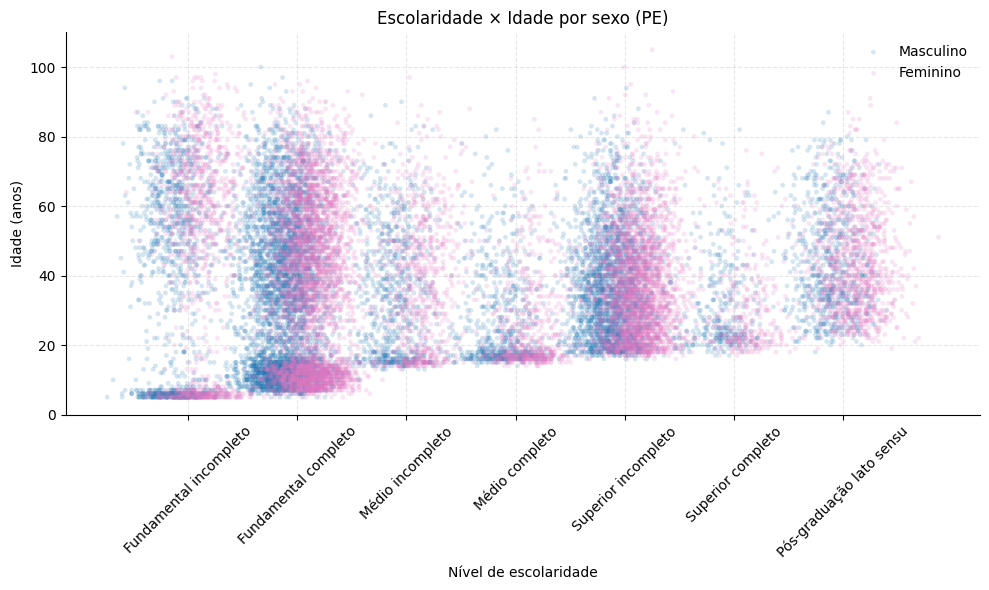

In [20]:
VD3004_MAP = {
    0: "Sem instrução",
    1: "Fundamental incompleto",
    2: "Fundamental completo",
    3: "Médio incompleto",
    4: "Médio completo",
    5: "Superior incompleto",
    6: "Superior completo",
    7: "Pós-graduação lato sensu",
    8: "Pós-graduação stricto sensu"
}

fig, ax = graf3_scatter_escolaridade_idade_sexo_v2(
    df,
    x_col="vd3004",
    y_col="v2009",
    sex_col="v2007",
    mode="points",
    alpha=0.18,
    size=12.0,
    jitter_x=0.2,
    dodge_x=0.12,
    max_points_per_sex=10000,
    class_labels=VD3004_MAP,
    title="Escolaridade × Idade por sexo (PE)"
)
plt.show()

# Contagens por condição no domicílio (relação com o responsável pelo domicílio)

- Qual é o número de pessoas em cada categoria de relação com o responsável pelo domicílio?
- Qual é a condição mais frequente (por exemplo, filhos ou cônjuges)?
- Quantas pessoas são chefes de domicílio (pessoas de referência) em comparação com os demais grupos?
- Há muitos agregados ou pensionistas, indicando convivência ampliada?
- Qual é o peso relativo de empregados domésticos e familiares não parentes?
- O total de moradores está concentrado em poucos tipos de relação ou distribuído de forma equilibrada?
- O gráfico mostra predomínio de estruturas familiares nucleares (referência, cônjuge, filhos) ou ampliadas (outros parentes, agregados)?
- A proporção de filhos sugere taxas elevadas de dependência nos domicílios?
- Há baixa presença de cônjuges, indicando alta proporção de lares monoparentais?
- O número de pensionistas ou agregados pode refletir dificuldades econômicas e compartilhamento de moradia?
- A presença de empregados domésticos é indicativo de níveis de renda mais altos em parte dos domicílios?
- A composição por condição domiciliar é consistente com padrões demográficos (tamanho médio das famílias, estrutura etária)?

In [25]:
dataset_path = "datasets/PNAD_5.parquet"

query = """
SELECT
  26 AS uf,
  TRY_CAST(v2005 AS INTEGER) AS v2005,
  COALESCE(CAST(v1027 AS DOUBLE), CAST(v1028 AS DOUBLE)) AS peso
FROM bronze.ibge__pnadctri
WHERE CAST(uf AS INTEGER) = 26
  AND TRY_CAST(v2005 AS INTEGER) IS NOT NULL
"""

if not os.path.exists(dataset_path):
    s3_url = "s3://observatorio-trabalho-pe-ds-resources-dev/"

    df = query_athena_to_polars(
        query,
        s3_url,
        lazy_mode=False
    )

    df.write_parquet(dataset_path)

else:
    df = pl.read_parquet(dataset_path)

In [23]:
from typing import Optional, Dict, Tuple, List
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

def graf4_barras_categorica(
    df: pl.DataFrame | pl.LazyFrame,
    *,
    class_col: str = "v2005",
    weight_col: Optional[str] = None,
    prefer_weight_order: Tuple[str, ...] = ("peso","v1032","v1031","v1028","v1027"),
    class_labels: Optional[Dict[int, str]] = None,
    class_order: Optional[List[str]] = None,
    normalize: bool = False,
    annotate: bool = True,
    figsize: Tuple[float, float] = (8, 5),
    title: Optional[str] = None,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None,
):
    """
    Plota barras ponderadas por categoria. Se `normalize=True`, exibe percentuais.
    """
    if isinstance(df, pl.LazyFrame):
        df = df.collect()
    cols = set(df.columns)
    if class_col not in cols:
        raise ValueError("Coluna de classe ausente")
    if weight_col is None:
        for c in prefer_weight_order:
            if c in cols:
                weight_col = c
                break
    if weight_col is None:
        raise ValueError("Coluna de peso não encontrada")
    d = df.select([class_col, weight_col]).drop_nulls()
    if class_labels:
        map_df = pl.DataFrame({"__raw": list(class_labels.keys()), "__lab": list(class_labels.values())})
        d = (d.with_columns(pl.col(class_col).cast(pl.Int64).alias("__raw"))
               .join(map_df, on="__raw", how="inner")
               .rename({"__lab":"classe"}))
        cat_col = "classe"
    else:
        d = d.with_columns(pl.col(class_col).cast(pl.Utf8).alias("classe"))
        cat_col = "classe"
    agg = d.group_by(cat_col).agg(pl.sum(weight_col).alias("valor"))
    if normalize:
        total = float(agg.select(pl.sum("valor")).item())
        agg = agg.with_columns((pl.col("valor")/max(total,1e-12)*100).alias("valor"))
    vals = agg.to_dict(as_series=False)
    labels = vals[cat_col]
    values = np.array(vals["valor"], dtype=float)
    if class_order:
        order_idx = {lab:i for i,lab in enumerate(labels)}
        idx = [order_idx[c] for c in class_order if c in order_idx] + [i for i,lab in enumerate(labels) if lab not in set(class_order)]
        labels = [labels[i] for i in idx]
        values = values[idx]
    fig, ax = plt.subplots(figsize=figsize)
    x = np.arange(len(labels))
    bars = ax.bar(x, values)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_title(title or "Distribuição por categoria (PE)")
    ax.set_xlabel(xlabel or "Categoria")
    ax.set_ylabel(ylabel or ("Percentual (%)" if normalize else "Quantidade ponderada"))
    ax.grid(True, axis="y", linestyle="--", alpha=0.3)
    if annotate:
        for rect, v in zip(bars, values):
            ax.text(rect.get_x()+rect.get_width()/2, rect.get_height(), f"{v:.1f}" if not normalize else f"{v:.1f}%", ha="center", va="bottom", fontsize=9)
    fig.tight_layout()
    return fig, ax


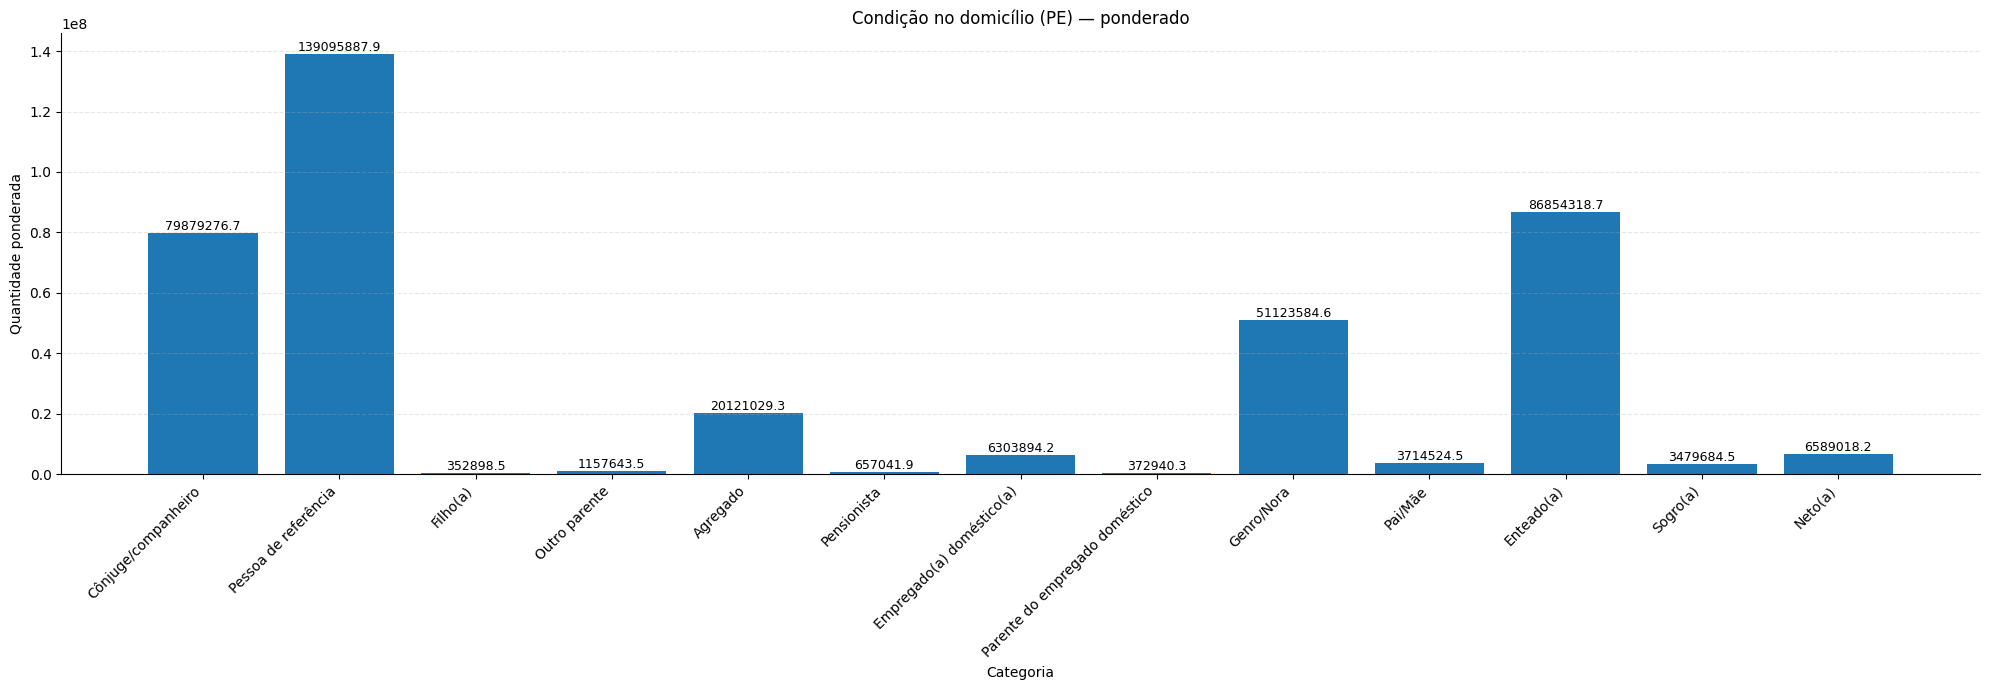

In [26]:
V2005_LABELS = {
    1:"Pessoa de referência",
    2:"Cônjuge/companheiro",
    3:"Filho(a)",
    4:"Enteado(a)",
    5:"Genro/Nora",
    6:"Pai/Mãe",
    7:"Sogro(a)",
    8:"Neto(a)",
    9:"Outro parente",
    10:"Agregado",
    11:"Pensionista",
    12:"Empregado(a) doméstico(a)",
    13:"Parente do empregado doméstico"
}

fig, ax = graf4_barras_categorica(
    df,
    class_col="v2005",
    class_labels=V2005_LABELS,
    class_order=["Cônjuge/companheiro","Pessoa de referência","Filho(a)","Outro parente","Agregado","Pensionista","Empregado(a) doméstico(a)","Parente do empregado doméstico"],
    title="Condição no domicílio (PE) — ponderado",
    figsize=(20, 7)
)
plt.show()

In [27]:
from typing import Optional, Dict, Tuple, List
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import cm

def graf5_treemap_condicao_domicilio(
    df: pl.DataFrame | pl.LazyFrame,
    *,
    group_col: str = "v2005",
    weight_col: Optional[str] = None,
    prefer_weight_order: Tuple[str, ...] = ("peso","v1032","v1031","v1028","v1027"),
    labels_map: Optional[Dict[int,str]] = None,
    order_labels: Optional[List[str]] = None,
    normalize: bool = False,
    min_label_area: float = 0.01,
    cmap_name: str = "tab20",
    figsize: Tuple[float,float] = (10, 6),
    title: Optional[str] = None,
):
    """
    Desenha um treemap ponderado para a variável categórica `group_col` (ex.: v2005), usando o peso amostral.
    
    Parâmetros
    ----------
    df : pl.DataFrame | pl.LazyFrame
        Dados com a categoria e o peso.
    group_col : str
        Coluna categórica a agregar (ex.: "v2005").
    weight_col : Optional[str]
        Coluna de peso. Se None, detecta pela ordem em `prefer_weight_order`.
    labels_map : Optional[Dict[int,str]]
        Mapeamento código->rótulo para mostrar nos quadrados.
    order_labels : Optional[List[str]]
        Ordem desejada dos rótulos no treemap.
    normalize : bool
        Se True, usa percentuais sobre o total; caso contrário, usa o valor ponderado.
    min_label_area : float
        Área mínima (0–1) para desenhar rótulos dentro dos retângulos.
    cmap_name : str
        Nome do colormap Matplotlib para colorir as categorias.
    figsize : Tuple[float,float]
        Tamanho da figura.
    title : Optional[str]
        Título do gráfico.
    
    Retorno
    -------
    (fig, ax) : objetos Matplotlib
    """
    if isinstance(df, pl.LazyFrame):
        df = df.collect()
    cols = set(df.columns)
    if group_col not in cols:
        raise ValueError("Coluna de grupo ausente")
    if weight_col is None:
        for c in prefer_weight_order:
            if c in cols:
                weight_col = c
                break
    if weight_col is None:
        raise ValueError("Coluna de peso não encontrada")
    d = df.select([group_col, weight_col]).drop_nulls()
    if labels_map:
        map_df = pl.DataFrame({"__raw": list(labels_map.keys()), "__lab": list(labels_map.values())})
        d = (d.with_columns(pl.col(group_col).cast(pl.Int64).alias("__raw"))
               .join(map_df, on="__raw", how="inner")
               .rename({"__lab":"classe"}))
        cat_col = "classe"
    else:
        d = d.with_columns(pl.col(group_col).cast(pl.Utf8).alias("classe"))
        cat_col = "classe"
    agg = d.group_by(cat_col).agg(pl.sum(weight_col).alias("valor"))
    if agg.height == 0:
        fig, ax = plt.subplots(figsize=figsize)
        ax.set_title("Sem dados para plotar")
        return fig, ax
    if normalize:
        tot = float(agg.select(pl.sum("valor")).item())
        agg = agg.with_columns((pl.col("valor")/max(tot,1e-12)*100).alias("valor"))
    vals = agg.to_dict(as_series=False)
    labels = vals[cat_col]
    values = np.array(vals["valor"], dtype=float)
    if order_labels:
        idx_map = {lab:i for i,lab in enumerate(labels)}
        order_idx = [idx_map[l] for l in order_labels if l in idx_map] + [i for i,l in enumerate(labels) if l not in set(order_labels)]
        labels = [labels[i] for i in order_idx]
        values = values[order_idx]
    values = np.maximum(values, 0.0)
    if values.sum() == 0:
        fig, ax = plt.subplots(figsize=figsize)
        ax.set_title("Sem valores positivos para plotar")
        return fig, ax
    sizes = values / values.sum()
    def _squarify(sizes, x, y, w, h):
        out = []
        sizes = list(sizes)
        row = []
        def worst(row, w, h):
            if not row:
                return np.inf
            s = sum(row)
            m = max(row); n = min(row)
            side = min(w, h)
            return max((side**2)*m/(s**2), (s**2)/(side**2*n)) if n > 0 else np.inf
        def layout_row(row, x, y, w, h, horizontal=True):
            s = sum(row)
            if s <= 0:
                return [], x, y, w, h
            if horizontal:
                row_h = s / w if w > 0 else 0
                rects = []
                cx = x
                for r in row:
                    rw = r / row_h if row_h > 0 else 0
                    rects.append((cx, y, rw, row_h))
                    cx += rw
                return rects, x, y + row_h, w, h - row_h
            else:
                row_w = s / h if h > 0 else 0
                rects = []
                cy = y
                for r in row:
                    rh = r / row_w if row_w > 0 else 0
                    rects.append((x, cy, row_w, rh))
                    cy += rh
                return rects, x + row_w, y, w - row_w, h
        horizontal = True
        while sizes:
            r = sizes.pop(0)
            if not row or worst(row + [r], w, h) <= worst(row, w, h):
                row.append(r)
            else:
                rects, x, y, w, h = layout_row(row, x, y, w, h, horizontal)
                out.extend(rects)
                row = [r]
                horizontal = not horizontal
        if row:
            rects, x, y, w, h = layout_row(row, x, y, w, h, horizontal)
            out.extend(rects)
        return out
    rects = _squarify(sizes, 0.0, 0.0, 1.0, 1.0)
    cmap = cm.get_cmap(cmap_name, len(labels))
    colors = [cmap(i) for i in range(len(labels))]
    fig, ax = plt.subplots(figsize=figsize)
    for (x, y, w, h), lab, val, col in zip(rects, labels, values, colors):
        ax.add_patch(Rectangle((x, y), w, h, facecolor=col, edgecolor="white"))
        area = w*h
        if area >= min_label_area:
            txt = f"{lab}\n{val:.1f}%" if normalize else f"{lab}\n{val:,.0f}"
            ax.text(x + w/2, y + h/2, txt, ha="center", va="center", fontsize=9, color="black")
    ax.set_xlim(0,1); ax.set_ylim(0,1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(title or ("Condição no domicílio — Treemap (Percentual)" if normalize else "Condição no domicílio — Treemap (Ponderado)"))
    fig.tight_layout()
    return fig, ax


C:\Users\RafaelMarinh_5k9komz\AppData\Local\Temp\ipykernel_22324\1177577383.py:144: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, len(labels))


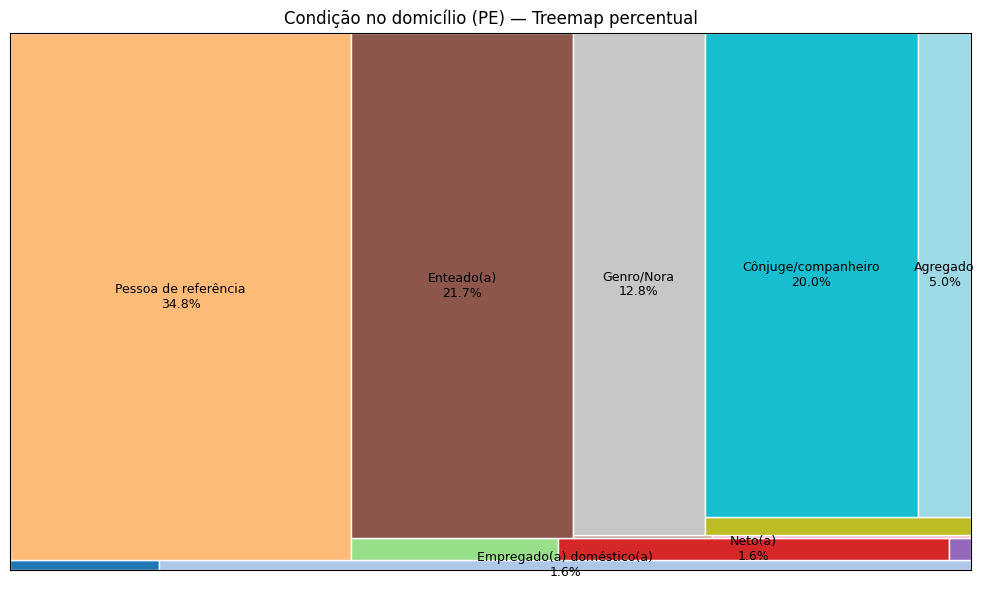

In [28]:
fig, ax = graf5_treemap_condicao_domicilio(
    df,
    group_col="v2005",
    labels_map=V2005_LABELS,
    normalize=True,
    min_label_area=0.015,
    title="Condição no domicílio (PE) — Treemap percentual"
)
plt.show()